In [1]:
# !pip install --upgrade pip
# !pip install natsort
# !pip install albumentations
# !pip install wandb
# !pip install torchinfo
# !pip install schema
# !pip install torchmetrics
# !pip install einops
# !pip install timm
# !pip install natsort
# !pip install torchsummary
# !pip install natsort

## Cell 1 - Imports and Base Setup:

In [2]:
import os
import sys
from pathlib import Path
from typing import Dict, List, Optional, Union, Tuple
from abc import ABC, abstractmethod

# Add CellViT to python path first
cellvit_path = "/rsrch5/home/plm/yshokrollahi/CellViT"
if cellvit_path not in sys.path:
    sys.path.append(cellvit_path)
    print(f"Added {cellvit_path} to Python path")

import yaml
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import albumentations as A

try:
    from cell_segmentation.datasets.pannuke import PanNukeDataset
    from cell_segmentation.datasets.tissuenet import TissueNetDataset
    print("Successfully imported CellViT modules")
except ImportError as e:
    print(f"Import error: {e}")
    raise

Added /rsrch5/home/plm/yshokrollahi/CellViT to Python path


/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Successfully imported CellViT modules


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Cell 2 - Base Dataset Class:

In [4]:
class BaseModalityDataset(Dataset, ABC):
    """Base class for all modality datasets"""
    
    def __init__(self, dataset_path: Path, split: str, transforms=None):
        self.dataset_path = dataset_path
        self.split = split
        self.transforms = transforms
        self.modality_type = self._get_modality_type()
        
    @abstractmethod
    def _get_modality_type(self) -> str:
        """Return the modality type identifier"""
        pass
    
    def standardize_output(self, image, targets, metadata) -> Dict:
        """Standardize the output format across all modalities"""
        return {
            'image': image,
            'metadata': {
                'modality_type': self.modality_type,
                'available_targets': self._get_available_targets(),
                **metadata
            },
            'targets': targets
        }
    
    @abstractmethod
    def _get_available_targets(self) -> List[str]:
        """Return list of available target types for this modality"""
        pass
    
    @abstractmethod
    def __len__(self):
        pass
    
    @abstractmethod
    def __getitem__(self, idx):
        pass

## Cell 3 - TissueNet Standardized Implementation:

In [5]:
from pathlib import Path
from typing import Dict, List, Optional, Union, Tuple
import numpy as np
import torch
from scipy.ndimage import center_of_mass
from abc import ABC, abstractmethod

class TissueNetStandardized(BaseModalityDataset):
    def __init__(self, dataset_path: Path, split: str, transforms=None, **kwargs):
        super().__init__(dataset_path, split, transforms)
        self.dataset = TissueNetDataset(
            dataset_path=dataset_path,
            split=split,
            transforms=transforms,
            stardist=False,
            regression=False,
            cache_dataset=False,
            **kwargs
        )
    
    def _get_modality_type(self) -> str:
        return 'tissuenet'
    
    def _get_available_targets(self) -> List[str]:
        return ['nuclei', 'membrane', 'hv_maps']
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        data = self.dataset[idx]
        
        if isinstance(data, (tuple, list)):
            image = data[0]
            original_targets = data[1]
        else:
            image = data['image']
            original_targets = data.get('targets', {})
        
        standardized_targets = {
            'masks': {
                'nuclei': original_targets.get('nuclei_mask', None),
                'membrane': original_targets.get('cell_mask', None)
            },
            'semantic': {
                'has_membrane': True
            },
            'hv_maps': {
                'nuclei': original_targets.get('nuclei_hv_map', None),
                'membrane': original_targets.get('cell_hv_map', None)
            }
        }
        
        metadata = {
            'original_size': image.shape[-2:],
        }
        
        return self.standardize_output(image, standardized_targets, metadata)

## Cell 4 - PanNuke Standardized Implementation:

In [17]:
from pathlib import Path
from typing import Dict, List, Optional, Union, Tuple
import numpy as np
import torch
from scipy.ndimage import center_of_mass
from abc import ABC, abstractmethod

class PanNukeStandardized(BaseModalityDataset):
    def __init__(self, dataset_path: Path, split: str, transforms=None, folds=None, val_ratio=0.1):
        super().__init__(dataset_path, split, transforms)
        
        # Keep existing initialization
        if split == 'test':
            self.dataset = PanNukeDataset(
                dataset_path=dataset_path,
                folds=[2],
                transforms=transforms,
                stardist=False,
                regression=False,
                cache_dataset=False
            )
            self.indices = list(range(len(self.dataset)))
        else:
            self.dataset = PanNukeDataset(
                dataset_path=dataset_path,
                folds=[0, 1],
                transforms=transforms,
                stardist=False,
                regression=False,
                cache_dataset=False
            )
            total_len = len(self.dataset)
            val_size = int(total_len * val_ratio)
            train_size = total_len - val_size
            all_indices = list(range(total_len))
            
            if split == 'train':
                self.indices = all_indices[:train_size]
            else:  # val
                self.indices = all_indices[train_size:]
        
        # Cell type mappings
        self.cell_types = {
            0: 'Background',
            1: 'Neoplastic',
            2: 'Inflammatory',
            3: 'Connective',
            4: 'Dead',
            5: 'Epithelial'
        }
        
        # Tissue types remain the same
        self.tissue_types = {
            'Breast': 0, 'Colon': 1, 'Liver': 2, 'Kidney': 3,
            'Prostate': 4, 'Bladder': 5, 'Ovarian': 6, 'Uterus': 7,
            'Thyroid': 8, 'Testis': 9, 'Lung': 10, 'Esophagus': 11,
            'Skin': 12, 'Head&Neck': 13, 'Bile-duct': 14, 'Stomach': 15,
            'Pancreatic': 16, 'Adrenal': 17
        }
        
        # Initialize sampling related attributes
        self.cell_counts = None
        self.tissue_counts = None
        
    def load_cell_count(self):
        """Calculate number of images containing each cell type"""
        if self.cell_counts is not None:
            return

        # Initialize counts for presence of each cell type in images
        self.cell_counts = {i: 0 for i in range(1, len(self.cell_types))}  # Skip background (0)

        # Count images containing each cell type
        for idx in self.indices:
            data = self.dataset[idx]
            if isinstance(data, (tuple, list)):
                targets = data[1]
            else:
                targets = data.get('targets', {})

            cell_types = targets.get('nuclei_type_map', None)
            if cell_types is not None:
                unique_types = np.unique(cell_types)
                # Count presence of each cell type (excluding background)
                for cell_type in unique_types:
                    if cell_type > 0 and cell_type in self.cell_counts:
                        self.cell_counts[cell_type] += 1

        print("Images containing each cell type:")
        for cell_type, count in self.cell_counts.items():
            print(f"{self.cell_types[cell_type]}: {count} images")

    
    def get_sampling_weights_cell(self, gamma=0.85, min_weight=0.2, max_boost=4.0):
        """
        Optimized sampling weights calculation combining both approaches

        Args:
            gamma (float): Power factor for balancing (0.85 gives moderate boost)
            min_weight (float): Minimum weight floor (0.2 ensures representation)
            max_boost (float): Maximum boost multiplier (4.0 prevents extreme oversampling)
        """
        if self.cell_counts is None:
            self.load_cell_count()

        weights = np.ones(len(self), dtype=np.float32)

        # Reference counts from original implementation
        reference_counts = {
            1: 4191,  # Neoplastic
            2: 4132,  # Inflammatory
            3: 6140,  # Connective
            4: 232,   # Dead
            5: 1528   # Epithelial
        }

        # Calculate class frequencies and weights
        total_samples = sum(self.cell_counts.values())
        class_weights = {}

        for cell_type, count in self.cell_counts.items():
            if count > 0:
                freq = count / total_samples
                ref_freq = reference_counts[cell_type] / sum(reference_counts.values())

                if cell_type == 4:  # Dead cells
                    # Special handling for extremely rare class
                    class_weight = min((1.0 / freq) ** 0.75, max_boost)
                    class_weight *= 1.3  # Slight additional boost
                elif cell_type == 5:  # Epithelial
                    # Moderate boost for underrepresented class
                    class_weight = (1.0 / freq) ** 0.8
                elif freq < ref_freq * 0.8:  # Significantly underrepresented
                    class_weight = (1.0 / freq) ** gamma
                else:  # Common classes
                    class_weight = (1.0 / freq) ** 0.5

                class_weights[cell_type] = min(class_weight, max_boost)

        # Normalize weights
        max_weight = max(class_weights.values())
        class_weights = {k: max(v/max_weight, min_weight) for k, v in class_weights.items()}

        # Assign sample weights with dynamic boosting
        for i, idx in enumerate(self.indices):
            data = self.dataset[idx]
            if isinstance(data, (tuple, list)):
                targets = data[1]
            else:
                targets = data.get('targets', {})

            cell_types = targets.get('nuclei_type_map', None)

            if cell_types is not None:
                unique_types = np.unique(cell_types)
                sample_weights = []

                for t in unique_types:
                    if t > 0:  # Skip background
                        weight = class_weights.get(t, min_weight)
                        if t == 4:  # Dead cells
                            weight *= 1.2
                        elif t == 5:  # Epithelial
                            weight *= 1.1
                        sample_weights.append(weight)

                weights[i] = max(sample_weights) if sample_weights else min_weight
            else:
                weights[i] = min_weight

        # Final normalization with smoothing
        weights = np.maximum(weights, min_weight)
        weights = weights / weights.sum()

        return weights

    # Keep all existing methods
    def _get_modality_type(self) -> str:
        return 'pannuke'
    
    def _get_available_targets(self) -> List[str]:
        return ['cell', 'cell_types', 'hv_maps']
    
    def gen_instance_hv_map(self, inst_map: np.ndarray) -> np.ndarray:
        """Generate horizontal and vertical maps"""
        if len(inst_map.shape) != 2:
            raise ValueError(f"Instance map should be 2D, got shape {inst_map.shape}")

        x_map = np.zeros(inst_map.shape[:2], dtype=np.float32)
        y_map = np.zeros(inst_map.shape[:2], dtype=np.float32)

        inst_list = list(np.unique(inst_map))
        if 0 in inst_list:
            inst_list.remove(0)

        for inst_id in inst_list:
            inst = (inst_map == inst_id).astype(np.uint8)
            
            rows = np.any(inst, axis=1)
            cols = np.any(inst, axis=0)
            if not np.any(rows) or not np.any(cols):
                continue
                
            y1, y2 = np.where(rows)[0][[0, -1]]
            x1, x2 = np.where(cols)[0][[0, -1]]
            
            inst_crop = inst[y1:y2+1, x1:x2+1]
            
            if inst_crop.shape[0] < 2 or inst_crop.shape[1] < 2:
                continue

            cy, cx = center_of_mass(inst_crop)
            
            y_coords, x_coords = np.mgrid[0:inst_crop.shape[0], 0:inst_crop.shape[1]]
            
            x_coords = (x_coords - cx) / (inst_crop.shape[1] - 1) * 2
            y_coords = (y_coords - cy) / (inst_crop.shape[0] - 1) * 2
            
            x_coords[inst_crop == 0] = 0
            y_coords[inst_crop == 0] = 0
            
            x_map[y1:y2+1, x1:x2+1][inst_crop > 0] = x_coords[inst_crop > 0]
            y_map[y1:y2+1, x1:x2+1][inst_crop > 0] = y_coords[inst_crop > 0]

        return np.stack([x_map, y_map])
    
    def get_cell_type_name(self, type_idx: int) -> str:
        """Convert cell type index to name"""
        return self.cell_types.get(type_idx, f'Unknown Type {type_idx}')
    
    def get_tissue_type_id(self, tissue_name: str) -> int:
        """Convert tissue name to ID"""
        return self.tissue_types.get(tissue_name, -1)
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        data = self.dataset[self.indices[idx]]

        if isinstance(data, (tuple, list)):
            image = data[0]
            original_targets = data[1]
            tissue_type = data[2]
            img_name = data[3]
        else:
            image = data['image']
            original_targets = data.get('targets', {})
            tissue_type = None
            img_name = None

        # Update cell type handling to account for background class
        cell_mask = original_targets.get('instance_map', None)
        cell_types = original_targets.get('nuclei_type_map', None)
        
        # Add 1 to cell types to shift classes (0->1, 1->2, etc.) to match new mapping
        if cell_types is not None:
            if cell_mask is not None:
                cell_types[cell_mask == 0] = 0  # Just ensure background is 0

        cell_hv_map = self.gen_instance_hv_map(cell_mask.numpy()) if cell_mask is not None else None
        tissue_type_id = self.get_tissue_type_id(tissue_type) if tissue_type else None

        standardized_targets = {
            'masks': {
                'cell': cell_mask,
            },
            'semantic': {
                'cell_types': cell_types,
                'tissue_type': tissue_type_id,
                'has_membrane': False
            },
            'hv_maps': {
                'cell': torch.tensor(cell_hv_map) if cell_hv_map is not None else None
            }
        }

        metadata = {
            'original_size': image.shape[-2:],
            'fold': getattr(self.dataset, 'current_fold', None),
            'tissue_type': tissue_type,
            'tissue_type_id': tissue_type_id,
            'img_name': img_name,
            'cell_type_mapping': self.cell_types,
            'tissue_type_mapping': self.tissue_types
        }

        return self.standardize_output(image, standardized_targets, metadata)

## Cell 5 - Enhanced Dataset Manager:

In [18]:
class ModularDatasetManager:
    def __init__(self):
        # Dataset paths
        self.tissuenet_path = Path("/rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/tissuenet")
        self.pannuke_path = Path("/rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/reassemble")
        
        # Config paths
        self.tissuenet_config_path = Path("/rsrch5/home/plm/yshokrollahi/CellViT/configs/examples/cell_segmentation/vitaminp-tissuenet.yaml")
        self.pannuke_config_path = Path("/rsrch5/home/plm/yshokrollahi/CellViT/configs/examples/cell_segmentation/pannuke-vitaminp.yaml")
        
        self._load_configs()
        self.datasets = {}

    def print_dataset_info(self, split: str):
        """Print information about datasets for a given split"""
        print(f"\nDataset information for split '{split}':")
        for modality, splits in self.datasets.items():
            if split in splits:
                print(f"{modality}: {len(splits[split])} samples")
    
    def _load_configs(self):
        try:
            with open(self.tissuenet_config_path, 'r') as file:
                self.tissuenet_config = yaml.safe_load(file)
            with open(self.pannuke_config_path, 'r') as file:
                self.pannuke_config = yaml.safe_load(file)
            print("Successfully loaded configuration files")
        except Exception as e:
            print(f"Error loading configs: {e}")
            raise

    def get_transforms(self, transform_settings, input_shape=256):
        transforms = []
        if input_shape != 256:
            transforms.append(A.Resize(input_shape, input_shape))
        
        transforms.extend([
            A.RandomRotate90(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Downscale(scale_min=0.5, scale_max=1.0, p=0.15),
            A.Blur(blur_limit=9, p=0.2),
            A.GaussNoise(var_limit=50, p=0.25),
            A.ElasticTransform(p=0.2),
        ])
        
        if 'normalize' in transform_settings:
            transforms.append(A.Normalize(**transform_settings['normalize']))
        
        return A.Compose(transforms)

    @staticmethod
    def custom_collate_fn(batch):
       images = []
       masks = {
           'nuclei': [],
           'membrane': [],
           'cell': []
       }
       semantic = {
           'has_membrane': [],
           'cell_types': [],
           'tissue_type': []
       }
       metadata = {
           'original_channels': [],
           'sample_metadata': []
       }
       hv_maps = {
           'nuclei': [],
           'membrane': [],
           'cell': []
       }

       max_channels = max(item['image'].shape[0] for item in batch)

       for item in batch:
           # Handle image
           image = item['image']
           metadata['original_channels'].append(image.shape[0])
           if image.shape[0] < max_channels:
               padding = torch.zeros((max_channels - image.shape[0], *image.shape[1:]), 
                                  dtype=image.dtype, device=image.device)
               image = torch.cat([image, padding], dim=0)
           images.append(image)

           # Handle masks
           for mask_type in masks:
               if mask_type in item['targets']['masks'] and item['targets']['masks'][mask_type] is not None:
                   mask = item['targets']['masks'][mask_type]
                   if mask.dim() == 2:
                       mask = mask.unsqueeze(0)
                   masks[mask_type].append(mask)
               else:
                   zero_mask = torch.zeros((1, *image.shape[-2:]), 
                                        dtype=image.dtype, 
                                        device=image.device)
                   masks[mask_type].append(zero_mask)

           # Handle HV maps
           if 'hv_maps' in item['targets']:
               for hv_type in hv_maps:
                   if hv_type in item['targets']['hv_maps']:
                       hv_maps[hv_type].append(item['targets']['hv_maps'][hv_type])
                   else:
                       zero_map = torch.zeros((2, *image.shape[-2:]), 
                                           dtype=image.dtype, 
                                           device=image.device)
                       hv_maps[hv_type].append(zero_map)
           else:
               for hv_type in hv_maps:
                   zero_map = torch.zeros((2, *image.shape[-2:]), 
                                       dtype=image.dtype, 
                                       device=image.device)
                   hv_maps[hv_type].append(zero_map)

           # Handle cell_types
           if 'cell_types' in item['targets']['semantic']:
               cell_types = item['targets']['semantic']['cell_types']
               if cell_types.dim() == 2:
                   semantic['cell_types'].append(cell_types)
               else:
                   zeros = torch.zeros((*image.shape[-2:],), dtype=torch.long, device=image.device)
                   semantic['cell_types'].append(zeros)
           else:
               zeros = torch.zeros((*image.shape[-2:],), dtype=torch.long, device=image.device)
               semantic['cell_types'].append(zeros)
    
            
           # Boolean values
           has_membrane = item['targets']['semantic'].get('has_membrane', False)
           semantic['has_membrane'].append(torch.tensor(has_membrane, dtype=torch.bool))

           # Tissue type
           tissue_type = item['targets']['semantic'].get('tissue_type', 0)
           semantic['tissue_type'].append(torch.tensor(tissue_type, dtype=torch.long))

           metadata['sample_metadata'].append(item['metadata'])

       try:
           batch_dict = {
               'image': torch.stack(images),
               'targets': {
                   'masks': {},
                   'semantic': {},
                   'hv_maps': {}
               },
               'metadata': {
                   'original_channels': metadata['original_channels'],
                   'padded_channels': max_channels,
                   'sample_metadata': metadata['sample_metadata']
               }
           }

           # Stack masks
           for mask_type, mask_list in masks.items():
               if any(x is not None for x in mask_list):
                   batch_dict['targets']['masks'][mask_type] = torch.stack(mask_list)

           # Stack HV maps
           for hv_type, maps in hv_maps.items():
               if any(x is not None for x in maps):
                   batch_dict['targets']['hv_maps'][hv_type] = torch.stack(maps)

           # Stack semantic data
           batch_dict['targets']['semantic']['cell_types'] = torch.stack(semantic['cell_types'])
           batch_dict['targets']['semantic']['has_membrane'] = torch.stack(semantic['has_membrane'])
           batch_dict['targets']['semantic']['tissue_type'] = torch.stack(semantic['tissue_type'])

           return batch_dict

       except Exception as e:
           print("Error in collate function:", str(e))
           print("Image shapes:", [img.shape for img in images])
           print("Mask shapes:", {k: [m.shape for m in v] for k, v in masks.items()})
           print("HV map shapes:", {k: [m.shape for m in v] for k, v in hv_maps.items()})
           print("Semantic values:", semantic)
           raise e

    def setup_datasets(self):
        print("\nSetting up datasets...")

        # Setup TissueNet
        train_transforms = self.get_transforms(self.tissuenet_config['transformations'])
        val_transforms = A.Compose([
            A.Normalize(**self.tissuenet_config['transformations']['normalize'])
        ])

        self.datasets['tissuenet'] = {
            'train': TissueNetStandardized(
                dataset_path=self.tissuenet_path,
                split='train',
                transforms=train_transforms
            ),
            'val': TissueNetStandardized(
                dataset_path=self.tissuenet_path,
                split='val',
                transforms=val_transforms
            ),
            'test': TissueNetStandardized(
                dataset_path=self.tissuenet_path,
                split='test',
                transforms=val_transforms
            )
        }

        # Setup PanNuke with explicit test set
        self.datasets['pannuke'] = {
            'train': PanNukeStandardized(
                dataset_path=self.pannuke_path,
                split='train',
                transforms=train_transforms,
                val_ratio=0.1  # 10% for validation
            ),
            'val': PanNukeStandardized(
                dataset_path=self.pannuke_path,
                split='val',
                transforms=val_transforms,
                val_ratio=0.1
            ),
            'test': PanNukeStandardized(  # Add test split using fold [2]
                dataset_path=self.pannuke_path,
                split='test',
                transforms=val_transforms
            )
        }

        print("Dataset setup completed!")
        return self.datasets

    def get_dataloader(self, modality: str, split: str, batch_size: int = 32) -> DataLoader:
        dataset = self.datasets[modality][split]

        # Add weighted sampling for PanNuke training
        if modality == 'pannuke' and split == 'train':
            # Calculate weights for cell type balancing
            dataset.load_cell_count()  # This will now count actual instances
            weights = dataset.get_sampling_weights_cell(gamma=0.80)
            sampler = WeightedRandomSampler(
                weights=weights,
                num_samples=len(weights),
                replacement=True
            )
            return DataLoader(
                dataset,
                batch_size=batch_size,
                sampler=sampler,  # Use weighted sampler
                num_workers=4,
                pin_memory=True,
                collate_fn=self.custom_collate_fn
            )
        else:
            # Keep original loader for other cases
            return DataLoader(
                dataset,
                batch_size=batch_size,
                shuffle=(split == 'train'),
                num_workers=4,
                pin_memory=True,
                collate_fn=self.custom_collate_fn
            )

    def get_combined_dataloader(self, split: str, batch_size: int = 32) -> DataLoader:
        """
        Create a balanced combined dataloader that ensures samples from both datasets
        """
        from torch.utils.data import Dataset
        from torch.utils.data import WeightedRandomSampler

        class BalancedConcatDataset(Dataset):
            def __init__(self, datasets, batch_size):
                self.datasets = datasets
                self.batch_size = batch_size
                self.lengths = [len(d) for d in datasets]
                self.total_length = max(self.lengths) * len(datasets)

                # Calculate weights for PanNuke dataset if in training
                self.weights = []
                if split == 'train':
                    for dataset in datasets:
                        if hasattr(dataset, 'load_cell_count'):  # PanNuke dataset
                            dataset.load_cell_count()
                            self.weights.extend(dataset.get_sampling_weights_cell(gamma=1.0))
                        else:  # TissueNet dataset
                            self.weights.extend([1.0] * len(dataset))

            def __len__(self):
                return self.total_length

            def __getitem__(self, idx):
                # Determine which dataset to sample from
                dataset_idx = idx % len(self.datasets)
                # Get item from the corresponding dataset
                item_idx = idx // len(self.datasets) % self.lengths[dataset_idx]
                return self.datasets[dataset_idx][item_idx]

        # Create list of datasets for the given split
        datasets = [
            self.datasets[modality][split]
            for modality in self.datasets
            if split in self.datasets[modality]
        ]

        combined_dataset = BalancedConcatDataset(datasets, batch_size)

        if split == 'train':
            sampler = WeightedRandomSampler(
                weights=combined_dataset.weights,
                num_samples=len(combined_dataset.weights),
                replacement=True
            )

            return DataLoader(
                combined_dataset,
                batch_size=batch_size,
                sampler=sampler,  # Use weighted sampler for training
                num_workers=4,
                pin_memory=True,
                collate_fn=self.custom_collate_fn
            )
        else:
            return DataLoader(
                combined_dataset,
                batch_size=batch_size,
                shuffle=False,
                num_workers=4,
                pin_memory=True,
                collate_fn=self.custom_collate_fn
            )

In [19]:
from torch.utils.data import DataLoader, WeightedRandomSampler

# First cell - Run this only once to set up datasets
def setup_datasets_and_loaders(batch_size=16):
    manager = ModularDatasetManager()
    datasets = manager.setup_datasets()
    
    # Create all dataloaders
    loaders = {
        'mif': {
            'train': manager.get_dataloader('tissuenet', 'train', batch_size),
            'val': manager.get_dataloader('tissuenet', 'val', batch_size),
            'test': manager.get_dataloader('tissuenet', 'test', batch_size)
        },
        'he': {
            'train': manager.get_dataloader('pannuke', 'train', batch_size),
            'val': manager.get_dataloader('pannuke', 'val', batch_size),
            'test': manager.get_dataloader('pannuke', 'test', batch_size)
        },
        'combined': {
            'train': manager.get_combined_dataloader('train', batch_size),
            'val': manager.get_combined_dataloader('val', batch_size)
        }
    }
    
    return manager, datasets, loaders

# Run this once
manager, datasets, loaders = setup_datasets_and_loaders(batch_size=16)

Successfully loaded configuration files

Setting up datasets...


/tmp/ipykernel_9338/312932392.py:41: UserWarning: Argument 'scale_min' is not valid and will be ignored.
  A.Downscale(scale_min=0.5, scale_max=1.0, p=0.15),
/tmp/ipykernel_9338/312932392.py:41: UserWarning: Argument 'scale_max' is not valid and will be ignored.
  A.Downscale(scale_min=0.5, scale_max=1.0, p=0.15),
/tmp/ipykernel_9338/312932392.py:43: UserWarning: Argument 'var_limit' is not valid and will be ignored.
  A.GaussNoise(var_limit=50, p=0.25),


Dataset setup completed!
Images containing each cell type:
Neoplastic: 2481 images
Inflammatory: 2421 images
Connective: 3605 images
Dead: 115 images
Epithelial: 930 images


## Class imbalence Validation

Analyzing HE (PanNuke) training loader:
Analyzing class distribution across batches...


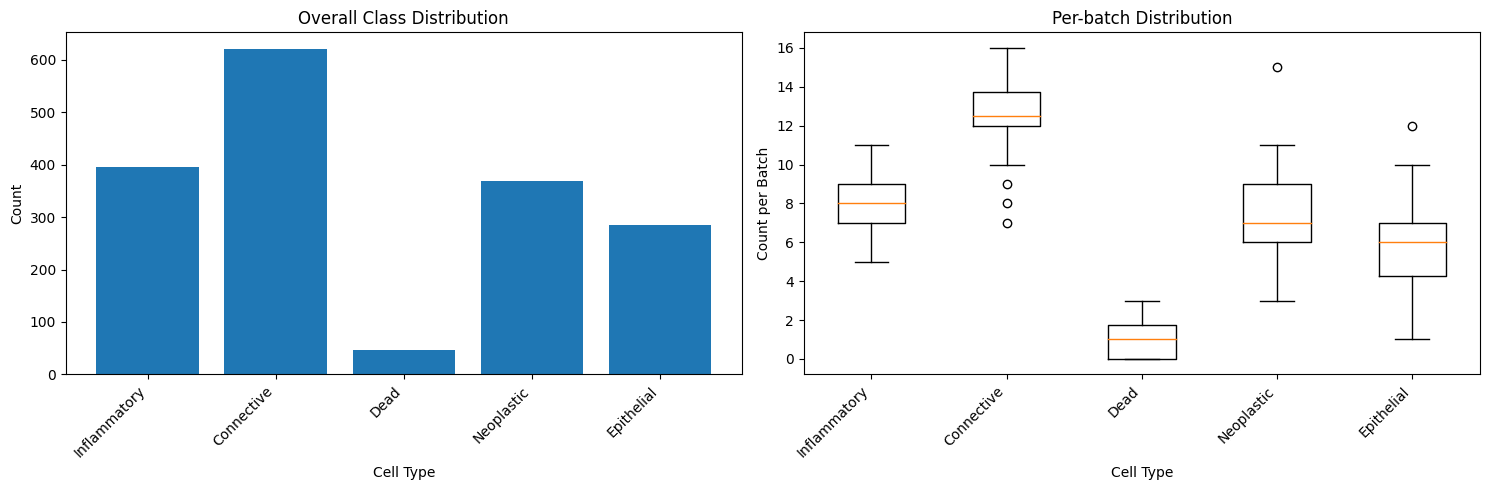


Class distribution statistics:
Inflammatory: 395 (23.02%)
Connective: 621 (36.19%)
Dead: 47 (2.74%)
Neoplastic: 368 (21.45%)
Epithelial: 285 (16.61%)


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def analyze_batch_distribution(loader, num_batches=50):
    # Cell type mapping
    cell_types_map = {
        1: 'Neoplastic',
        2: 'Inflammatory',
        3: 'Connective',
        4: 'Dead',
        5: 'Epithelial'
    }
    
    class_counts = defaultdict(int)
    batch_distributions = []
    
    print("Analyzing class distribution across batches...")
    
    for i, batch in enumerate(loader):
        if i >= num_batches:
            break
            
        # Get cell types from the batch
        cell_types = batch['targets']['semantic']['cell_types']
        
        # Count unique cell types in this batch
        batch_dist = defaultdict(int)
        for img in cell_types:
            unique_types = torch.unique(img)
            for cell_type in unique_types:
                if cell_type != 0:  # Ignore background
                    type_idx = cell_type.item()
                    class_counts[type_idx] += 1
                    batch_dist[type_idx] += 1
        
        batch_distributions.append(dict(batch_dist))
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    # Overall distribution
    plt.subplot(1, 2, 1)
    classes = list(class_counts.keys())
    counts = [class_counts[c] for c in classes]
    
    # Use cell type names for plotting
    class_names = [cell_types_map[c] for c in classes]
    
    plt.bar(class_names, counts)
    plt.title('Overall Class Distribution')
    plt.xlabel('Cell Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
    
    # Box plot of per-batch distributions
    plt.subplot(1, 2, 2)
    data = [[dist.get(c, 0) for dist in batch_distributions] for c in classes]
    plt.boxplot(data, labels=class_names)
    plt.title('Per-batch Distribution')
    plt.xlabel('Cell Type')
    plt.ylabel('Count per Batch')
    plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics with cell type names
    print("\nClass distribution statistics:")
    total = sum(counts)
    for c in classes:
        cell_name = cell_types_map[c]
        print(f"{cell_name}: {class_counts[c]} ({class_counts[c]/total*100:.2f}%)")

# Test with both original and weighted loaders
print("Analyzing HE (PanNuke) training loader:")
analyze_batch_distribution(loaders['he']['train'])

In [23]:
# from torch.utils.data import DataLoader, WeightedRandomSampler

# # Initialize the dataset manager
# manager = ModularDatasetManager()
# manager.setup_datasets()

# # Get the PanNuke training dataset
# pannuke_dataset = manager.datasets['pannuke']['train']

# # Load and print cell counts (now shows images containing each cell type)
# pannuke_dataset.load_cell_count()

# # Calculate sampling weights
# weights = pannuke_dataset.get_sampling_weights_cell(gamma=1.0)

# # Create sampler
# sampler = WeightedRandomSampler(
#     weights=weights,
#     num_samples=len(weights),
#     replacement=True
# )

# # Create test dataloader with the sampler
# test_loader = DataLoader(
#     pannuke_dataset,
#     batch_size=8,
#     sampler=sampler,
#     num_workers=4,
#     pin_memory=True,
#     collate_fn=manager.custom_collate_fn
# )

# # Test a few batches and count class presence
# class_presence = {i: 0 for i in range(1, 6)}  # Only counting cell types, not background
# num_test_batches = 10

# print("\nChecking cell type presence in sampled batches:")
# for i, batch in enumerate(test_loader):
#     if i >= num_test_batches:
#         break
        
#     cell_types = batch['targets']['semantic']['cell_types']
#     for type_vec in cell_types:
#         for class_idx, is_present in enumerate(type_vec[1:], 1):  # Skip background
#             if is_present:
#                 class_presence[class_idx] += 1

# print("\nNumber of images containing each cell type in sampled batches:")
# for class_idx, count in class_presence.items():
#     class_name = pannuke_dataset.cell_types[class_idx]
#     print(f"{class_name}: {count} images")

## Cell 6 - Usage Example:

In [24]:
# print("\nTesting combined loader...")
# # Create manager and setup datasets if not already done
# manager = ModularDatasetManager()
# manager.setup_datasets()

# # Print dataset sizes
# manager.print_dataset_info('train')

# # Test the loader
# combined_train_loader = manager.get_combined_dataloader('train', batch_size=4)
# batch = next(iter(combined_train_loader))

# print("\nBatch structure:")
# print("Image shape:", batch['image'].shape)
# print("Available masks:", list(batch['targets']['masks'].keys()))
# print("Available semantic:", list(batch['targets']['semantic'].keys()))
# print("Sample semantic values:", {k: v.shape if isinstance(v, torch.Tensor) else v 
#                                 for k, v in batch['targets']['semantic'].items()})

# print("\nMask shapes:")
# for mask_type, mask_tensor in batch['targets']['masks'].items():
#     print(f"{mask_type}: {mask_tensor.shape}")

# print("\nOriginal channels per sample:")
# original_channels = batch['metadata']['original_channels']
# for idx, channels in enumerate(original_channels):
#     dataset_type = "PanNuke" if channels == 3 else "TissueNet"
#     print(f"Sample {idx}: {channels} channels ({dataset_type})")

# print("\nSemantic values per sample:")
# for idx in range(batch['image'].shape[0]):
#     print(f"\nSample {idx}:")
#     for key in batch['targets']['semantic']:
#         if batch['targets']['semantic'][key] is not None:
#             value = batch['targets']['semantic'][key][idx]
#             print(f"  {key}: {value}")

# print("\nMask statistics:")
# for mask_type, mask_tensor in batch['targets']['masks'].items():
#     non_zero = torch.count_nonzero(mask_tensor).item()
#     total = mask_tensor.numel()
#     print(f"{mask_type}:")
#     print(f"  - Non-zero elements: {non_zero}")
#     print(f"  - Coverage: {(non_zero/total)*100:.2f}%")

In [25]:


# # Check all splits
# print("\nChecking all splits:")
# for split in ['train', 'val', 'test']:
#     manager.print_dataset_info(split)

In [26]:
# # Check raw data from the base dataset
# pannuke_train = manager.datasets['pannuke']['train']
# raw_data = pannuke_train.dataset[0]  # Get first sample from base dataset
# print("\nRaw data structure:", type(raw_data))
# if isinstance(raw_data, tuple):
#     print("Tuple contents:", [type(x) for x in raw_data])
#    # Print the actual cell type information
#     masks = raw_data[1]
#     print("\nAvailable mask keys:", masks.keys())
#     print("\nNuclei type map shape:", masks['nuclei_type_map'].shape)
#     print("Unique cell types in nuclei_type_map:", torch.unique(masks['nuclei_type_map']))

# elif isinstance(raw_data, dict):
#     print("Dict keys:", raw_data.keys())

# # Check cell type mapping
# print("\nCell type mapping:", pannuke_train.cell_types)


TissueNet Samples:


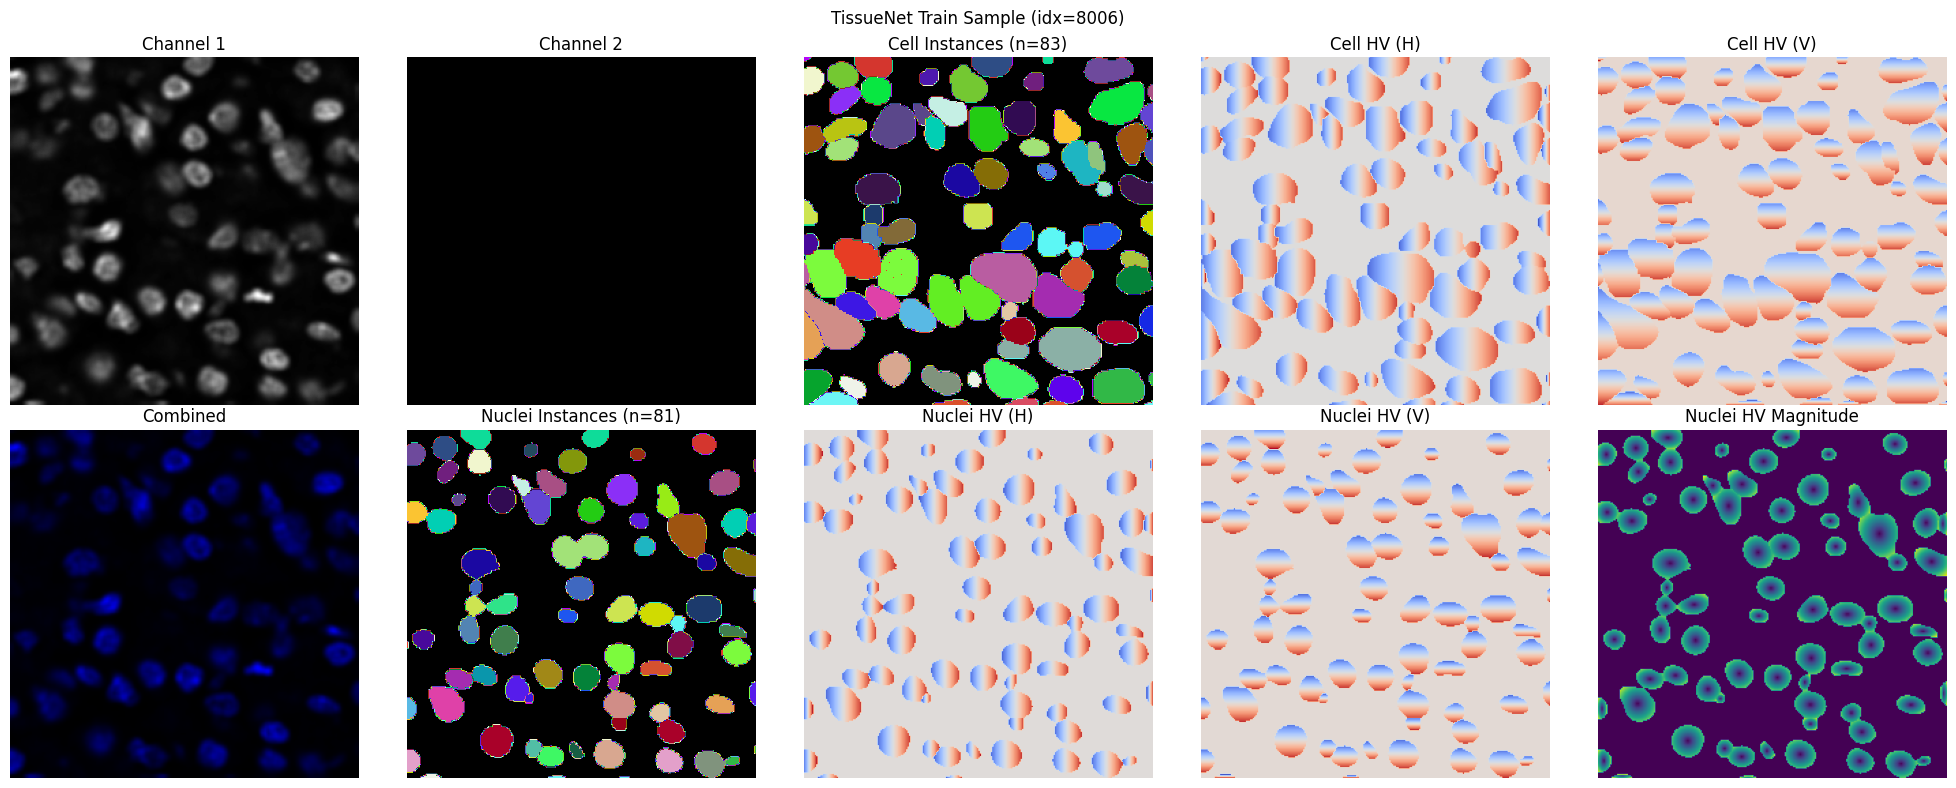

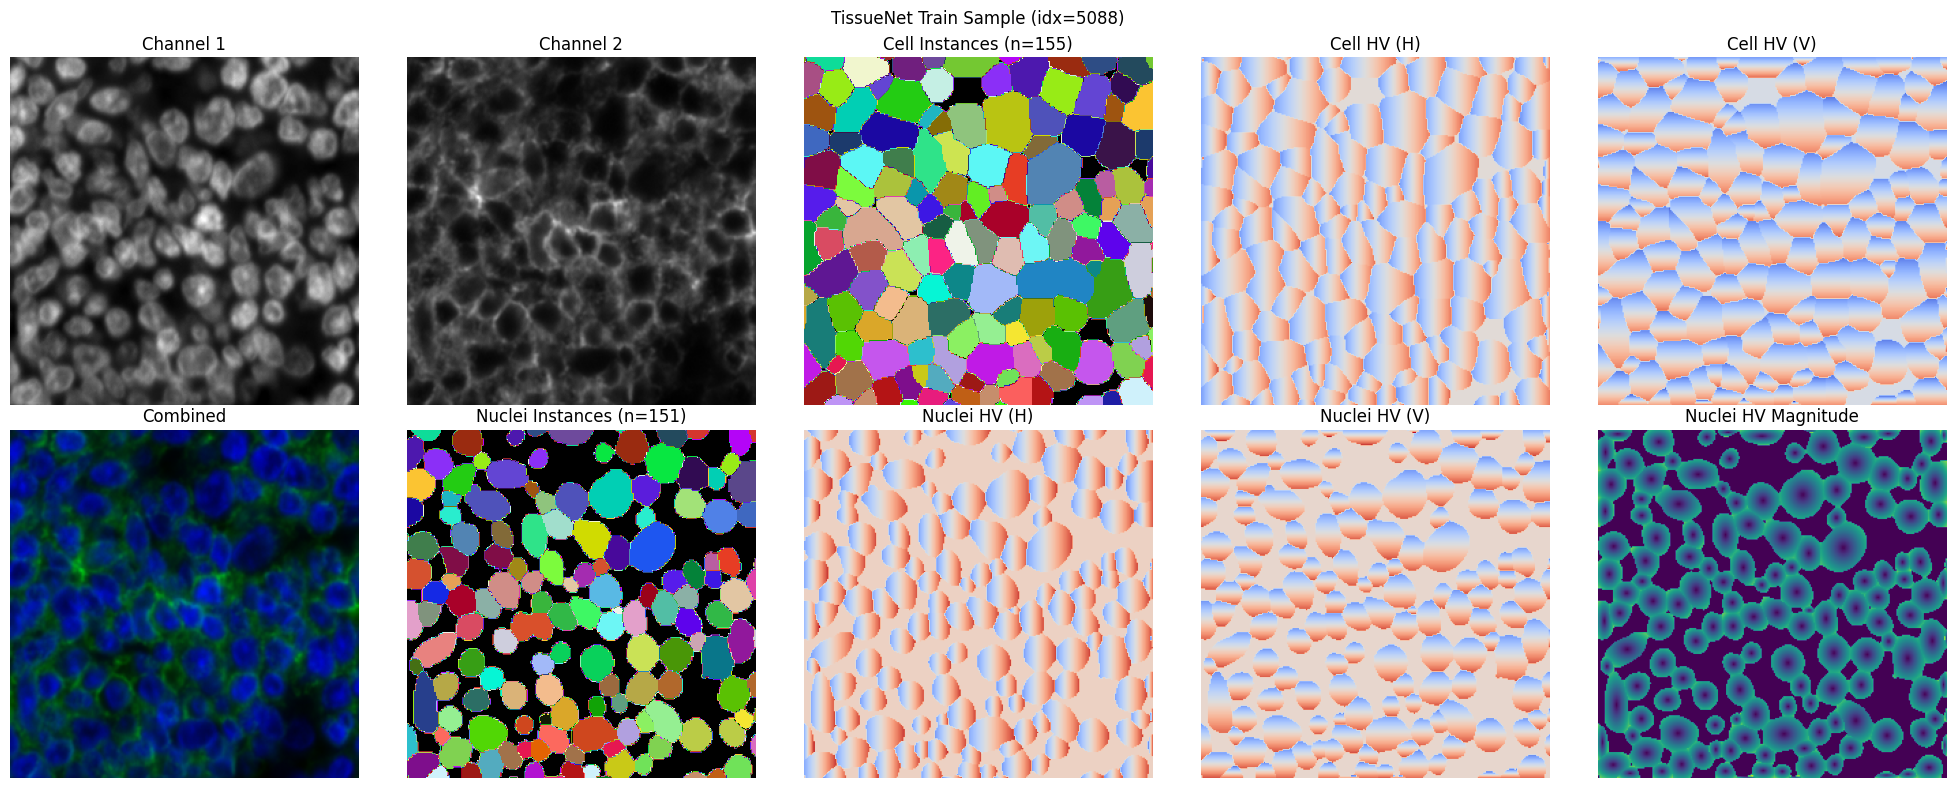


PanNuke Samples:


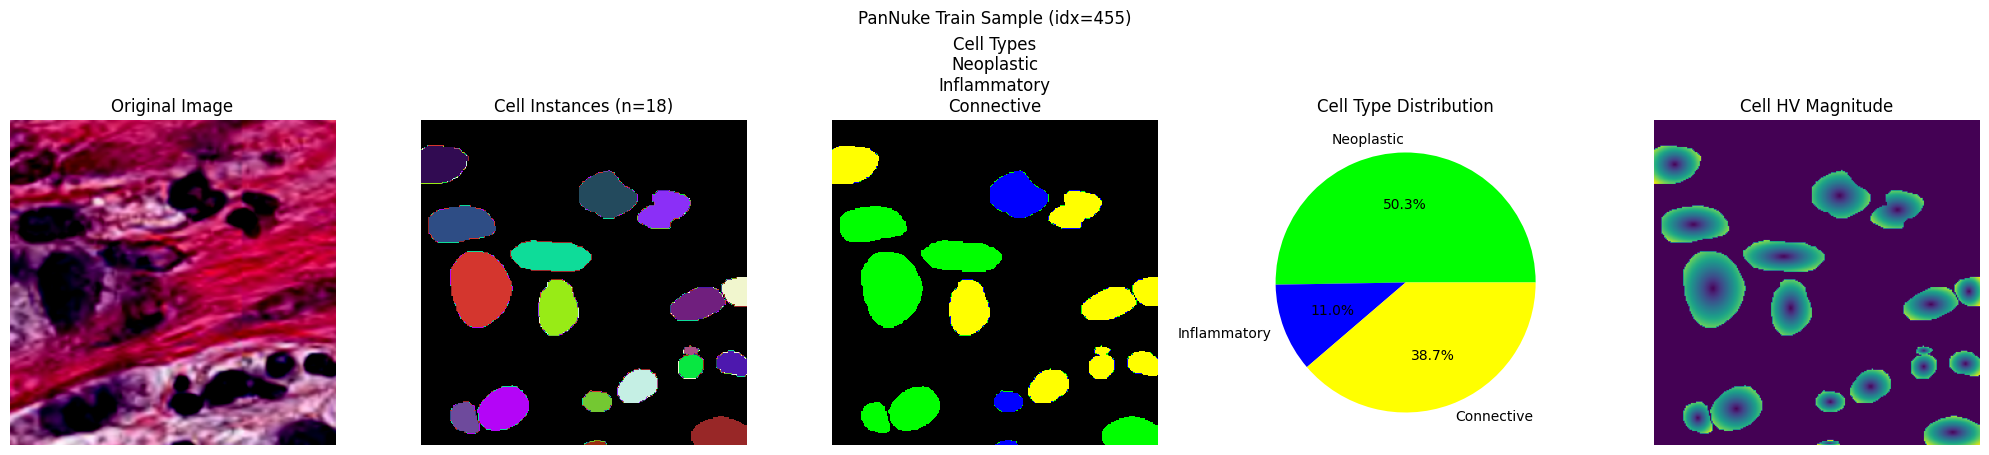

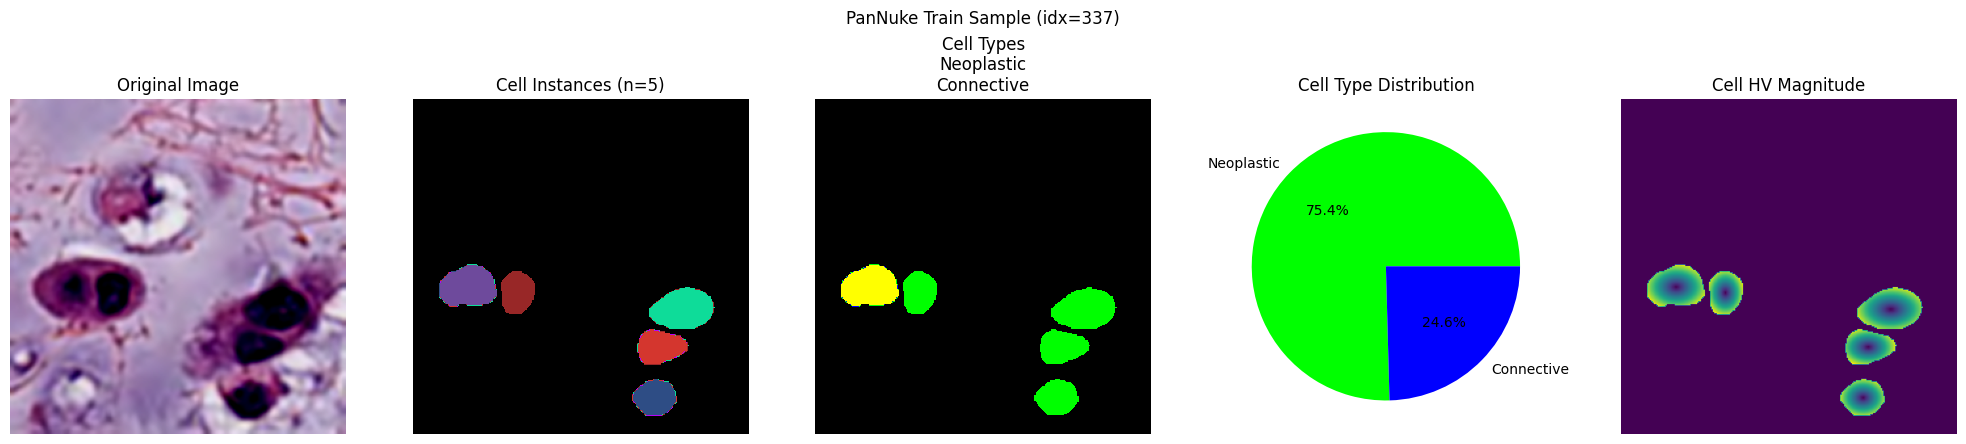

In [28]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from matplotlib.colors import ListedColormap

def create_random_colormap(n_instances):
    """Create a colormap with random distinct colors"""
    np.random.seed(42)  # For reproducibility
    colors = np.random.rand(n_instances + 1, 3)  # +1 for background
    colors[0] = [0, 0, 0]  # Background black
    return ListedColormap(colors)

def get_cell_type_name(type_idx):
    """Convert cell type index to name for PanNuke dataset"""
    class_names = {
        0: "Background",
        1: "Neoplastic",
        2: "Inflammatory",
        3: "Connective",
        4: "Dead",
        5: "Epithelial"
    }
    return class_names.get(type_idx, f'Unknown Type {type_idx}')

def get_cell_type_color(type_idx):
    """Get color for cell type"""
    type_colors = {
        0: 'black',      # Background
        1: '#00FF00',    # Neoplastic
        2: 'blue',       # Inflammatory
        3: 'yellow',     # Connective
        4: 'magenta',    # Dead
        5: 'cyan'        # Epithelial
    }
    return type_colors.get(type_idx, 'gray')

def visualize_sample(sample, title):
    """Visualize a single sample with its masks, HV maps and magnitude"""
    plt.figure(figsize=(20, 8))
    image = sample['image']
    
    if image.shape[0] == 2:  # TissueNet
        # Channel 1
        plt.subplot(251)
        img_ch1 = image[0].numpy()
        if img_ch1.max() > 1:
            img_ch1 = img_ch1 / img_ch1.max()
        plt.imshow(img_ch1, cmap='gray')
        plt.title('Channel 1')
        plt.axis('off')
        
        # Channel 2
        plt.subplot(252)
        img_ch2 = image[1].numpy()
        if img_ch2.max() > 1:
            img_ch2 = img_ch2 / img_ch2.max()
        plt.imshow(img_ch2, cmap='gray')
        plt.title('Channel 2')
        plt.axis('off')
        
        # Cell/Membrane mask
        plt.subplot(253)
        membrane_mask = sample['targets']['masks']['membrane']
        cell_types = sample['targets']['semantic'].get('cell_types', None)
        if membrane_mask is not None:
            n_instances = len(np.unique(membrane_mask.numpy()))
            random_cmap = create_random_colormap(n_instances)
            plt.imshow(membrane_mask, cmap=random_cmap)
            title_str = f'Cell Instances (n={n_instances-1})'
            if cell_types is not None:
                type_idx = cell_types.item() if isinstance(cell_types, torch.Tensor) else cell_types
                title_str += f'\n{get_cell_type_name(type_idx)}'
                plt.imshow(membrane_mask, cmap=ListedColormap([get_cell_type_color(0), get_cell_type_color(type_idx)]))
            plt.title(title_str)
        plt.axis('off')
        
        # Cell HV horizontal
        if 'membrane' in sample['targets'].get('hv_maps', {}):
            plt.subplot(254)
            plt.imshow(sample['targets']['hv_maps']['membrane'][0], cmap='coolwarm')
            plt.title('Cell HV (H)')
            plt.axis('off')
            
            # Cell HV vertical
            plt.subplot(255)
            plt.imshow(sample['targets']['hv_maps']['membrane'][1], cmap='coolwarm')
            plt.title('Cell HV (V)')
            plt.axis('off')
        
        # Combined view
        plt.subplot(256)
        img_ch1 = np.clip((img_ch1 - img_ch1.min()) / (img_ch1.max() - img_ch1.min() + 1e-8), 0, 1)
        img_ch2 = np.clip((img_ch2 - img_ch2.min()) / (img_ch2.max() - img_ch2.min() + 1e-8), 0, 1)
        
        combined_img = np.dstack([
            np.zeros_like(img_ch1),
            img_ch2 * 0.8,
            img_ch1
        ])
        plt.imshow(combined_img)
        plt.title('Combined')
        plt.axis('off')
        
        # Nuclei mask
        plt.subplot(257)
        nuclei_mask = sample['targets']['masks']['nuclei']
        if nuclei_mask is not None:
            n_instances = len(np.unique(nuclei_mask.numpy()))
            random_cmap = create_random_colormap(n_instances)
            plt.imshow(nuclei_mask, cmap=random_cmap)
            plt.title(f'Nuclei Instances (n={n_instances-1})')
        plt.axis('off')
        
        # Nuclei HV maps
        if 'nuclei' in sample['targets'].get('hv_maps', {}):
            plt.subplot(258)
            plt.imshow(sample['targets']['hv_maps']['nuclei'][0], cmap='coolwarm')
            plt.title('Nuclei HV (H)')
            plt.axis('off')
            
            plt.subplot(259)
            plt.imshow(sample['targets']['hv_maps']['nuclei'][1], cmap='coolwarm')
            plt.title('Nuclei HV (V)')
            plt.axis('off')
            
            plt.subplot(2,5,10)
            nuclei_hv = sample['targets']['hv_maps']['nuclei']
            nuclei_hv_magnitude = np.sqrt(nuclei_hv[0]**2 + nuclei_hv[1]**2)
            plt.imshow(nuclei_hv_magnitude, cmap='viridis')
            plt.title('Nuclei HV Magnitude')
            plt.axis('off')
            
    else:  # PanNuke
        # Original image
        plt.subplot(251)
        plt.imshow(image.permute(1, 2, 0).numpy())
        plt.title('Original Image')
        plt.axis('off')
        
        # Instance mask
        plt.subplot(252)
        cell_mask = sample['targets']['masks']['cell']
        if cell_mask is not None:
            n_instances = len(np.unique(cell_mask.numpy()))
            random_cmap = create_random_colormap(n_instances)
            plt.imshow(cell_mask, cmap=random_cmap)
            plt.title(f'Cell Instances (n={n_instances-1})')
            plt.axis('off')
        
        # Cell types visualization
        plt.subplot(253)
        cell_types = sample['targets']['semantic']['cell_types']
        if isinstance(cell_types, torch.Tensor):
            if cell_types.dim() == 1:  # One-hot encoded vector
                # Create a color-coded mask based on the one-hot vector
                type_map = np.zeros_like(cell_mask.numpy())
                for type_idx, is_present in enumerate(cell_types, 1):
                    if is_present:
                        type_map[cell_mask.numpy() > 0] = type_idx
                
                unique_types = np.unique(type_map)
                colors = [get_cell_type_color(t) for t in range(max(unique_types) + 1)]
                plt.imshow(type_map, cmap=ListedColormap(colors))
                plt.title('Cell Types\n' + '\n'.join([get_cell_type_name(t) 
                                                     for t in unique_types if t != 0]))
            else:  # 2D tensor (original format)
                type_map = cell_types.numpy()
                unique_types = np.unique(type_map)
                colors = [get_cell_type_color(t) for t in range(max(unique_types) + 1)]
                plt.imshow(type_map, cmap=ListedColormap(colors))
                plt.title('Cell Types\n' + '\n'.join([get_cell_type_name(t) 
                                                     for t in unique_types if t != 0]))
        plt.axis('off')
        
        # Type distribution pie chart
        plt.subplot(254)
        if isinstance(cell_types, torch.Tensor):
            if cell_types.dim() == 1:  # One-hot encoded vector
                type_counts = {get_cell_type_name(i+1): count.item() 
                             for i, count in enumerate(cell_types) if count > 0}
            else:  # 2D tensor
                unique_types = np.unique(type_map)
                type_counts = {get_cell_type_name(t): (type_map == t).sum() 
                             for t in unique_types if t != 0}
            
            if type_counts:
                colors = [get_cell_type_color(t) for t in range(1, len(type_counts) + 1)]
                plt.pie(type_counts.values(), labels=type_counts.keys(), 
                       autopct='%1.1f%%', colors=colors)
                plt.title('Cell Type Distribution')
        
        # HV maps
        if 'cell' in sample['targets'].get('hv_maps', {}):
            plt.subplot(255)
            cell_hv = sample['targets']['hv_maps']['cell']
            cell_hv_magnitude = np.sqrt(cell_hv[0]**2 + cell_hv[1]**2)
            plt.imshow(cell_hv_magnitude, cmap='viridis')
            plt.title('Cell HV Magnitude')
            plt.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Test visualizations

# Now visualize samples using the existing datasets
print("\nTissueNet Samples:")
for i in range(2):
    idx = np.random.randint(0, len(datasets['tissuenet']['train']))
    sample = datasets['tissuenet']['train'][idx]
    visualize_sample(sample, f'TissueNet Train Sample (idx={idx})')

print("\nPanNuke Samples:")
for i in range(2):
    idx = np.random.randint(0, len(datasets['pannuke']['train']))
    sample = datasets['pannuke']['train'][idx]
    visualize_sample(sample, f'PanNuke Train Sample (idx={idx})')

In [29]:
def analyze_datasets(dataset_manager):
    for modality in ['tissuenet', 'pannuke']:
        print(f"\n{modality.upper()} Dataset Analysis:")
        for split in ['train', 'val', 'test']:
            sample = dataset_manager.datasets[modality][split][0]
            print(f"\n{split} split:")
            print(f"Number of samples: {len(dataset_manager.datasets[modality][split])}")
            print(f"Image channels: {sample['image'].shape[0]}")
            print("Available masks:", list(sample['targets']['masks'].keys()))
            print("Available semantic info:", list(sample['targets']['semantic'].keys()))
            
            # Print shapes
            print("\nShapes:")
            print(f"Image: {sample['image'].shape}")
            for mask_type, mask in sample['targets']['masks'].items():
                if mask is not None:
                    print(f"{mask_type} mask: {mask.shape}")

# Usage
dataset_manager = ModularDatasetManager()
dataset_manager.setup_datasets()
analyze_datasets(dataset_manager)

Successfully loaded configuration files

Setting up datasets...


/tmp/ipykernel_9338/312932392.py:41: UserWarning: Argument 'scale_min' is not valid and will be ignored.
  A.Downscale(scale_min=0.5, scale_max=1.0, p=0.15),
/tmp/ipykernel_9338/312932392.py:41: UserWarning: Argument 'scale_max' is not valid and will be ignored.
  A.Downscale(scale_min=0.5, scale_max=1.0, p=0.15),
/tmp/ipykernel_9338/312932392.py:43: UserWarning: Argument 'var_limit' is not valid and will be ignored.
  A.GaussNoise(var_limit=50, p=0.25),


Dataset setup completed!

TISSUENET Dataset Analysis:

train split:
Number of samples: 10320
Image channels: 2
Available masks: ['nuclei', 'membrane']
Available semantic info: ['has_membrane']

Shapes:
Image: torch.Size([2, 256, 256])
nuclei mask: torch.Size([256, 256])
membrane mask: torch.Size([256, 256])

val split:
Number of samples: 3118
Image channels: 2
Available masks: ['nuclei', 'membrane']
Available semantic info: ['has_membrane']

Shapes:
Image: torch.Size([2, 256, 256])
nuclei mask: torch.Size([256, 256])
membrane mask: torch.Size([256, 256])

test split:
Number of samples: 1324
Image channels: 2
Available masks: ['nuclei', 'membrane']
Available semantic info: ['has_membrane']

Shapes:
Image: torch.Size([2, 256, 256])
nuclei mask: torch.Size([256, 256])
membrane mask: torch.Size([256, 256])

PANNUKE Dataset Analysis:

train split:
Number of samples: 4662
Image channels: 3
Available masks: ['cell']
Available semantic info: ['cell_types', 'tissue_type', 'has_membrane']

Shape

## Model 

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BaseExpert(nn.Module):
    """Abstract base class for all experts"""
    @property
    def input_channels(self):
        raise NotImplementedError

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import swin_v2_b, Swin_V2_B_Weights
from typing import List, Tuple, Literal, OrderedDict
import numpy as np

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class Conv2DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(Conv2DBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x))) + 1e-5 * torch.sum(torch.pow(self.conv.weight, 2))

class Deconv2DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=2, stride=2):
        super(Deconv2DBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.deconv(x)))


class SwinEncoder(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        if pretrained:
            weights = Swin_V2_B_Weights.IMAGENET1K_V1
        else:
            weights = None
        self.swin = swin_v2_b(weights=weights)
        self.swin.head = nn.Identity()  

        # Corrected channel dimensions for extra processing layers
        self.extra_processing = nn.ModuleList([
            nn.Sequential(
                Conv2DBlock(256, 256),  # Changed from 1024 to match input channels
                SEBlock(256),
            ),
            nn.Sequential(
                Conv2DBlock(512, 512),
                SEBlock(512),
            ),
            nn.Sequential(
                Conv2DBlock(1024, 1024),
                SEBlock(1024),
            )
        ])

    def forward(self, x):
        features = []
        for i, layer in enumerate(self.swin.features):
            x = layer(x)
            if i in [2, 4, 6, 7]:  
                curr_x = x.permute(0, 3, 1, 2)  # Change from [B, H, W, C] to [B, C, H, W]
                if len(features) < len(self.extra_processing):
                    curr_x = self.extra_processing[len(features)](curr_x)
                features.append(curr_x)
        return features

class FeaturePyramidNetwork(nn.Module):
    def __init__(self, in_channels_list, out_channels):
        super(FeaturePyramidNetwork, self).__init__()
        self.inner_blocks = nn.ModuleList()
        self.layer_blocks = nn.ModuleList()
        self.extra_blocks = nn.ModuleList()  # New extra processing blocks

        for in_channels in in_channels_list:
            inner_block_module = nn.Conv2d(in_channels, out_channels, 1)
            layer_block_module = nn.Sequential(
                Conv2DBlock(out_channels, out_channels),
                Conv2DBlock(out_channels, out_channels),
                SEBlock(out_channels)
            )
            extra_block = nn.Sequential(
                Conv2DBlock(out_channels, out_channels),
                SEBlock(out_channels)
            )
            
            self.inner_blocks.append(inner_block_module)
            self.layer_blocks.append(layer_block_module)
            self.extra_blocks.append(extra_block)

    def forward(self, x):
        results = []
        
        last_inner = self.inner_blocks[-1](x[-1])
        last_inner = self.extra_blocks[-1](last_inner)  # Extra processing
        results.append(self.layer_blocks[-1](last_inner))

        for feature, inner_block, layer_block, extra_block in zip(
            x[:-1][::-1], 
            self.inner_blocks[:-1][::-1], 
            self.layer_blocks[:-1][::-1],
            self.extra_blocks[:-1][::-1]
        ):
            if last_inner.shape[-2:] != feature.shape[-2:]:
                inner_top_down = F.interpolate(last_inner, size=feature.shape[-2:], mode="nearest")
            else:
                inner_top_down = last_inner
                
            inner_lateral = inner_block(feature)
            last_inner = inner_lateral + inner_top_down
            last_inner = extra_block(last_inner)  # Extra processing
            results.insert(0, layer_block(last_inner))

        return results

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = Conv2DBlock(F_g, F_int, kernel_size=1, padding=0)
        self.W_x = Conv2DBlock(F_l, F_int, kernel_size=1, padding=0)
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)
        self.residual = Conv2DBlock(F_g, F_l, kernel_size=1, padding=0)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        
        if g1.shape[2:] != x1.shape[2:]:
            g1 = F.interpolate(g1, size=x1.shape[2:], mode='bilinear', align_corners=False)
        
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        out = self.residual(out)
        return out + x


class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        self.conv2 = nn.Conv2d(in_channels, out_channels, 3, padding=6, dilation=6, bias=False)
        self.conv3 = nn.Conv2d(in_channels, out_channels, 3, padding=12, dilation=12, bias=False)
        self.conv4 = nn.Conv2d(in_channels, out_channels, 3, padding=18, dilation=18, bias=False)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.conv5 = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        self.conv_out = nn.Conv2d(5 * out_channels, out_channels, 1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        feat1 = self.conv1(x)
        feat2 = self.conv2(x)
        feat3 = self.conv3(x)
        feat4 = self.conv4(x)
        feat5 = self.conv5(self.pool(x))
        feat5 = F.interpolate(feat5, size=x.shape[2:], mode='bilinear', align_corners=False)
        out = torch.cat((feat1, feat2, feat3, feat4, feat5), dim=1)
        out = self.conv_out(out)
        out = self.bn(out)
        return self.relu(out)


class GlobalContextBlock(nn.Module):
    def __init__(self, inplanes, planes, pooling_type='att'):
        super(GlobalContextBlock, self).__init__()
        self.inplanes = inplanes
        self.planes = planes
        self.pooling_type = pooling_type

        if pooling_type == 'att':
            self.conv_mask = nn.Conv2d(inplanes, 1, kernel_size=1)
            self.softmax = nn.Softmax(dim=2)
        else:
            self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.conv_in = nn.Conv2d(inplanes, planes, kernel_size=1)
        self.conv_out = nn.Conv2d(planes, inplanes, kernel_size=1)
        
        # Replace BatchNorm with LayerNorm
        self.ln_in = nn.LayerNorm([planes, 1, 1])
        self.ln_out = nn.LayerNorm([inplanes, 1, 1])

        self.relu = nn.ReLU(inplace=True)

    def spatial_pool(self, x):
        batch, channel, height, width = x.size()
        if self.pooling_type == 'att':
            input_x = x
            input_x = input_x.view(batch, channel, height * width)
            input_x = input_x.unsqueeze(1)
            context_mask = self.conv_mask(x)
            context_mask = context_mask.view(batch, 1, height * width)
            context_mask = self.softmax(context_mask)
            context_mask = context_mask.unsqueeze(-1)
            context = torch.matmul(input_x, context_mask)
            context = context.view(batch, channel, 1, 1)
        else:
            context = self.avg_pool(x)

        return context

    def forward(self, x):
        context = self.spatial_pool(x)
        out = self.conv_in(context)
        out = self.ln_in(out)  # Use LayerNorm instead of BatchNorm
        out = self.relu(out)
        out = self.conv_out(out)
        out = self.ln_out(out)  # Use LayerNorm instead of BatchNorm
        
        return x * out.expand_as(x)

class ImprovedDecoder(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.2):
        super(ImprovedDecoder, self).__init__()
        self.aspp = ASPP(in_channels, 256)
        self.dropout = nn.Dropout(dropout_rate)
        
        # Enhanced conv blocks with residual connections
        self.conv_blocks = nn.ModuleList([
            nn.Sequential(
                self._make_dense_block(256 + in_channels, 128),
                SEBlock(128),
                self.dropout
            ),
            nn.Sequential(
                self._make_dense_block(128 + in_channels, 64),
                SEBlock(64),
                self.dropout
            ),
            nn.Sequential(
                self._make_dense_block(64 + in_channels, 32),
                SEBlock(32),
                self.dropout
            ),
        ])
        
        # Additional processing path
        self.extra_processing = nn.ModuleList([
            Conv2DBlock(128, 128),
            Conv2DBlock(64, 64),
            Conv2DBlock(32, 32),
        ])
        
        self.final_conv = nn.Sequential(
            Conv2DBlock(32, 32),
            nn.Conv2d(32, out_channels, kernel_size=1)
        )
        self.final_upsample = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=False)

    def _make_dense_block(self, in_ch, out_ch):
        return nn.Sequential(
            Conv2DBlock(in_ch, out_ch),
            Conv2DBlock(out_ch, out_ch),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, features):
        x = self.aspp(features[-1])
        x = self.dropout(x)
        
        for i, (feature, conv, extra) in enumerate(zip(
            features[-2::-1], 
            self.conv_blocks, 
            self.extra_processing
        )):
            x = F.interpolate(x, size=feature.shape[2:], mode='bilinear', align_corners=False)
            x = torch.cat([x, feature], dim=1)
            x = conv(x)
            x = x + extra(x)  # Residual connection with extra processing
        
        x = self.final_conv(x)
        x = self.final_upsample(x)
        return x

## HE Expert

In [32]:
class HEExpert(BaseExpert):
    def __init__(self, pretrained=True, num_cell_classes=6):
        super().__init__()
        # Initialize Swin Transformer backbone
        if pretrained:
            weights = Swin_V2_B_Weights.IMAGENET1K_V1
        else:
            weights = None
        self.swin = swin_v2_b(weights=weights)
        self.swin.head = nn.Identity()
        self.num_cell_classes = num_cell_classes
        
        # Extra processing layers
        self.extra_processing = nn.ModuleList([
            nn.Sequential(
                Conv2DBlock(256, 256),
                SEBlock(256),
            ),
            nn.Sequential(
                Conv2DBlock(512, 512),
                SEBlock(512),
            ),
            nn.Sequential(
                Conv2DBlock(1024, 1024),
                SEBlock(1024),
            )
        ])
        
        # Feature Pyramid Network
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=[256, 512, 1024, 1024],
            out_channels=256
        )
        
        # Enhanced decoders
        self.cell_seg = ImprovedDecoder(256, 2)      # Binary segmentation for cells
        self.cell_type = ImprovedDecoder(256, 6)     # Cell type prediction
        self.cell_hv = ImprovedDecoder(256, 2)       # HV maps for cells
        
        # Global context enhancement
        self.global_context = nn.Sequential(
            GlobalContextBlock(1024, 256),
            SEBlock(1024)
        )
    
    def forward(self, x):
        features = []
        curr_x = x
        for i, layer in enumerate(self.swin.features):
            curr_x = layer(curr_x)
            if i in [2, 4, 6, 7]:
                feature = curr_x.permute(0, 3, 1, 2)
                if len(features) < len(self.extra_processing):
                    feature = self.extra_processing[len(features)](feature)
                features.append(feature)
        
        fpn_features = self.fpn(features)
        global_feature = self.global_context(features[-1])
        
        return {
            'cell_mask': self.cell_seg(fpn_features),     # [B, 2, H, W] - [background, cell]
            'cell_types': self.cell_type(fpn_features),   # [B, 6, H, W] - One channel per type
            'cell_hv': self.cell_hv(fpn_features),        # [B, 2, H, W] - Horizontal/Vertical
            'gate_weights': global_feature
        }

    def calculate_instance_map(self, predictions, magnification=40):
        """Convert network outputs to instance segmentation map"""
        pred_map = torch.cat([
            torch.argmax(predictions['cell_types'], dim=1, keepdim=True),    # Type prediction
            torch.argmax(predictions['cell_mask'], dim=1, keepdim=True),     # Binary mask
            predictions['cell_hv']                                           # HV maps
        ], dim=1)
        
        # Move to numpy and rearrange for post-processor
        pred_map = pred_map.permute(0, 2, 3, 1).cpu().numpy()
        
        cell_post_processor = DetectionCellPostProcessor(
            nr_types=self.num_cell_classes, 
            magnification=magnification,
            gt=False
        )
        
        instance_preds = []
        type_preds = []
        
        for i in range(pred_map.shape[0]):
            instance_pred, type_pred = cell_post_processor.post_process_cell_segmentation(pred_map[i])
            instance_preds.append(instance_pred)
            type_preds.append(type_pred)
            
        return torch.tensor(np.stack(instance_preds)), type_preds
    
    @property
    def input_channels(self):
        return 3
        
    def freeze_encoder(self):
        """Freeze encoder to not train it"""
        for param in self.swin.parameters():
            param.requires_grad = False
            
    def unfreeze_encoder(self):
        """Unfreeze encoder to train the whole model"""
        for param in self.swin.parameters():
            param.requires_grad = True

## MIF Expert

In [33]:
class MIFExpert(BaseExpert):
    def __init__(self, pretrained=True):
        super().__init__()
        # Initialize Swin Transformer backbone
        if pretrained:
            weights = Swin_V2_B_Weights.IMAGENET1K_V1
        else:
            weights = None
        self.swin = swin_v2_b(weights=weights)
        self.swin.head = nn.Identity()
        
        # Modify first conv layer for 2-channel MIF input 
        original_weight = self.swin.features[0][0].weight
        self.swin.features[0][0] = nn.Conv2d(2, 128, kernel_size=(4, 4), stride=(4, 4))
        with torch.no_grad():
            self.swin.features[0][0].weight = nn.Parameter(
                original_weight[:, :2, :, :].clone()
            )
            
        # Extra processing layers
        self.extra_processing = nn.ModuleList([
            nn.Sequential(
                Conv2DBlock(256, 256),
                SEBlock(256),
            ),
            nn.Sequential(
                Conv2DBlock(512, 512),
                SEBlock(512),
            ),
            nn.Sequential(
                Conv2DBlock(1024, 1024),
                SEBlock(1024),
            )
        ])
        
        # Feature Pyramid Network
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=[256, 512, 1024, 1024],
            out_channels=256
        )
        
        # Enhanced decoders - now outputting 2 channels each for binary segmentation
        self.nuclei_seg = ImprovedDecoder(256, 2)     # [background, nuclei]
        self.membrane_seg = ImprovedDecoder(256, 2)   # [background, membrane]
        self.nuclei_hv = ImprovedDecoder(256, 2)      # HV maps for nuclei
        self.membrane_hv = ImprovedDecoder(256, 2)    # HV maps for membrane
        
        # Global context enhancement
        self.global_context = nn.Sequential(
            GlobalContextBlock(1024, 256),
            SEBlock(1024)
        )

    def forward(self, x):
        # Extract features
        features = []
        curr_x = x
        for i, layer in enumerate(self.swin.features):
            curr_x = layer(curr_x)
            if i in [2, 4, 6, 7]:
                feature = curr_x.permute(0, 3, 1, 2)
                if len(features) < len(self.extra_processing):
                    feature = self.extra_processing[len(features)](feature)
                features.append(feature)
                
        fpn_features = self.fpn(features)
        global_feature = self.global_context(features[-1])
        
        return {
            'nuclei_mask': self.nuclei_seg(fpn_features),      # [B, 2, H, W] - [background, nuclei]
            'membrane_mask': self.membrane_seg(fpn_features),   # [B, 2, H, W] - [background, membrane]
            'nuclei_hv': self.nuclei_hv(fpn_features),         # [B, 2, H, W] - horizontal/vertical
            'membrane_hv': self.membrane_hv(fpn_features),      # [B, 2, H, W] - horizontal/vertical
            'gate_weights': global_feature
        }

    def calculate_instance_map(self, predictions, tissue_type="nuclei", magnification=40):
        """Convert network outputs to instance segmentation map"""
        results = []
        type_preds = []
        
        for i in range(predictions[f'{tissue_type}_mask'].shape[0]):
            # Stack predictions for post-processing - following their approach
            pred_map = np.concatenate([
                np.zeros((256, 256, 1)),  # Type map (not used for MIF)
                torch.argmax(predictions[f'{tissue_type}_mask'][i], dim=0).cpu().numpy()[..., None],
                predictions[f'{tissue_type}_hv'][i].cpu().numpy().transpose(1, 2, 0)
            ], axis=-1)
            
            # Initialize post-processor
            post_processor = DetectionCellPostProcessor(
                nr_types=1,  # Binary for MIF
                magnification=magnification, 
                gt=False
            )
            
            # Get instance predictions
            instance_pred, type_pred = post_processor.post_process_cell_segmentation(pred_map)
            results.append(instance_pred)
            type_preds.append(type_pred)
            
        return torch.tensor(np.stack(results)), type_preds
    
    @property
    def input_channels(self):
        return 2
        
    def freeze_encoder(self):
        """Freeze encoder to not train it"""
        for param in self.swin.parameters():
            param.requires_grad = False
            
    def unfreeze_encoder(self):
        """Unfreeze encoder to train the whole model"""
        for param in self.swin.parameters():
            param.requires_grad = True

## Gating Network

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GatingNetwork(nn.Module):
    def __init__(self, base_temperature=1.0):
        super().__init__()
        
        self.mif_features = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=5, padding=2),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU()
        )
        
        self.he_features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1, groups=4),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1, groups=8),
            nn.InstanceNorm2d(256),
            nn.ReLU()
        )
        
        self.strength_detector = nn.Sequential(
            nn.AdaptiveMaxPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
        self.decision_network = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
        
        self.base_temperature = base_temperature
        
    def forward(self, x):
        if x.shape[1] == 2:
            features = self.mif_features(x)
            base_bias = -0.8
            strength_scale = 1.0
        else:
            features = self.he_features(x)
            base_bias = 1.2  # Increased H&E bias
            strength_scale = 1.5  # Increased H&E strength scaling
            
        strength = self.strength_detector(features) * strength_scale
        logits = self.decision_network(features)
        
        # Add sample-specific variation for H&E
        if x.shape[1] == 3:
            variation = torch.rand_like(strength) * 0.3
            strength = strength + variation
            
        bias = base_bias * strength
        logits = logits + torch.cat([-bias, bias], dim=1)
        temp = self.base_temperature + (0.8 * strength)
        logits = logits / temp
        
        return F.softmax(logits, dim=1)

## Main Model

In [35]:
class MultiModalExpertModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.mif_expert = MIFExpert(pretrained=True)
        self.he_expert = HEExpert()
        self.gating_network = GatingNetwork()
        self.last_gating_weights = None  # Add this to store weights
        
    def forward(self, x, modality=None):
        # Get gating weights
        gate_weights = self.gating_network(x)
        self.last_gating_weights = gate_weights  # Store weights for analysis
        
        # Modality-specific training with proper gating weights
        if modality is not None:
            if modality == 'mif':
                mif_output = self.mif_expert(x)
                # Apply gating weights to MIF outputs
                gated_output = {}
                for key, value in mif_output.items():
                    if isinstance(value, torch.Tensor):
                        # Apply MIF weight (first weight in gate_weights)
                        gated_output[key] = value * gate_weights[:, 0:1].view(-1, 1, 1, 1)
                    else:
                        gated_output[key] = value
                gated_output['gate_weights'] = gate_weights
                return gated_output
                
            elif modality == 'he':
                he_output = self.he_expert(x)
                # Apply gating weights to HE outputs
                gated_output = {}
                for key, value in he_output.items():
                    if isinstance(value, torch.Tensor):
                        # Apply HE weight (second weight in gate_weights)
                        gated_output[key] = value * gate_weights[:, 1:2].view(-1, 1, 1, 1)
                    else:
                        gated_output[key] = value
                gated_output['gate_weights'] = gate_weights
                return gated_output
            else:
                raise ValueError(f"Unknown modality: {modality}")
                
        # Combined modality path (unchanged)
        mif_output = self.mif_expert(x if x.shape[1] == 2 else x[:, :2])
        he_output = self.he_expert(x if x.shape[1] == 3 else torch.cat([x, torch.zeros_like(x[:, :1])], dim=1))
        
        # Helper function to combine tensors with weights
        def weighted_combine(tensor1, tensor2, weights):
            return weights[:, 0:1].view(-1, 1, 1, 1) * tensor1 + \
                   weights[:, 1:2].view(-1, 1, 1, 1) * tensor2
        
        # Combine outputs based on gating weights
        combined_output = {}
        
        # Combine segmentation masks
        if 'nuclei_mask' in mif_output and 'cell_mask' in he_output:
            combined_output['segmentation'] = weighted_combine(
                mif_output['nuclei_mask'],
                he_output['cell_mask'],
                gate_weights
            )
        
        # Combine HV maps
        if 'nuclei_hv' in mif_output and 'cell_hv' in he_output:
            combined_output['hv_maps'] = weighted_combine(
                mif_output['nuclei_hv'],
                he_output['cell_hv'],
                gate_weights
            )
        
        # Add cell type predictions from HE expert
        if 'cell_types' in he_output:
            combined_output['cell_types'] = he_output['cell_types'] * gate_weights[:, 1:2].view(-1, 1, 1, 1)
        
        # Store gating weights for analysis
        combined_output['gate_weights'] = gate_weights
        
        return combined_output

In [36]:
def test_gating_quick(loaders, num_samples=2):
   model = MultiModalExpertModel()
   model.eval()
   
   for modality in ['mif', 'he']:
       print(f"\n=== Testing {modality.upper()} Data ===")
       batch = next(iter(loaders[modality]['test']))
       inputs = batch['image'][:num_samples]
       outputs = model(inputs)
       
       gates = outputs['gate_weights']
       avg_weights = gates.mean(dim=0)
       print(f"Average weights: MIF: {avg_weights[0]:.3f}, H&E: {avg_weights[1]:.3f}")
       
       for i, gate in enumerate(gates):
           print(f"Sample {i}: MIF: {gate[0]:.3f}, H&E: {gate[1]:.3f}")

# Run quick test
test_gating_quick(loaders, num_samples=2)


=== Testing MIF Data ===
Average weights: MIF: 0.740, H&E: 0.260
Sample 0: MIF: 0.740, H&E: 0.260
Sample 1: MIF: 0.739, H&E: 0.261

=== Testing HE Data ===
Average weights: MIF: 0.245, H&E: 0.755
Sample 0: MIF: 0.255, H&E: 0.745
Sample 1: MIF: 0.235, H&E: 0.765


In [37]:
def test_multimodal_model(loaders, print_gates=True, num_batches=2):
    model = MultiModalExpertModel()
    model.eval()
    
    def analyze_gating(outputs, input_type, expect_soft=False):
        gates = outputs['gate_weights']
        avg_weights = gates.mean(dim=0)
        print(f"\n{input_type} Gating Analysis:")
        print(f"Average weights: MIF Expert: {avg_weights[0]:.3f}, H&E Expert: {avg_weights[1]:.3f}")
        
        # Analyze gating behavior
        weight_diff = abs(avg_weights[0] - avg_weights[1])
        if expect_soft:
            is_correct = weight_diff < 0.5
            print(f"Soft Gating Status: {'✓ BALANCED' if is_correct else '✗ TOO EXTREME'}")
        else:
            if input_type.startswith("MIF"):
                is_correct = avg_weights[0] > avg_weights[1]
            else:
                is_correct = avg_weights[1] > avg_weights[0]
            print(f"Gating Status: {'✓ CORRECT' if is_correct else '✗ INCORRECT'} preference")
        
        print(f"Weight difference: {weight_diff:.3f}")
        print("\nPer-sample gating weights:")
        for i, gate in enumerate(gates):
            print(f"Sample {i}: MIF: {gate[0]:.3f}, H&E: {gate[1]:.3f}")
        
        return weight_diff, gates
    
    # Test with real data
    print("\n=== Testing MIF Data ===")
    mif_metrics = []
    for i, batch in enumerate(loaders['mif']['test']):
        if i >= num_batches:
            break
        inputs = batch['image']
        print(f"\nBatch {i+1} - Input shape: {inputs.shape}")
        outputs = model(inputs)
        weight_diff, gates = analyze_gating(outputs, "MIF")
        mif_metrics.append((weight_diff, gates))
        
        print("\nOutput shapes:")
        for k, v in outputs.items():
            if k != 'gate_weights':
                print(f"{k}: {v.shape}")
    
    print("\n=== Testing H&E Data ===")
    he_metrics = []
    for i, batch in enumerate(loaders['he']['test']):
        if i >= num_batches:
            break
        inputs = batch['image']
        print(f"\nBatch {i+1} - Input shape: {inputs.shape}")
        outputs = model(inputs)
        weight_diff, gates = analyze_gating(outputs, "H&E")
        he_metrics.append((weight_diff, gates))
        
        print("\nOutput shapes:")
        for k, v in outputs.items():
            if k != 'gate_weights':
                print(f"{k}: {v.shape}")
    
    # Test combined data
    print("\n=== Testing Combined Data ===")
    for i, batch in enumerate(loaders['combined']['val']):
        if i >= num_batches:
            break
        inputs = batch['image']
        # Infer modality from input channels
        modality = 'MIF' if inputs.shape[1] == 2 else 'H&E'
        print(f"\nBatch {i+1} - Input shape: {inputs.shape}, Inferred Modality: {modality}")
        outputs = model(inputs)
        analyze_gating(outputs, f"Combined ({modality})")
    
    # Calculate metrics
    def calc_gating_metrics(metrics):
        all_gates = torch.cat([m[1] for m in metrics])
        avg_weight_diff = sum(m[0] for m in metrics) / len(metrics)
        entropy = -(all_gates * torch.log(all_gates + 1e-10)).sum(dim=1).mean()
        return avg_weight_diff, entropy
    
    print("\n=== Overall Gating Metrics ===")
    mif_diff, mif_entropy = calc_gating_metrics(mif_metrics)
    he_diff, he_entropy = calc_gating_metrics(he_metrics)
    
    print(f"MIF Data - Avg Weight Difference: {mif_diff:.3f}, Entropy: {mif_entropy:.3f}")
    print(f"H&E Data - Avg Weight Difference: {he_diff:.3f}, Entropy: {he_entropy:.3f}")
    
    print("\n=== Overall Gating Evaluation ===")
    avg_entropy = (mif_entropy + he_entropy) / 2
    avg_diff = (mif_diff + he_diff) / 2
    
    print(f"Average Entropy: {avg_entropy:.3f}")
    print(f"Average Weight Difference: {avg_diff:.3f}")
    
    print("\nGating Behavior Assessment:")
    if avg_entropy > 0.5 and avg_diff < 0.3:
        print("✓ Good soft gating behavior")
    else:
        print("✗ Suboptimal soft gating:")
        if avg_entropy <= 0.5:
            print("- Consider reducing temperature")
        if avg_diff >= 0.3:
            print("- Consider adding entropy regularization")

# Run the test
test_multimodal_model(loaders)


=== Testing MIF Data ===

Batch 1 - Input shape: torch.Size([16, 2, 256, 256])

MIF Gating Analysis:
Average weights: MIF Expert: 0.651, H&E Expert: 0.349
Gating Status: ✓ CORRECT preference
Weight difference: 0.302

Per-sample gating weights:
Sample 0: MIF: 0.653, H&E: 0.347
Sample 1: MIF: 0.652, H&E: 0.348
Sample 2: MIF: 0.652, H&E: 0.348
Sample 3: MIF: 0.650, H&E: 0.350
Sample 4: MIF: 0.652, H&E: 0.348
Sample 5: MIF: 0.659, H&E: 0.341
Sample 6: MIF: 0.649, H&E: 0.351
Sample 7: MIF: 0.655, H&E: 0.345
Sample 8: MIF: 0.646, H&E: 0.354
Sample 9: MIF: 0.644, H&E: 0.356
Sample 10: MIF: 0.650, H&E: 0.350
Sample 11: MIF: 0.647, H&E: 0.353
Sample 12: MIF: 0.651, H&E: 0.349
Sample 13: MIF: 0.649, H&E: 0.351
Sample 14: MIF: 0.651, H&E: 0.349
Sample 15: MIF: 0.653, H&E: 0.347

Output shapes:
segmentation: torch.Size([16, 2, 256, 256])
hv_maps: torch.Size([16, 2, 256, 256])
cell_types: torch.Size([16, 6, 256, 256])

Batch 2 - Input shape: torch.Size([16, 2, 256, 256])

MIF Gating Analysis:
Aver

## Loss Functions

In [38]:

import torch
import torch.nn as nn
import torch.nn.functional as F


class MSGELoss(nn.Module):
    def __init__(self):
        super(MSGELoss, self).__init__()

    def forward(self, pred, target):
        dy_pred, dx_pred = self.compute_gradient(pred)
        dy_target, dx_target = self.compute_gradient(target)
        loss = F.mse_loss(dy_pred, dy_target) + F.mse_loss(dx_pred, dx_target)
        return loss

    def compute_gradient(self, x):
        dy = x[:, :, 1:, :] - x[:, :, :-1, :]
        dx = x[:, :, :, 1:] - x[:, :, :, :-1]
        return dy, dx

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, recall_boost=0.7):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.recall_boost = recall_boost

    def forward(self, inputs, targets):
        # Convert to proper format
        binary_targets = (targets > 0).squeeze(1).long()  # Remove channel dim and convert to long
        
        # Ensure inputs are in correct format (B, C, H, W)
        if inputs.shape[1] != 2:  # If not 2 channels, adjust input
            inputs = torch.cat([1-inputs, inputs], dim=1)  # Create background and foreground channels
            
        ce_loss = F.cross_entropy(inputs, binary_targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_weight = self.alpha * (1-pt)**self.gamma
        
        pred_labels = torch.argmax(inputs, dim=1)
        false_negative_mask = (binary_targets != pred_labels) & (binary_targets == 1)
        boost_weights = torch.ones_like(ce_loss, device=ce_loss.device)
        boost_weights[false_negative_mask] += self.recall_boost
        
        loss = focal_weight * ce_loss * boost_weights
        return loss.mean()

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5, recall_weight=1.5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.recall_weight = recall_weight

    def forward(self, inputs, targets):
        # Convert to proper format
        binary_targets = (targets > 0).squeeze(1).long()  # Remove channel dim
        
        # Ensure inputs are in correct format (B, C, H, W)
        if inputs.shape[1] != 2:  # If not 2 channels, adjust input
            inputs = torch.cat([1-inputs, inputs], dim=1)  # Create background and foreground channels
            
        inputs = F.softmax(inputs, dim=1)
        
        # Convert targets to one-hot
        targets_one_hot = F.one_hot(binary_targets, num_classes=2).permute(0, 3, 1, 2).float()
        
        # Calculate intersection and other terms
        intersection = (inputs * targets_one_hot).sum(dim=(2, 3))
        false_negatives = (targets_one_hot * (1 - inputs)).sum(dim=(2, 3))
        false_positives = ((1 - targets_one_hot) * inputs).sum(dim=(2, 3))
        
        numerator = 2 * intersection + self.smooth
        denominator = (inputs.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3)) + 
                      self.recall_weight * false_negatives + false_positives + self.smooth)
        
        dice = numerator / denominator
        return 1 - dice.mean()


class CombinedLoss(nn.Module):
    def __init__(self, gate_supervision_weight=0.05, gate_entropy_weight=0.1, gate_smoothing=0.2):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss(recall_weight=1.5)
        self.focal_loss = FocalLoss(alpha=0.25, gamma=2, recall_boost=0.7)
        self.hv_loss = MSGELoss()
        self.cell_type_loss = nn.CrossEntropyLoss(ignore_index=-100)
        
        self.lambda_dice = 1.0
        self.lambda_focal = 1.0
        self.lambda_type = 1.0
        self.lambda_hv = 2.0
        self.gate_supervision_weight = gate_supervision_weight
        self.gate_entropy_weight = gate_entropy_weight
        self.gate_smoothing = gate_smoothing

    def normalize_masks(self, mask):
        """Normalize mask values to [0,1] range"""
        if mask is not None:
            return torch.clamp(mask.float(), 0, 1)
        return mask
        
    def compute_entropy_regularization(self, gate_logits):
        # Compute entropy using logits
        probs = F.softmax(gate_logits, dim=1)
        entropy = -(probs * torch.log(probs + 1e-10)).sum(dim=1).mean()
        return -self.gate_entropy_weight * entropy
        
    def __call__(self, outputs, targets, modality):
        losses_dict = {}
        total_loss = 0

        
        if modality == 'mif':
            mif_hv_loss = 0
            nuclei_loss = 0
            membrane_loss = 0
            
            if 'nuclei_mask' in outputs and 'nuclei' in targets['masks']:
                nuclei_target = self.normalize_masks(targets['masks']['nuclei'])
                nuclei_dice = self.lambda_dice * self.dice_loss(outputs['nuclei_mask'], nuclei_target)
                nuclei_focal = self.lambda_focal * self.focal_loss(outputs['nuclei_mask'], nuclei_target)
                nuclei_loss = nuclei_dice + nuclei_focal
                total_loss += nuclei_loss
                losses_dict['nuclei_loss'] = float(nuclei_loss)
            
            if 'membrane_mask' in outputs and 'membrane' in targets['masks']:
                membrane_target = self.normalize_masks(targets['masks']['membrane'])
                membrane_dice = self.lambda_dice * self.dice_loss(outputs['membrane_mask'], membrane_target)
                membrane_focal = self.lambda_focal * self.focal_loss(outputs['membrane_mask'], membrane_target)
                membrane_loss = membrane_dice + membrane_focal
                total_loss += membrane_loss
                losses_dict['membrane_loss'] = float(membrane_loss)
            
            if 'hv_maps' in targets:
                if 'nuclei' in targets['hv_maps']:
                    nuclei_hv = self.lambda_hv * (
                        self.hv_loss(outputs['nuclei_hv'], targets['hv_maps']['nuclei']) +
                        F.mse_loss(outputs['nuclei_hv'], targets['hv_maps']['nuclei'])
                    )
                    mif_hv_loss += nuclei_hv
                    total_loss += nuclei_hv
                if 'membrane' in targets['hv_maps']:
                    membrane_hv = self.lambda_hv * (
                        self.hv_loss(outputs['membrane_hv'], targets['hv_maps']['membrane']) +
                        F.mse_loss(outputs['membrane_hv'], targets['hv_maps']['membrane'])
                    )
                    mif_hv_loss += membrane_hv
                    total_loss += membrane_hv
                losses_dict['mif_hv_loss'] = float(mif_hv_loss)
                
        else:  # HE modality
            he_hv_loss = 0
            cell_loss = 0
            
            if 'cell_mask' in outputs and 'cell' in targets['masks']:
                cell_target = self.normalize_masks(targets['masks']['cell'])
                cell_dice = self.lambda_dice * self.dice_loss(outputs['cell_mask'], cell_target)
                cell_focal = self.lambda_focal * self.focal_loss(outputs['cell_mask'], cell_target)
                cell_loss = cell_dice + cell_focal
                total_loss += cell_loss
                losses_dict['cell_loss'] = float(cell_loss)
            
            if 'cell_hv' in outputs and 'hv_maps' in targets and 'cell' in targets['hv_maps']:
                cell_hv = self.lambda_hv * (
                    self.hv_loss(outputs['cell_hv'], targets['hv_maps']['cell']) +
                    F.mse_loss(outputs['cell_hv'], targets['hv_maps']['cell'])
                )
                he_hv_loss = cell_hv
                total_loss += cell_hv
                losses_dict['he_hv_loss'] = float(he_hv_loss)
            
            if 'cell_types' in outputs and 'semantic' in targets and 'cell_types' in targets['semantic']:
                cell_type_target = targets['semantic']['cell_types']
                if len(cell_type_target.shape) == 2:  # Global labels [B, C]
                    B, C, H, W = outputs['cell_types'].shape
                    cell_type_target = cell_type_target.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, H, W)
                    cell_type_loss = self.lambda_type * F.binary_cross_entropy_with_logits(
                        outputs['cell_types'],
                        cell_type_target.float()
                    )
                else:  # Pixel-wise labels [B, H, W]
                    cell_type_loss = self.lambda_type * self.cell_type_loss(
                        outputs['cell_types'],
                        cell_type_target.long()
                    )
                total_loss += cell_type_loss
                losses_dict['cell_type_loss'] = float(cell_type_loss)
    

        if 'gate_weights' in outputs:
            target_gates = torch.zeros_like(outputs['gate_weights'])
            primary_weight = 1.0 - self.gate_smoothing
            secondary_weight = self.gate_smoothing
            
            if modality == 'mif':
                target_gates[:, 0] = primary_weight
                target_gates[:, 1] = secondary_weight
            else:
                target_gates[:, 0] = secondary_weight
                target_gates[:, 1] = primary_weight
            
            # Use binary_cross_entropy_with_logits instead
            gate_loss = self.gate_supervision_weight * F.binary_cross_entropy_with_logits(
                outputs['gate_weights'],
                target_gates
            )
            
            # Compute entropy using logits
            entropy_loss = self.compute_entropy_regularization(outputs['gate_weights'])
            
            total_loss += gate_loss + entropy_loss
            losses_dict['gate_loss'] = float(gate_loss)
            losses_dict['entropy_loss'] = float(entropy_loss)
        
        losses_dict['total_loss'] = float(total_loss)
        return total_loss, losses_dict

In [39]:
def test_gating_network():
    print("\n=== Testing Gating Network ===")
    model = MultiModalExpertModel()
    model.eval()
    
    def analyze_gating_behavior(gates, input_type):
        avg_weights = gates.mean(dim=0)
        entropy = -(F.softmax(gates, dim=1) * F.log_softmax(gates, dim=1)).sum(dim=1).mean()
        weight_diff = abs(avg_weights[0] - avg_weights[1])
        
        print(f"\n{input_type} Gating Analysis:")
        print(f"Average weights: MIF Expert: {avg_weights[0]:.3f}, H&E Expert: {avg_weights[1]:.3f}")
        print(f"Gating Entropy: {entropy:.3f}")
        
        # Evaluate gating behavior
        if input_type.startswith("MIF"):
            is_correct = avg_weights[0] > avg_weights[1]
            ideal_diff = 0.3  # Reduced from previous strict threshold
        else:
            is_correct = avg_weights[1] > avg_weights[0]
            ideal_diff = 0.3
            
        status = "✓ CORRECT" if is_correct else "✗ INCORRECT"
        softness = "GOOD" if weight_diff < ideal_diff else "TOO EXTREME"
        print(f"Gating Status: {status} preference, Softness: {softness}")
        print(f"Weight difference: {weight_diff:.3f}")
        
        # Detailed sample analysis
        print("\nPer-sample gating weights and entropy:")
        for i, gate in enumerate(gates):
            sample_entropy = -(F.softmax(gate) * F.log_softmax(gate)).sum()
            print(f"Sample {i}: MIF: {gate[0]:.3f}, H&E: {gate[1]:.3f}, Entropy: {sample_entropy:.3f}")
        
        return entropy, weight_diff

    # Test settings
    batch_size = 4
    criterion = CombinedLoss(
        gate_supervision_weight=0.05,  # Reduced supervision
        gate_entropy_weight=0.1,       # Added entropy weight
        gate_smoothing=0.2             # Added smoothing
    )
    
    # Test with MIF input
    print("\n=== Testing MIF Data ===")
    mif_input = torch.randn(batch_size, 2, 256, 256)
    mif_target = {
        'masks': {
            'nuclei': torch.randint(0, 2, (batch_size, 1, 256, 256)),
            'membrane': torch.randint(0, 2, (batch_size, 1, 256, 256))
        },
        'hv_maps': {
            'nuclei': torch.randn(batch_size, 2, 256, 256),
            'membrane': torch.randn(batch_size, 2, 256, 256)
        }
    }
    
    print(f"MIF Input shape: {mif_input.shape}")
    mif_outputs = model(mif_input, modality='mif')
    mif_entropy, mif_diff = analyze_gating_behavior(mif_outputs['gate_weights'], "MIF")
    
    # Test MIF loss with new components
    mif_loss, mif_loss_dict = criterion(mif_outputs, mif_target, modality='mif')
    print("\nMIF Loss Components:")
    for k, v in mif_loss_dict.items():
        print(f"{k}: {v:.4f}")
    
    # Test with H&E input
    print("\n=== Testing H&E Data ===")
    he_input = torch.randn(batch_size, 3, 256, 256)
    he_target = {
        'masks': {
            'cell': torch.randint(0, 2, (batch_size, 1, 256, 256))
        },
        'hv_maps': {
            'cell': torch.randn(batch_size, 2, 256, 256)
        },
        'semantic': {
            'cell_types': torch.randint(0, 6, (batch_size, 256, 256))
        }
    }
    
    print(f"H&E Input shape: {he_input.shape}")
    he_outputs = model(he_input, modality='he')
    he_entropy, he_diff = analyze_gating_behavior(he_outputs['gate_weights'], "H&E")
    
    # Test H&E loss with new components
    he_loss, he_loss_dict = criterion(he_outputs, he_target, modality='he')
    print("\nH&E Loss Components:")
    for k, v in he_loss_dict.items():
        print(f"{k}: {v:.4f}")
    
    # Overall gating evaluation
    print("\n=== Overall Gating Evaluation ===")
    avg_entropy = (mif_entropy + he_entropy) / 2
    avg_diff = (mif_diff + he_diff) / 2
    print(f"Average Entropy: {avg_entropy:.3f}")
    print(f"Average Weight Difference: {avg_diff:.3f}")
    
    # Evaluate gating behavior
    print("\nGating Behavior Assessment:")
    if avg_entropy > 0.5 and avg_diff < 0.3:
        print("✓ Good soft gating behavior")
    else:
        print("✗ Suboptimal gating behavior:")
        if avg_entropy <= 0.5:
            print("- Entropy too low, consider increasing gate_entropy_weight")
        if avg_diff >= 0.3:
            print("- Gating too extreme, consider:")
            print("  * Increasing gate_smoothing")
            print("  * Reducing gate_supervision_weight")
            print("  * Adjusting base temperature in GatingNetwork")
    
    # Test edge cases
    print("\n=== Testing Edge Cases ===")
    
    # Small batch
    small_batch = torch.randn(1, 2, 256, 256)
    small_output = model(small_batch, modality='mif')
    print("✓ Small batch processing successful")
    
    # Different spatial dimensions
    diff_size = torch.randn(batch_size, 2, 128, 128)
    diff_output = model(diff_size, modality='mif')
    print("✓ Different input size processing successful")
    
    print("\n=== Testing Complete ===")

# Run the test
test_gating_network()


=== Testing Gating Network ===

=== Testing MIF Data ===
MIF Input shape: torch.Size([4, 2, 256, 256])

MIF Gating Analysis:
Average weights: MIF Expert: 0.666, H&E Expert: 0.334
Gating Entropy: 0.679
Gating Status: ✓ CORRECT preference, Softness: TOO EXTREME
Weight difference: 0.333

Per-sample gating weights and entropy:
Sample 0: MIF: 0.666, H&E: 0.334, Entropy: 0.680
Sample 1: MIF: 0.667, H&E: 0.333, Entropy: 0.679
Sample 2: MIF: 0.667, H&E: 0.333, Entropy: 0.679
Sample 3: MIF: 0.666, H&E: 0.334, Entropy: 0.680

MIF Loss Components:
nuclei_loss: 0.7521
membrane_loss: 0.7378
mif_hv_loss: 20.0179
gate_loss: 0.0339
entropy_loss: -0.0679
total_loss: 21.4738

=== Testing H&E Data ===
H&E Input shape: torch.Size([4, 3, 256, 256])


/tmp/ipykernel_9338/1936185875.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sample_entropy = -(F.softmax(gate) * F.log_softmax(gate)).sum()
/tmp/ipykernel_9338/1936185875.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  sample_entropy = -(F.softmax(gate) * F.log_softmax(gate)).sum()



H&E Gating Analysis:
Average weights: MIF Expert: 0.237, H&E Expert: 0.763
Gating Entropy: 0.660
Gating Status: ✓ CORRECT preference, Softness: TOO EXTREME
Weight difference: 0.526

Per-sample gating weights and entropy:
Sample 0: MIF: 0.228, H&E: 0.772, Entropy: 0.657
Sample 1: MIF: 0.215, H&E: 0.785, Entropy: 0.654
Sample 2: MIF: 0.250, H&E: 0.750, Entropy: 0.663
Sample 3: MIF: 0.255, H&E: 0.745, Entropy: 0.664

H&E Loss Components:
cell_loss: 0.7582
he_hv_loss: 10.0328
cell_type_loss: 1.7944
gate_loss: 0.0327
entropy_loss: -0.0660
total_loss: 12.5521

=== Overall Gating Evaluation ===
Average Entropy: 0.670
Average Weight Difference: 0.430

Gating Behavior Assessment:
✗ Suboptimal gating behavior:
- Gating too extreme, consider:
  * Increasing gate_smoothing
  * Reducing gate_supervision_weight
  * Adjusting base temperature in GatingNetwork

=== Testing Edge Cases ===
✓ Small batch processing successful
✓ Different input size processing successful

=== Testing Complete ===


## METRICS

In [40]:
import torch
import torch.nn.functional as F
import numpy as np
from skimage.measure import label
from torchmetrics.functional import dice
from torchmetrics.functional.classification import binary_jaccard_index

def calculate_metrics(predictions, targets, phase='train'):
    """
    Calculate comprehensive metrics for both training and validation phases.
    
    Args:
        predictions: dict containing model outputs
        targets: dict containing ground truth
        phase: 'train' or 'val'
    Returns:
        dict containing calculated metrics
    """
    metrics = {
        'binary_dice_scores': [],
        'binary_jaccard_scores': []
    }
    
    # Handle binary segmentation metrics
    if 'cell_mask' in predictions or 'nuclei_binary_map' in predictions:
        # Get the appropriate prediction key
        pred_key = 'cell_mask' if 'cell_mask' in predictions else 'nuclei_binary_map'
        target_key = 'cell' if 'cell' in targets['masks'] else 'nuclei_binary_map'
        
        # Get predictions and resize if necessary
        pred_binary = predictions[pred_key]
        if pred_binary.shape[-2:] != targets['masks'][target_key].shape[-2:]:
            pred_binary = F.interpolate(
                pred_binary,
                size=targets['masks'][target_key].shape[-2:],
                mode='bilinear',
                align_corners=False
            )
        
        # Convert to binary predictions
        pred_binary = torch.argmax(pred_binary, dim=1)
        target_binary = targets['masks'][target_key].squeeze(1)
        target_binary = (target_binary > 0).long()

        # Calculate metrics for each sample in batch
        for i in range(pred_binary.shape[0]):
            # Convert to boolean tensors for accurate calculation
            pred_mask = pred_binary[i].bool()
            target_mask = target_binary[i].bool()

            # Calculate intersection and union
            intersection = (pred_mask & target_mask).sum().float()
            union = (pred_mask | target_mask).sum().float()
            pred_sum = pred_mask.sum().float()
            target_sum = target_mask.sum().float()

            # Calculate Dice score: 2|A∩B|/(|A|+|B|)
            dice_score = (2.0 * intersection + 1e-6) / (pred_sum + target_sum + 1e-6)
            
            # Calculate Jaccard score: |A∩B|/|A∪B|
            jaccard_score = (intersection + 1e-6) / (union + 1e-6)

            metrics['binary_dice_scores'].append(float(dice_score.cpu()))
            metrics['binary_jaccard_scores'].append(float(jaccard_score.cpu()))

        # Add validation-specific metrics
        if phase == 'val':
            metrics['pq_scores'] = []
            metrics['cell_type_pq_scores'] = []
            
            # Convert tensors to numpy for PQ calculation
            pred_binary_np = pred_binary.cpu().numpy()
            target_binary_np = target_binary.cpu().numpy()
            
            for i in range(pred_binary.shape[0]):
                # Generate instance maps
                pred_instance = label(pred_binary_np[i])
                target_instance = label(target_binary_np[i])
                
                # Remap labels for consistency
                pred_instance = remap_label(pred_instance)
                target_instance = remap_label(target_instance)
                
                # Calculate PQ
                [_, _, pq], _ = get_fast_pq(true=target_instance, pred=pred_instance)
                metrics['pq_scores'].append(pq)
                
                # Calculate type-specific metrics if available
                if 'cell_types' in predictions:
                    pred_types = torch.argmax(predictions['cell_types'], dim=1).cpu().numpy()[i]
                    target_types = targets['semantic']['cell_types'].cpu().numpy()[i]
                    
                    type_pq_scores = []
                    for type_idx in range(1, predictions['cell_types'].shape[1]):
                        pred_type = (pred_types == type_idx).astype(np.uint8)
                        target_type = (target_types == type_idx).astype(np.uint8)
                        
                        if np.max(target_type) == 0:
                            type_pq_scores.append(np.nan)
                            continue
                            
                        pred_type = remap_label(label(pred_type))
                        target_type = remap_label(label(target_type))
                        [_, _, type_pq], _ = get_fast_pq(true=target_type, pred=pred_type, match_iou=0.5)
                        type_pq_scores.append(type_pq)
                    
                    metrics['cell_type_pq_scores'].append(type_pq_scores)

    # Calculate mean scores
    metrics['mean_dice'] = np.mean(metrics['binary_dice_scores'])
    metrics['mean_jaccard'] = np.mean(metrics['binary_jaccard_scores'])
    
    if phase == 'val' and 'pq_scores' in metrics:
        metrics['mean_pq'] = np.nanmean(metrics['pq_scores'])
        if 'cell_type_pq_scores' in metrics:
            metrics['mean_type_pq'] = np.nanmean([np.nanmean(scores) for scores in metrics['cell_type_pq_scores']])

    return metrics

## Trainer

In [41]:
import os
from collections import defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import json
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.cuda.amp import GradScaler, autocast
from skimage.measure import label
from torchmetrics.functional import dice
from torchmetrics.functional.classification import binary_jaccard_index
from cell_segmentation.utils.metrics import get_fast_pq, remap_label

class BaseTrainer:
    def __init__(self, model, optimizer, loss_fn, device, expert_type, checkpoint_dir='checkpoints'):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device
        self.expert_type = expert_type
        self.checkpoint_dir = os.path.join(checkpoint_dir, expert_type)
        self.best_loss = float('inf')
        self.current_epoch = 0
        
        # Create checkpoint directory
        os.makedirs(self.checkpoint_dir, exist_ok=True)
    
    def save_checkpoint(self, epoch, metrics, is_best=False):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss': metrics['loss'],
            'metrics': metrics
        }
        
        # Save periodic checkpoint
        if (epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(self.checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pt')
            torch.save(checkpoint, checkpoint_path)
            print(f"Saved periodic checkpoint to {checkpoint_path}")
        
        # Save best model
        if is_best:
            best_model_path = os.path.join(self.checkpoint_dir, 'best_model.pt')
            torch.save(checkpoint, best_model_path)
            print(f"Saved best model to {best_model_path}")
        
        # Save final model
        if epoch == self.total_epochs - 1:
            final_model_path = os.path.join(self.checkpoint_dir, 'final_model.pt')
            torch.save(checkpoint, final_model_path)
            print(f"Saved final model to {final_model_path}")
    
    def load_checkpoint(self, checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        return checkpoint['epoch'], checkpoint['loss']

class ExpertTrainer(BaseTrainer):
    def train_epoch(self, dataloader):
        self.model.train()
        epoch_loss = 0
        num_batches = 0
        train_metrics = defaultdict(list)
        losses = defaultdict(float)
        
        progress_bar = tqdm(dataloader, desc=f'Training {self.expert_type.upper()} Expert')
        scaler = GradScaler()

        for batch in progress_bar:
            # Filter data based on expert type
            if self.expert_type == 'mif' and batch['image'].shape[1] != 2:
                continue
            if self.expert_type == 'he' and batch['image'].shape[1] != 3:
                continue

            images = batch['image'].to(self.device)
            targets = {
                'masks': {k: v.to(self.device) if v is not None else None 
                         for k, v in batch['targets']['masks'].items()},
                'semantic': {k: v.to(self.device) if v is not None else None 
                            for k, v in batch['targets']['semantic'].items()},
                'hv_maps': {k: v.to(self.device) if v is not None else None 
                           for k, v in batch['targets'].get('hv_maps', {}).items()}
            }

            self.optimizer.zero_grad()

            with autocast():
                outputs = self.model(images)
                loss, loss_dict = self.loss_fn(outputs, targets, self.expert_type)

            scaler.scale(loss).backward()
            scaler.unscale_(self.optimizer)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            scaler.step(self.optimizer)
            scaler.update()

            # Calculate training metrics
            if self.expert_type == 'he':
                batch_metrics = calculate_metrics(
                    predictions=outputs,
                    targets=targets,
                    phase='train'
                )
                
                for key, value in batch_metrics.items():
                    if isinstance(value, list):
                        train_metrics[key].extend(value)
                    else:
                        train_metrics[key].append(value)

            # Track losses
            for k, v in loss_dict.items():
                losses[k] += float(v)

            epoch_loss += loss.item()
            num_batches += 1

            # Update progress bar
            if self.expert_type == 'he':
                progress_bar.set_postfix({
                    'loss': f'{epoch_loss/num_batches:.4f}',
                    'dice': f'{np.mean(train_metrics["binary_dice_scores"][-batch["image"].shape[0]:]):.4f}',
                    'jaccard': f'{np.mean(train_metrics["binary_jaccard_scores"][-batch["image"].shape[0]:]):.4f}'
                })
            else:
                progress_bar.set_postfix({
                    'loss': f'{epoch_loss/num_batches:.4f}',
                    'nuclei_loss': f'{losses.get("nuclei_loss", 0)/num_batches:.4f}',
                    'membrane_loss': f'{losses.get("membrane_loss", 0)/num_batches:.4f}',
                    'hv_loss': f'{losses.get("mif_hv_loss", 0)/num_batches:.4f}'
                })

        metrics = {
            'loss': epoch_loss / num_batches,
            **{k: v/num_batches for k, v in losses.items()}
        }
        
        if self.expert_type == 'he':
            metrics.update({
                'dice': np.mean(train_metrics['binary_dice_scores']),
                'jaccard': np.mean(train_metrics['binary_jaccard_scores']),
                'mean_dice': np.mean(train_metrics.get('mean_dice', [0])),
                'mean_jaccard': np.mean(train_metrics.get('mean_jaccard', [0]))
            })
            
            print("\nTraining Metrics:")
            print(f"Overall Loss: {metrics['loss']:.4f}")
            print(f"Dice Score: {metrics['dice']:.4f}")
            print(f"Jaccard Index: {metrics['jaccard']:.4f}")

        self.current_epoch += 1
        return metrics

class GatingTrainer(BaseTrainer):
    def __init__(self, model, optimizer, loss_fn, device, checkpoint_dir='checkpoints'):
        super().__init__(model, optimizer, loss_fn, device, 'gating', checkpoint_dir)
    
    def train_epoch(self, dataloader):
        self.model.train()
        epoch_loss = 0
        num_batches = 0
        losses = defaultdict(float)
        
        if hasattr(self.loss_fn, 'update_epoch'):
            self.loss_fn.update_epoch(self.current_epoch)
        
        progress_bar = tqdm(dataloader, desc=f'Training GATING Expert')
        scaler = GradScaler()

        for batch in progress_bar:
            images = batch['image'].to(self.device)
            targets = {
                'masks': {k: v.to(self.device) if v is not None else None 
                         for k, v in batch['targets']['masks'].items()},
                'semantic': {k: v.to(self.device) if v is not None else None 
                            for k, v in batch['targets']['semantic'].items()},
                'hv_maps': {k: v.to(self.device) if v is not None else None 
                           for k, v in batch['targets'].get('hv_maps', {}).items()}
            }

            self.optimizer.zero_grad()

            with autocast():
                outputs = self.model(images)
                modality = 'mif' if images.shape[1] == 2 else 'he'
                loss, loss_dict = self.loss_fn(outputs, targets, modality)

            scaler.scale(loss).backward()
            scaler.unscale_(self.optimizer)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            scaler.step(self.optimizer)
            scaler.update()

            for k, v in loss_dict.items():
                losses[k] += float(v)

            epoch_loss += loss.item()
            num_batches += 1

            progress_bar.set_postfix({
                'loss': f'{epoch_loss/num_batches:.4f}',
                **{k: f'{v/num_batches:.4f}' for k, v in losses.items()}
            })

        metrics = {
            'loss': epoch_loss / num_batches,
            **{k: v/num_batches for k, v in losses.items()}
        }
        
        self.current_epoch += 1
        return metrics
def validate(model, val_loader, loss_fn, device, expert_type):
    model.eval()
    val_loss = 0
    num_batches = 0
    val_metrics = defaultdict(list)
    
    class_names = {
        1: 'Neoplastic',
        2: 'Inflammatory', 
        3: 'Connective',
        4: 'Dead',
        5: 'Epithelial'
    }

    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validation'):
            # Filter data based on expert type
            if expert_type == 'mif' and batch['image'].shape[1] != 2:
                continue
            if expert_type == 'he' and batch['image'].shape[1] != 3:
                continue
            if expert_type == 'gating':
                modality = 'mif' if batch['image'].shape[1] == 2 else 'he'
                
            images = batch['image'].to(device)
            targets = {
                'masks': {k: v.to(device) if v is not None else None 
                         for k, v in batch['targets']['masks'].items()},
                'semantic': {k: v.to(device) if v is not None else None 
                            for k, v in batch['targets']['semantic'].items()},
                'hv_maps': {k: v.to(device) if v is not None else None 
                           for k, v in batch['targets'].get('hv_maps', {}).items()}
            }
            
            outputs = model(images)
            
            # Handle different expert types
            if expert_type == 'gating':
                loss, loss_dict = loss_fn(outputs, targets, modality)
                
                # Calculate gating metrics
                gates = outputs['gate_weights']
                entropy = -(F.softmax(gates, dim=1) * F.log_softmax(gates, dim=1)).sum(dim=1).mean()
                avg_weights = F.softmax(gates, dim=1).mean(dim=0)
                weight_diff = abs(avg_weights[0] - avg_weights[1])
                
                val_metrics['gate_entropy'].append(float(entropy))
                val_metrics['weight_diff'].append(float(weight_diff))
                val_metrics['mif_weight'].append(float(avg_weights[0]))
                val_metrics['he_weight'].append(float(avg_weights[1]))
            else:
                loss, loss_dict = loss_fn(outputs, targets, expert_type)
            
            val_loss += loss.item()
            
            # Track loss components
            for k, v in loss_dict.items():
                val_metrics[f'loss_{k}'].append(float(v))
            
            # Calculate additional metrics based on expert type
            if expert_type == 'he':
                batch_metrics = calculate_metrics(
                    predictions=outputs,
                    targets=targets,
                    phase='val'
                )
                
                for key, value in batch_metrics.items():
                    if isinstance(value, list):
                        val_metrics[key].extend(value)
                    else:
                        val_metrics[key].append(value)
                        
            num_batches += 1

    # Calculate final metrics
    metrics = {
        'val_loss': val_loss / num_batches
    }

    # Add expert-specific metrics
    if expert_type == 'gating':
        metrics.update({
            'val_gate_entropy': np.mean(val_metrics['gate_entropy']),
            'val_weight_diff': np.mean(val_metrics['weight_diff']),
            'val_mif_weight': np.mean(val_metrics['mif_weight']),
            'val_he_weight': np.mean(val_metrics['he_weight'])
        })
        
        print("\nGating Network Validation Metrics:")
        print(f"Loss: {metrics['val_loss']:.4f}")
        print(f"Gate Entropy: {metrics['val_gate_entropy']:.4f}")
        print(f"Weight Difference: {metrics['val_weight_diff']:.4f}")
        print(f"Average Weights - MIF: {metrics['val_mif_weight']:.4f}, H&E: {metrics['val_he_weight']:.4f}")
        
    elif expert_type == 'he':
        metrics.update({
            'val_dice': np.nanmean(val_metrics.get('binary_dice_scores', [0])),
            'val_jaccard': np.nanmean(val_metrics.get('binary_jaccard_scores', [0])),
            'val_pq': np.nanmean(val_metrics.get('pq_scores', [0])),
        })
        
        # Add cell type PQ scores
        if 'cell_type_pq_scores' in val_metrics:
            type_pq_scores = np.array(val_metrics['cell_type_pq_scores'])
            for class_idx, class_name in class_names.items():
                class_scores = type_pq_scores[:, class_idx-1]
                metrics[f'val_{class_name}_pq'] = np.nanmean(class_scores)
        
        # Add loss components
        for k in loss_dict.keys():
            if f'loss_{k}' in val_metrics:
                metrics[f'val_{k}'] = np.mean(val_metrics[f'loss_{k}'])
        
        print("\nH&E Expert Validation Metrics:")
        print(f"Loss: {metrics['val_loss']:.4f}")
        print(f"Dice Score: {metrics['val_dice']:.4f}")
        print(f"Jaccard Index: {metrics['val_jaccard']:.4f}")
        print(f"PQ Score: {metrics['val_pq']:.4f}")
        
        if 'cell_type_pq_scores' in val_metrics:
            print("\nPer-class PQ Scores:")
            for class_name in class_names.values():
                if f'val_{class_name}_pq' in metrics:
                    print(f"{class_name}: {metrics[f'val_{class_name}_pq']:.4f}")
    
    return metrics

def train_model(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, device, expert_type, checkpoint_dir='checkpoints'):
    # Choose appropriate trainer based on expert_type
    if expert_type == 'gating':
        trainer = GatingTrainer(model, optimizer, loss_fn, device, checkpoint_dir)
    else:
        trainer = ExpertTrainer(model, optimizer, loss_fn, device, expert_type, checkpoint_dir)
    
    trainer.total_epochs = num_epochs
    training_history = defaultdict(list)
    
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)
    
    # Split dataset for validation if needed
    if val_loader is None and expert_type != 'gating':
        dataset_size = len(train_loader.dataset)
        val_size = int(0.1 * dataset_size)
        train_size = dataset_size - val_size
        train_dataset, val_dataset = torch.utils.data.random_split(
            train_loader.dataset, [train_size, val_size]
        )
        
        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=train_loader.batch_size,
            shuffle=True,
            num_workers=train_loader.num_workers,
            pin_memory=train_loader.pin_memory,
            collate_fn=train_loader.collate_fn
        )
        
        val_loader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=train_loader.batch_size,
            shuffle=False,
            num_workers=train_loader.num_workers,
            pin_memory=train_loader.pin_memory,
            collate_fn=train_loader.collate_fn
        )
    
    # Load checkpoint if exists
    start_epoch = 0
    if os.path.exists(os.path.join(trainer.checkpoint_dir, 'best_model.pt')):
        start_epoch, best_loss = trainer.load_checkpoint(
            os.path.join(trainer.checkpoint_dir, 'best_model.pt')
        )
        trainer.best_loss = best_loss
        print(f"Resuming training from epoch {start_epoch + 1}")
    
    for epoch in range(start_epoch, num_epochs):
        train_metrics = trainer.train_epoch(train_loader)
        scheduler.step()
        
        for key, value in train_metrics.items():
            training_history[key].append(value)
        
        print(f"\nEpoch {epoch + 1}/{num_epochs}:")
        for k, v in train_metrics.items():
            print(f"{k}: {v:.4f}")
        
        # Validation
        if expert_type != 'gating' and ((epoch + 1) % 10 == 0 or epoch == num_epochs - 1):
            val_metrics = validate(model, val_loader, loss_fn, device, expert_type)
            print("\nValidation metrics:")
            for k, v in val_metrics.items():
                print(f"{k}: {v:.4f}")
                training_history[k].append(v)
            
            is_best = val_metrics['val_loss'] < trainer.best_loss
            if is_best:
                trainer.best_loss = val_metrics['val_loss']
        else:
            is_best = train_metrics['loss'] < trainer.best_loss
            if is_best:
                trainer.best_loss = train_metrics['loss']
        
        trainer.save_checkpoint(
            epoch,
            {**train_metrics, 'epoch': epoch, 'expert_type': expert_type},
            is_best
        )
        
        
        # Early stopping check
        if expert_type != 'gating' and 'val_metrics' in locals():
            if val_metrics['val_loss'] > trainer.best_loss * 1.5:
                print(f"\nEarly stopping triggered at epoch {epoch + 1}")
                break
    
    # Save training history
    json_safe_history = {}
    for k, v in training_history.items():
        if isinstance(v, (list, tuple)):
            json_safe_history[k] = [float(x) if hasattr(x, 'item') else x for x in v]
        else:
            json_safe_history[k] = float(v) if hasattr(v, 'item') else v

    final_info = {
        'expert_type': expert_type,
        'final_loss': float(trainer.best_loss),
        'training_history': json_safe_history,
        'model_path': os.path.join(trainer.checkpoint_dir, 'best_model.pt')
    }
    
    with open(os.path.join(trainer.checkpoint_dir, 'training_info.json'), 'w') as f:
        json.dump(final_info, f, indent=4)
    
    return training_history

In [44]:
import torch
from torchvision.models import swin_v2_b, Swin_V2_B_Weights

def inspect_model_outputs(model, device):
    model.eval()
    
    # Test MIF input
    mif_input = torch.randn(1, 2, 256, 256).to(device)
    print("\nTesting MIF input:")
    with torch.no_grad():
        outputs = model(mif_input, 'mif')
        print("Gate weights for MIF:", outputs['gate_weights'].cpu().numpy())
        for k, v in outputs.items():
            if isinstance(v, torch.Tensor):
                print(f"{k}: {list(v.shape)}")
    
    # Test HE input
    he_input = torch.randn(1, 3, 256, 256).to(device)
    print("\nTesting H&E input:")
    with torch.no_grad():
        outputs = model(he_input, 'he')
        print("Gate weights for HE:", outputs['gate_weights'].cpu().numpy())
        for k, v in outputs.items():
            if isinstance(v, torch.Tensor):
                print(f"{k}: {list(v.shape)}")

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiModalExpertModel().to(device)

inspect_model_outputs(model, device)


Testing MIF input:
Gate weights for MIF: [[0.7020684  0.29793164]]
nuclei_mask: [1, 2, 256, 256]
membrane_mask: [1, 2, 256, 256]
nuclei_hv: [1, 2, 256, 256]
membrane_hv: [1, 2, 256, 256]
gate_weights: [1, 2]

Testing H&E input:
Gate weights for HE: [[0.28442952 0.71557045]]
cell_mask: [1, 2, 256, 256]
cell_types: [1, 6, 256, 256]
cell_hv: [1, 2, 256, 256]
gate_weights: [1, 2]


## full dataset train 

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import shutil
import os
import json

# Setup directories
checkpoint_dir = 'checkpoints_path4'
if not os.path.exists(checkpoint_dir):
   os.makedirs(checkpoint_dir)

num_epochs = 150
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Train MIF Expert
print("\n=== Training MIF Expert ===")
mif_model = MIFExpert(pretrained=True).to(device)
mif_optimizer = torch.optim.Adam(mif_model.parameters(), lr=1e-4)
mif_scheduler = CosineAnnealingWarmRestarts(mif_optimizer, T_0=5, T_mult=2)
mif_loss = CombinedLoss()

mif_history = train_model(
   model=mif_model,
   optimizer=mif_optimizer,
   loss_fn=mif_loss,
   train_loader=loaders['mif']['train'],
   val_loader=loaders['mif']['val'], 
   num_epochs=num_epochs,
   device=device,
   expert_type='mif',
   checkpoint_dir=checkpoint_dir
)

# Train HE Expert
print("\n=== Training HE Expert ===")
he_model = HEExpert().to(device)
he_optimizer = torch.optim.Adam(he_model.parameters(), lr=1e-4)
he_scheduler = CosineAnnealingWarmRestarts(he_optimizer, T_0=5, T_mult=2)
he_loss = CombinedLoss()

he_checkpoint_path = os.path.join(checkpoint_dir, 'best_model_he.pt')
try:
   if os.path.exists(he_checkpoint_path):
       checkpoint = torch.load(he_checkpoint_path)
       he_model.load_state_dict(checkpoint['model_state_dict'])
       he_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
       print("Successfully loaded HE Expert checkpoint")
except Exception as e:
   print(f"Failed to load HE checkpoint: {e}")
   print("Training HE Expert from scratch")

he_history = train_model(
   model=he_model,
   optimizer=he_optimizer,
   loss_fn=he_loss,
   train_loader=loaders['he']['train'],
   val_loader=loaders['he']['val'],
   num_epochs=num_epochs,
   device=device,
   expert_type='he',
   checkpoint_dir=checkpoint_dir
)

# Combined model
print("\n=== Creating Combined Model ===") 
combined_model = MultiModalExpertModel().to(device)
combined_model.mif_expert.load_state_dict(mif_model.state_dict())
combined_model.he_expert.load_state_dict(he_model.state_dict())

# Train gating network
print("\n=== Training Gating Network ===")
for param in combined_model.mif_expert.parameters():
   param.requires_grad = False
for param in combined_model.he_expert.parameters():
   param.requires_grad = False

gating_optimizer = torch.optim.Adam(combined_model.gating_network.parameters(), lr=1e-4)
gating_history = train_model(
   model=combined_model,
   optimizer=gating_optimizer,
   loss_fn=CombinedLoss(gate_supervision_weight=1.0),
   train_loader=loaders['combined']['train'],
   val_loader=loaders['combined']['val'],
   num_epochs=150, 
   device=device,
   expert_type='gating',
   checkpoint_dir=checkpoint_dir
)

# Save final model
torch.save({
   'model_state_dict': combined_model.state_dict(),
   'mif_history': mif_history,
   'he_history': he_history,
   'gating_history': gating_history
}, os.path.join(checkpoint_dir, 'final_model.pt'))

print("\n=== Training Complete ===")

cuda

=== Training MIF Expert ===


Training MIF Expert: 100%|██████████| 645/645 [03:19<00:00,  3.24it/s, loss=0.9801, nuclei_loss=0.4620, membrane_loss=0.5172, hv_loss=0.6626]



Epoch 1/150:
loss: 0.9801
nuclei_loss: 0.4620
membrane_loss: 0.5172
mif_hv_loss: 0.6626
gate_loss: 0.0250
entropy_loss: -0.6867
total_loss: 0.9801
Saved best model to checkpoints_path4/mif/best_model.pt


Training MIF Expert: 100%|██████████| 645/645 [01:41<00:00,  6.36it/s, loss=0.7122, nuclei_loss=0.3446, membrane_loss=0.4320, hv_loss=0.6176]



Epoch 2/150:
loss: 0.7122
nuclei_loss: 0.3446
membrane_loss: 0.4320
mif_hv_loss: 0.6176
gate_loss: 0.0095
entropy_loss: -0.6916
total_loss: 0.7122
Saved best model to checkpoints_path4/mif/best_model.pt


Training MIF Expert: 100%|██████████| 645/645 [01:39<00:00,  6.51it/s, loss=0.6379, nuclei_loss=0.3115, membrane_loss=0.4030, hv_loss=0.6083]



Epoch 3/150:
loss: 0.6379
nuclei_loss: 0.3115
membrane_loss: 0.4030
mif_hv_loss: 0.6083
gate_loss: 0.0073
entropy_loss: -0.6923
total_loss: 0.6379
Saved best model to checkpoints_path4/mif/best_model.pt


Training MIF Expert: 100%|██████████| 645/645 [01:41<00:00,  6.38it/s, loss=0.5956, nuclei_loss=0.2928, membrane_loss=0.3859, hv_loss=0.6029]



Epoch 4/150:
loss: 0.5956
nuclei_loss: 0.2928
membrane_loss: 0.3859
mif_hv_loss: 0.6029
gate_loss: 0.0064
entropy_loss: -0.6925
total_loss: 0.5956
Saved best model to checkpoints_path4/mif/best_model.pt


Training MIF Expert: 100%|██████████| 645/645 [01:39<00:00,  6.48it/s, loss=0.5737, nuclei_loss=0.2849, membrane_loss=0.3748, hv_loss=0.6004]



Epoch 5/150:
loss: 0.5737
nuclei_loss: 0.2849
membrane_loss: 0.3748
mif_hv_loss: 0.6004
gate_loss: 0.0061
entropy_loss: -0.6926
total_loss: 0.5737
Saved periodic checkpoint to checkpoints_path4/mif/checkpoint_epoch_5.pt
Saved best model to checkpoints_path4/mif/best_model.pt


Training MIF Expert: 100%|██████████| 645/645 [01:40<00:00,  6.43it/s, loss=0.5943, nuclei_loss=0.2886, membrane_loss=0.3904, hv_loss=0.6022]



Epoch 6/150:
loss: 0.5943
nuclei_loss: 0.2886
membrane_loss: 0.3904
mif_hv_loss: 0.6022
gate_loss: 0.0055
entropy_loss: -0.6923
total_loss: 0.5943


Training MIF Expert: 100%|██████████| 645/645 [01:41<00:00,  6.35it/s, loss=0.5734, nuclei_loss=0.2788, membrane_loss=0.3831, hv_loss=0.5991]



Epoch 7/150:
loss: 0.5734
nuclei_loss: 0.2788
membrane_loss: 0.3831
mif_hv_loss: 0.5991
gate_loss: 0.0046
entropy_loss: -0.6922
total_loss: 0.5734
Saved best model to checkpoints_path4/mif/best_model.pt


Training MIF Expert: 100%|██████████| 645/645 [01:46<00:00,  6.06it/s, loss=0.5526, nuclei_loss=0.2703, membrane_loss=0.3748, hv_loss=0.5963]



Epoch 8/150:
loss: 0.5526
nuclei_loss: 0.2703
membrane_loss: 0.3748
mif_hv_loss: 0.5963
gate_loss: 0.0039
entropy_loss: -0.6926
total_loss: 0.5526
Saved best model to checkpoints_path4/mif/best_model.pt


Training MIF Expert: 100%|██████████| 645/645 [01:38<00:00,  6.57it/s, loss=0.5331, nuclei_loss=0.2615, membrane_loss=0.3673, hv_loss=0.5936]



Epoch 9/150:
loss: 0.5331
nuclei_loss: 0.2615
membrane_loss: 0.3673
mif_hv_loss: 0.5936
gate_loss: 0.0033
entropy_loss: -0.6926
total_loss: 0.5331
Saved best model to checkpoints_path4/mif/best_model.pt


Training MIF Expert: 100%|██████████| 645/645 [01:39<00:00,  6.51it/s, loss=0.5210, nuclei_loss=0.2569, membrane_loss=0.3617, hv_loss=0.5922]



Epoch 10/150:
loss: 0.5210
nuclei_loss: 0.2569
membrane_loss: 0.3617
mif_hv_loss: 0.5922
gate_loss: 0.0029
entropy_loss: -0.6927
total_loss: 0.5210


Validation: 100%|██████████| 195/195 [00:51<00:00,  3.76it/s]



Validation metrics:
val_loss: 0.2077
Saved periodic checkpoint to checkpoints_path4/mif/checkpoint_epoch_10.pt
Saved best model to checkpoints_path4/mif/best_model.pt


Training MIF Expert: 100%|██████████| 645/645 [01:40<00:00,  6.40it/s, loss=0.5090, nuclei_loss=0.2520, membrane_loss=0.3565, hv_loss=0.5904]



Epoch 11/150:
loss: 0.5090
nuclei_loss: 0.2520
membrane_loss: 0.3565
mif_hv_loss: 0.5904
gate_loss: 0.0027
entropy_loss: -0.6927
total_loss: 0.5090


Training MIF Expert: 100%|██████████| 645/645 [01:43<00:00,  6.22it/s, loss=0.4975, nuclei_loss=0.2477, membrane_loss=0.3513, hv_loss=0.5888]



Epoch 12/150:
loss: 0.4975
nuclei_loss: 0.2477
membrane_loss: 0.3513
mif_hv_loss: 0.5888
gate_loss: 0.0025
entropy_loss: -0.6928
total_loss: 0.4975


Training MIF Expert: 100%|██████████| 645/645 [01:43<00:00,  6.23it/s, loss=0.4890, nuclei_loss=0.2454, membrane_loss=0.3464, hv_loss=0.5876]



Epoch 13/150:
loss: 0.4890
nuclei_loss: 0.2454
membrane_loss: 0.3464
mif_hv_loss: 0.5876
gate_loss: 0.0023
entropy_loss: -0.6928
total_loss: 0.4890


Training MIF Expert:  93%|█████████▎| 597/645 [01:35<00:07,  6.54it/s, loss=0.4792, nuclei_loss=0.2416, membrane_loss=0.3423, hv_loss=0.5859]

Saved periodic checkpoint to checkpoints_path4/mif/checkpoint_epoch_15.pt


Training MIF Expert:   1%|          | 5/645 [00:03<03:58,  2.68it/s, loss=0.5400, nuclei_loss=0.2686, membrane_loss=0.3680, hv_loss=0.5941]

## Gating check H&E

Current file location: /rsrch5/home/plm/yshokrollahi/CellViT/cell_segmentation/utils/post_proc_vitaminp.py
Using device: cuda

Attempting to load checkpoint from: /rsrch5/home/plm/yshokrollahi/CellViT/notebook/checkpoints_path3/final_model.pt
Combined model loaded successfully!

Visualizing gating decisions for random HE test sample (index: 305)...

Input Processing Info:
Original image shape: torch.Size([1, 3, 256, 256])
Image value range: [-0.655, 1.000]
Image dtype: torch.float32


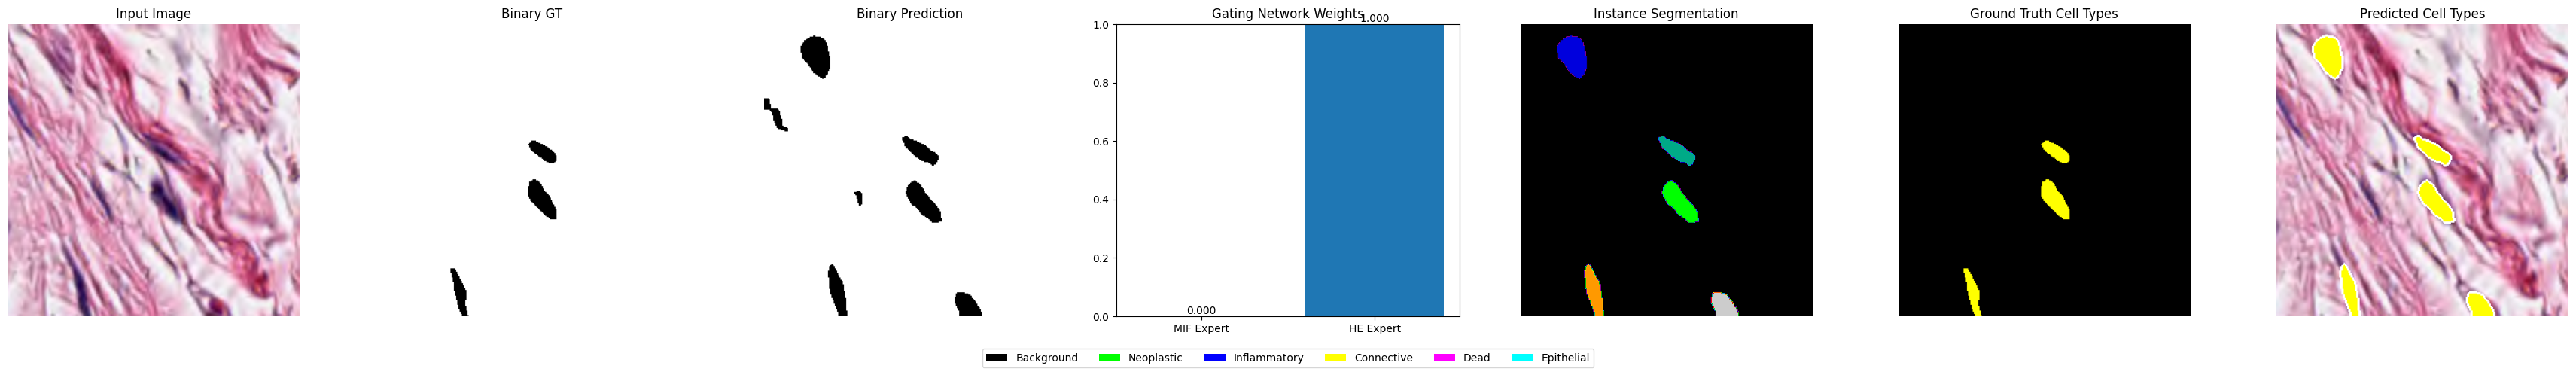


Cell Detection Statistics:
Number of detected cells: 5

Cell type distribution:
Background: 0 cells (0.0%)
Neoplastic: 0 cells (0.0%)
Inflammatory: 0 cells (0.0%)
Connective: 5 cells (100.0%)
Dead: 0 cells (0.0%)
Epithelial: 0 cells (0.0%)

Gating Network Decision:
MIF Expert Weight: 0.000
HE Expert Weight: 1.000


In [30]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries
import matplotlib.colors as mcolors
from cell_segmentation.utils.post_proc_vitaminp import DetectionCellPostProcessor
import random

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


def visualize_gating_decisions(combined_model, sample, device='cuda'):
    """Visualize how gating network routes information with post-processing"""
    combined_model.eval()
    with torch.no_grad():
        # Get the input image and ground truth from sample
        image = sample['image'].unsqueeze(0).to(device) if len(sample['image'].shape) == 3 else sample['image'].to(device)
        
        # Extract ground truth data following the reference implementation
        gt_mask = sample['targets']['masks']['cell'] if 'targets' in sample and 'masks' in sample['targets'] and 'cell' in sample['targets']['masks'] else None
        gt_types = sample['targets']['semantic']['cell_types'] if 'targets' in sample and 'semantic' in sample['targets'] and 'cell_types' in sample['targets']['semantic'] else None
        
        print("\nInput Processing Info:")
        print(f"Original image shape: {image.shape}")
        print(f"Image value range: [{image.min():.3f}, {image.max():.3f}]")
        print(f"Image dtype: {image.dtype}")
        
        # For MIF expert, use only first 2 channels if it's an HE image
        mif_input = image[:, :2] if image.shape[1] == 3 else image
        # For HE expert, pad with zeros if it's a MIF image
        he_input = image if image.shape[1] == 3 else torch.cat([image, torch.zeros_like(image[:, :1])], dim=1)
        
        # Get predictions
        mif_output = combined_model(mif_input, modality='mif')
        he_output = combined_model(he_input, modality='he')
        combined_output = combined_model(image)
        
        # Extract gating weights
        gate_weights = combined_output['gate_weights'][0].cpu().numpy()
        
        # Initialize post-processor
        cell_post_processor = DetectionCellPostProcessor(
            nr_types=6,
            magnification=40
        )
        
        # Process predictions
        if 'cell_hv' in he_output:
            pred_map = np.concatenate([
                torch.argmax(he_output['cell_types'][0], dim=0).cpu().numpy()[..., None],
                torch.argmax(he_output['cell_mask'][0], dim=0).cpu().numpy()[..., None],
                he_output['cell_hv'][0].cpu().numpy().transpose(1, 2, 0)
            ], axis=-1)
        else:
            pred_map = np.concatenate([
                torch.argmax(he_output['cell_types'][0], dim=0).cpu().numpy()[..., None],
                torch.argmax(he_output['cell_mask'][0], dim=0).cpu().numpy()[..., None],
                np.zeros((he_output['cell_types'][0].shape[1], he_output['cell_types'][0].shape[2], 2))
            ], axis=-1)
            
        # Post-process predictions
        instance_map, type_pred = cell_post_processor.post_process_cell_segmentation(pred_map)
        
        # Create visualization
        fig, axes = plt.subplots(1, 7, figsize=(35, 5))
        
        # Define class names and colors
        class_names = {
            0: "Background", 1: "Neoplastic", 2: "Inflammatory",
            3: "Connective", 4: "Dead", 5: "Epithelial"
        }
        type_colors = {
            0: 'black', 1: '#00FF00', 2: 'blue',
            3: 'yellow', 4: 'magenta', 5: 'cyan'
        }
        
        # Original image
        img_display = image[0].cpu().numpy()
        img_display = np.moveaxis(img_display, 0, -1)
        if img_display.shape[-1] == 2:
            img_display = np.concatenate([img_display, np.zeros_like(img_display[:,:,0:1])], axis=-1)
        img_display = np.clip((img_display - img_display.min()) / 
                            (img_display.max() - img_display.min() + 1e-8), 0, 1)
        axes[0].imshow(img_display)
        axes[0].set_title('Input Image')
        axes[0].axis('off')
        
        # Binary Ground Truth
        if 'targets' in sample and 'masks' in sample['targets'] and 'cell' in sample['targets']['masks']:
            binary_gt = sample['targets']['masks']['cell'].squeeze().cpu().numpy()
            if len(binary_gt.shape) == 1:  # If it's 1D, reshape it
                binary_gt = binary_gt.reshape(image.shape[-2:])
            axes[1].imshow(binary_gt > 0, cmap='binary')
            axes[1].set_title('Binary GT')
        else:
            axes[1].text(0.5, 0.5, 'No Ground Truth Available', ha='center', va='center')
            axes[1].set_title('Binary GT')
        axes[1].axis('off')
        
        # Binary Prediction
        binary_pred = torch.softmax(he_output['cell_mask'][0], dim=0)[1].cpu().numpy()
        axes[2].imshow(binary_pred > 0.5, cmap='binary')
        axes[2].set_title('Binary Prediction')
        axes[2].axis('off')
        
        # Gating weights visualization
        bars = axes[3].bar(['MIF Expert', 'HE Expert'], gate_weights)
        axes[3].set_title('Gating Network Weights')
        axes[3].set_ylim(0, 1)
        for idx, rect in enumerate(bars):
            height = rect.get_height()
            axes[3].text(rect.get_x() + rect.get_width()/2., height,
                         f'{gate_weights[idx]:.3f}',
                         ha='center', va='bottom')
        
        # Instance Segmentation
        axes[4].imshow(instance_map, cmap='nipy_spectral')
        axes[4].set_title('Instance Segmentation')
        axes[4].axis('off')
        
        # Ground Truth Cell Types
        if gt_types is not None and gt_mask is not None:
            gt_mask_np = gt_mask.squeeze().cpu().numpy()
            if len(gt_mask_np.shape) == 1:
                gt_mask_np = gt_mask_np.reshape(image.shape[-2:])
            gt_types_np = gt_types.squeeze().cpu().numpy()
            if len(gt_types_np.shape) == 1:
                gt_types_np = gt_types_np.reshape(image.shape[-2:])
                
            gt_type_map = np.zeros_like(gt_mask_np)
            for i in range(1, int(gt_mask_np.max()) + 1):
                mask = gt_mask_np == i
                if mask.any():
                    masked_types = gt_types_np[mask]
                    if len(masked_types) > 0:
                        cell_type = np.argmax(np.bincount(masked_types.astype(int)))
                        gt_type_map[mask] = cell_type
            
            gt_type_rgb = np.zeros((*gt_type_map.shape, 3))
            for type_id in range(len(class_names)):
                color = np.array(mcolors.to_rgb(type_colors[type_id]))
                gt_type_rgb[gt_type_map == type_id] = color
                
            axes[5].imshow(gt_type_rgb)
            axes[5].set_title('Ground Truth Cell Types')
        else:
            axes[5].text(0.5, 0.5, 'No Ground Truth Types Available', ha='center', va='center')
            axes[5].set_title('Ground Truth Cell Types')
        axes[5].axis('off')
        
        # Predicted Cell Types
        pred_type_overlay = img_display.copy()
        type_counts = {i: 0 for i in range(6)}
        
        for cell_id, cell_info in type_pred.items():
            cell_mask = instance_map == cell_id
            cell_type = cell_info['type']
            
            # Filter out cells based on size
            cell_size = np.sum(cell_mask)
            if not (10 <= cell_size <= 10000):
                instance_map[cell_mask] = 0
                continue
                
            pred_type_overlay[cell_mask] = np.array(mcolors.to_rgb(type_colors[cell_type]))
            type_counts[cell_type] += 1
            
        boundaries = find_boundaries(instance_map, mode='thick')
        pred_type_overlay[boundaries] = [1, 1, 1]
        axes[6].imshow(pred_type_overlay)
        axes[6].set_title('Predicted Cell Types')
        axes[6].axis('off')
        
        # Add legend
        legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, edgecolor='none', 
                         label=f"{class_names[i]}") for i, color in type_colors.items()]
        fig.legend(handles=legend_elements, loc='lower center', 
                  ncol=len(class_names), bbox_to_anchor=(0.5, 0))
        
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.15)
        plt.show()
        
        # Print statistics
        print("\nCell Detection Statistics:")
        total_pred_cells = sum(type_counts.values())
        print(f"Number of detected cells: {total_pred_cells}")
        
        print("\nCell type distribution:")
        for type_id, count in type_counts.items():
            percentage = (count / total_pred_cells * 100) if total_pred_cells > 0 else 0
            print(f"{class_names[type_id]}: {count} cells ({percentage:.1f}%)")
        print(f"\nGating Network Decision:")
        print(f"MIF Expert Weight: {gate_weights[0]:.3f}")
        print(f"HE Expert Weight: {gate_weights[1]:.3f}")

# Initialize and load the combined model
combined_model = MultiModalExpertModel().to(device)

# Load checkpoint from the correct path
checkpoint_dir = 'checkpoints_path3'
combined_checkpoint_path = os.path.join(checkpoint_dir, 'final_model.pt')

print(f"\nAttempting to load checkpoint from: {os.path.abspath(combined_checkpoint_path)}")

if os.path.exists(combined_checkpoint_path):
    checkpoint = torch.load(combined_checkpoint_path)
    combined_model.load_state_dict(checkpoint['model_state_dict'])
    combined_model.eval()
    print("Combined model loaded successfully!")
    
    # Get a random test sample
    test_dataset = loaders['he']['test'].dataset
    random_idx = random.randint(0, len(test_dataset) - 1)
    test_sample = test_dataset[random_idx]
    print(f"\nVisualizing gating decisions for random HE test sample (index: {random_idx})...")
    visualize_gating_decisions(combined_model, test_sample, device)
    
else:
    print(f"Error: Checkpoint not found at {combined_checkpoint_path}")

## Gating vs HE experts

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skimage.segmentation import find_boundaries
from cell_segmentation.utils.post_proc_vitaminp import DetectionCellPostProcessor

def compare_gating_vs_direct(combined_model, he_model, test_loader, device='cuda'):
    """
    Compare predictions between gated model and direct HE expert
    """
    # Get a random sample
    random_idx = np.random.randint(0, len(test_loader.dataset))
    print(f"Analyzing random sample {random_idx} out of {len(test_loader.dataset)} samples")
    
    # Get the random sample
    random_sample = test_loader.dataset[random_idx]
    batch = test_loader.collate_fn([random_sample])
    
    # Define class names and colors
    class_names = {
        0: "Background", 1: "Neoplastic", 2: "Inflammatory",
        3: "Connective", 4: "Dead", 5: "Epithelial"
    }
    type_colors = {
        0: 'black', 1: '#00FF00', 2: 'blue',
        3: 'yellow', 4: 'magenta', 5: 'cyan'
    }
    
    # Initialize post-processor
    cell_post_processor = DetectionCellPostProcessor(nr_types=6, magnification=40)
    
    # Get predictions from both models
    combined_model.eval()
    he_model.eval()
    with torch.no_grad():
        images = batch['image'].to(device)
        
        # Get predictions from both models
        gated_output = combined_model(images)
        direct_output = he_model(images)
        
        # Debug output keys
        print("\nGated model output keys:")
        for key in gated_output.keys():
            print(f"- {key}")
            if isinstance(gated_output[key], torch.Tensor):
                print(f"  Shape: {gated_output[key].shape}")
                
        print("\nDirect HE model output keys:")
        for key in direct_output.keys():
            print(f"- {key}")
            if isinstance(direct_output[key], torch.Tensor):
                print(f"  Shape: {direct_output[key].shape}")
        
        # Map gated output keys to standard names
        gated_segmentation = gated_output['segmentation']  # cell mask
        gated_hv = gated_output['hv_maps']  # horizontal/vertical maps
        gated_types = gated_output['cell_types']
        
        # Process gated predictions
        gated_pred_map = np.concatenate([
            torch.argmax(gated_types[0], dim=0).cpu().numpy()[..., None],
            torch.argmax(gated_segmentation[0], dim=0).cpu().numpy()[..., None],
            gated_hv[0].cpu().numpy().transpose(1, 2, 0)
        ], axis=-1)
        
        # Process direct predictions
        direct_pred_map = np.concatenate([
            torch.argmax(direct_output['cell_types'][0], dim=0).cpu().numpy()[..., None],
            torch.argmax(direct_output['cell_mask'][0], dim=0).cpu().numpy()[..., None],
            direct_output['cell_hv'][0].cpu().numpy().transpose(1, 2, 0)
        ], axis=-1)
        
        # Post-process predictions
        gated_instance_map, gated_type_pred = cell_post_processor.post_process_cell_segmentation(gated_pred_map)
        direct_instance_map, direct_type_pred = cell_post_processor.post_process_cell_segmentation(direct_pred_map)
        
        # Create visualization
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        fig.suptitle('Comparison: Gated Model vs Direct HE Expert', fontsize=16)
        
        # Original image
        img_display = images[0].cpu().numpy()
        img_display = np.moveaxis(img_display, 0, -1)
        img_display = np.clip((img_display - img_display.min()) / 
                            (img_display.max() - img_display.min() + 1e-8), 0, 1)
        
        # Row 1: Gated Model Results
        axes[0,0].imshow(img_display)
        axes[0,0].set_title('Original Image')
        axes[0,0].axis('off')
        
        gated_binary = torch.softmax(gated_segmentation[0], dim=0)[1].cpu().numpy()
        axes[0,1].imshow(gated_binary > 0.5, cmap='binary')
        axes[0,1].set_title('Gated Binary Pred')
        axes[0,1].axis('off')
        
        axes[0,2].imshow(gated_instance_map, cmap='nipy_spectral')
        axes[0,2].set_title('Gated Instance Seg')
        axes[0,2].axis('off')
        
        # Gated cell type overlay
        gated_boundaries = find_boundaries(gated_instance_map, mode='thick')
        gated_type_overlay = img_display.copy()
        for cell_id, cell_info in gated_type_pred.items():
            cell_mask = gated_instance_map == cell_id
            cell_type = cell_info['type']
            gated_type_overlay[cell_mask] = np.array(mcolors.to_rgb(type_colors[cell_type]))
        gated_type_overlay[gated_boundaries] = [1, 1, 1]
        axes[0,3].imshow(gated_type_overlay)
        axes[0,3].set_title('Gated Cell Types')
        axes[0,3].axis('off')
        
        # Row 2: Direct HE Expert Results
        axes[1,0].imshow(img_display)
        axes[1,0].set_title('Original Image')
        axes[1,0].axis('off')
        
        direct_binary = torch.softmax(direct_output['cell_mask'][0], dim=0)[1].cpu().numpy()
        axes[1,1].imshow(direct_binary > 0.5, cmap='binary')
        axes[1,1].set_title('Direct Binary Pred')
        axes[1,1].axis('off')
        
        axes[1,2].imshow(direct_instance_map, cmap='nipy_spectral')
        axes[1,2].set_title('Direct Instance Seg')
        axes[1,2].axis('off')
        
        # Direct cell type overlay
        direct_boundaries = find_boundaries(direct_instance_map, mode='thick')
        direct_type_overlay = img_display.copy()
        for cell_id, cell_info in direct_type_pred.items():
            cell_mask = direct_instance_map == cell_id
            cell_type = cell_info['type']
            direct_type_overlay[cell_mask] = np.array(mcolors.to_rgb(type_colors[cell_type]))
        direct_type_overlay[direct_boundaries] = [1, 1, 1]
        axes[1,3].imshow(direct_type_overlay)
        axes[1,3].set_title('Direct Cell Types')
        axes[1,3].axis('off')
        
        # Add legend
        legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, edgecolor='none', 
                         label=class_names[i]) for i, color in type_colors.items()]
        fig.legend(handles=legend_elements, loc='center right', 
                  bbox_to_anchor=(0.98, 0.5))
        
        plt.tight_layout()
        plt.show()
        
        # Print statistics
        print("\nGated Model Statistics:")
        print(f"Number of detected cells: {len(gated_type_pred)}")
        gated_type_counts = {}
        for cell_id, cell_info in gated_type_pred.items():
            cell_type = cell_info['type']
            gated_type_counts[cell_type] = gated_type_counts.get(cell_type, 0) + 1
            
        print("\nGated model cell type distribution:")
        for type_id in class_names.keys():
            count = gated_type_counts.get(type_id, 0)
            percentage = (count / len(gated_type_pred) * 100) if len(gated_type_pred) > 0 else 0
            print(f"{class_names[type_id]}: {count} cells ({percentage:.1f}%)")
            
        print("\nDirect HE Expert Statistics:")
        print(f"Number of detected cells: {len(direct_type_pred)}")
        direct_type_counts = {}
        for cell_id, cell_info in direct_type_pred.items():
            cell_type = cell_info['type']
            direct_type_counts[cell_type] = direct_type_counts.get(cell_type, 0) + 1
            
        print("\nDirect HE expert cell type distribution:")
        for type_id in class_names.keys():
            count = direct_type_counts.get(type_id, 0)
            percentage = (count / len(direct_type_pred) * 100) if len(direct_type_pred) > 0 else 0
            print(f"{class_names[type_id]}: {count} cells ({percentage:.1f}%)")
            
        # Compare raw predictions before post-processing
        print("\nComparing raw predictions:")
        
        # Compare segmentation masks
        gated_seg_probs = torch.softmax(gated_segmentation[0], dim=0)[1]
        direct_seg_probs = torch.softmax(direct_output['cell_mask'][0], dim=0)[1]
        seg_diff = (gated_seg_probs - direct_seg_probs).abs().mean().item()
        print(f"Average segmentation difference: {seg_diff:.4f}")
        
        # Compare cell type predictions
        gated_type_probs = torch.softmax(gated_types[0], dim=0)
        direct_type_probs = torch.softmax(direct_output['cell_types'][0], dim=0)
        type_diff = (gated_type_probs - direct_type_probs).abs().mean().item()
        print(f"Average cell type difference: {type_diff:.4f}")
        
        # Compare HV maps
        hv_diff = (gated_hv[0] - direct_output['cell_hv'][0]).abs().mean().item()
        print(f"Average HV map difference: {hv_diff:.4f}")
        
        # Get max differences for each component
        seg_max_diff = (gated_seg_probs - direct_seg_probs).abs().max().item()
        type_max_diff = (gated_type_probs - direct_type_probs).abs().max().item()
        hv_max_diff = (gated_hv[0] - direct_output['cell_hv'][0]).abs().max().item()
        
        print(f"\nMaximum differences:")
        print(f"Max segmentation difference: {seg_max_diff:.4f}")
        print(f"Max cell type difference: {type_max_diff:.4f}")
        print(f"Max HV map difference: {hv_max_diff:.4f}")
        
        # Add plots to compare probability distributions
        fig_probs, axes_probs = plt.subplots(1, 3, figsize=(15, 5))
        fig_probs.suptitle('Probability Distribution Comparison')
        
        # Segmentation probabilities
        axes_probs[0].hist(gated_seg_probs.cpu().numpy().flatten(), bins=50, alpha=0.5, label='Gated')
        axes_probs[0].hist(direct_seg_probs.cpu().numpy().flatten(), bins=50, alpha=0.5, label='Direct')
        axes_probs[0].set_title('Segmentation Probabilities')
        axes_probs[0].legend()
        
        # Cell type probabilities
        axes_probs[1].hist(gated_type_probs.cpu().numpy().flatten(), bins=50, alpha=0.5, label='Gated')
        axes_probs[1].hist(direct_type_probs.cpu().numpy().flatten(), bins=50, alpha=0.5, label='Direct')
        axes_probs[1].set_title('Cell Type Probabilities')
        axes_probs[1].legend()
        
        # HV map values
        axes_probs[2].hist(gated_hv[0].cpu().numpy().flatten(), bins=50, alpha=0.5, label='Gated')
        axes_probs[2].hist(direct_output['cell_hv'][0].cpu().numpy().flatten(), bins=50, alpha=0.5, label='Direct')
        axes_probs[2].set_title('HV Map Values')
        axes_probs[2].legend()
        
        plt.tight_layout()
        plt.show()

# Usage:
compare_gating_vs_direct(combined_model, he_model, loaders['he']['test'], device)

NameError: name 'he_model' is not defined

In [32]:
def analyze_model_outputs(combined_model, he_model, test_loader, device='cuda'):
    random_idx = np.random.randint(0, len(test_loader.dataset))
    random_sample = test_loader.dataset[random_idx]
    batch = test_loader.collate_fn([random_sample])
    
    combined_model.eval()
    he_model.eval()
    with torch.no_grad():
        images = batch['image'].to(device)
        gated_output = combined_model(images)
        direct_output = he_model(images)
        
        print("\nGate Analysis:")
        gate_weights = gated_output['gate_weights']
        print(f"Gate weights: {gate_weights[0].cpu().numpy()}")

        print("\nPrediction Analysis:")
        gated_types = gated_output['cell_types'][0]
        direct_types = direct_output['cell_types'][0]
        
        print("Gated model ranges:")
        print(f"Min: {gated_types.min().item():.4f}")
        print(f"Max: {gated_types.max().item():.4f}")
        
        print("\nDirect model ranges:")
        print(f"Min: {direct_types.min().item():.4f}")
        print(f"Max: {direct_types.max().item():.4f}")
        
        # Class distribution
        gated_probs = torch.softmax(gated_types, dim=0)
        direct_probs = torch.softmax(direct_types, dim=0)
        
        print("\nClass distributions (mean probabilities):")
        for i in range(6):
            g_mean = gated_probs[i].mean().item()
            d_mean = direct_probs[i].mean().item()
            print(f"Class {i}: Gated={g_mean:.4f}, Direct={d_mean:.4f}")

# Run analysis
analyze_model_outputs(combined_model, he_model, loaders['he']['test'], device)

NameError: name 'he_model' is not defined

In [33]:
def debug_classifications(combined_model, he_model, test_loader, device='cuda'):
    with torch.no_grad():
        # Get same sample as visualization
        random_idx = np.random.randint(0, len(test_loader.dataset))
        random_sample = test_loader.dataset[random_idx]
        batch = test_loader.collate_fn([random_sample])
        images = batch['image'].to(device)
        
        gated_output = combined_model(images)
        direct_output = he_model(images)
        
        # Compare raw predictions
        print("\nRaw prediction comparison:")
        gated_pred_map = np.concatenate([
            torch.argmax(gated_output['cell_types'][0], dim=0).cpu().numpy()[..., None],
            torch.argmax(gated_output['segmentation'][0], dim=0).cpu().numpy()[..., None],
            gated_output['hv_maps'][0].cpu().numpy().transpose(1, 2, 0)
        ], axis=-1)
        
        direct_pred_map = np.concatenate([
            torch.argmax(direct_output['cell_types'][0], dim=0).cpu().numpy()[..., None],
            torch.argmax(direct_output['cell_mask'][0], dim=0).cpu().numpy()[..., None],
            direct_output['cell_hv'][0].cpu().numpy().transpose(1, 2, 0)
        ], axis=-1)
        
        cell_post_processor = DetectionCellPostProcessor(nr_types=6, magnification=40)
        gated_instance_map, gated_type_pred = cell_post_processor.post_process_cell_segmentation(gated_pred_map)
        direct_instance_map, direct_type_pred = cell_post_processor.post_process_cell_segmentation(direct_pred_map)
        
        print("\nCell counts by type:")
        print("Type | Gated | Direct")
        print("-" * 25)
        for i in range(6):
            g_count = sum(1 for c in gated_type_pred.values() if c['type'] == i)
            d_count = sum(1 for c in direct_type_pred.values() if c['type'] == i)
            print(f"{i:4d} | {g_count:6d} | {d_count:6d}")

# Run debug
debug_classifications(combined_model, he_model, loaders['he']['test'], device)

NameError: name 'he_model' is not defined

In [34]:
def debug_segmentation(combined_model, he_model, test_loader, device='cuda'):
   with torch.no_grad():
       random_idx = np.random.randint(0, len(test_loader.dataset))
       sample = test_loader.dataset[random_idx]
       batch = test_loader.collate_fn([sample])
       images = batch['image'].to(device)
       
       gated_output = combined_model(images)
       direct_output = he_model(images)
       
       # Compare segmentation masks
       gated_seg = torch.softmax(gated_output['segmentation'][0], dim=0)[1]
       direct_seg = torch.softmax(direct_output['cell_mask'][0], dim=0)[1]
       
       print("Segmentation stats:")
       print(f"Gated - Mean: {gated_seg.mean():.4f}, Max: {gated_seg.max():.4f}")
       print(f"Direct - Mean: {direct_seg.mean():.4f}, Max: {direct_seg.max():.4f}")

# Run debug        
debug_segmentation(combined_model, he_model, loaders['he']['test'], device)

NameError: name 'he_model' is not defined

In [35]:
def debug_cell_types(combined_model, he_model, test_loader, device='cuda'):
    with torch.no_grad():
        random_idx = np.random.randint(0, len(test_loader.dataset))
        sample = test_loader.dataset[random_idx]
        batch = test_loader.collate_fn([sample])
        images = batch['image'].to(device)
        
        gated_output = combined_model(images)
        direct_output = he_model(images)
        
        # Compare cell type predictions
        gated_types = torch.softmax(gated_output['cell_types'][0], dim=0)
        direct_types = torch.softmax(direct_output['cell_types'][0], dim=0)
        
        print("Cell type confidence stats per class:")
        print("Class | Gated (mean/max) | Direct (mean/max)")
        print("-" * 45)
        for i in range(6):
            g_mean = gated_types[i].mean().item()
            g_max = gated_types[i].max().item()
            d_mean = direct_types[i].mean().item()
            d_max = direct_types[i].max().item()
            print(f"{i:5d} | {g_mean:.4f}/{g_max:.4f} | {d_mean:.4f}/{d_max:.4f}")

debug_cell_types(combined_model, he_model, loaders['he']['test'], device)

NameError: name 'he_model' is not defined

## Gating Check mIF

Using device: cuda

Attempting to load checkpoint from: /rsrch5/home/plm/yshokrollahi/CellViT/notebook/checkpoints_path3/final_model.pt
Combined model loaded successfully!

Visualizing gating decisions for random MIF test sample (index: 1043)...

Input Processing Info:
Original image shape: torch.Size([1, 2, 256, 256])
Image value range: [-1.000, 1.000]
Image dtype: torch.float32


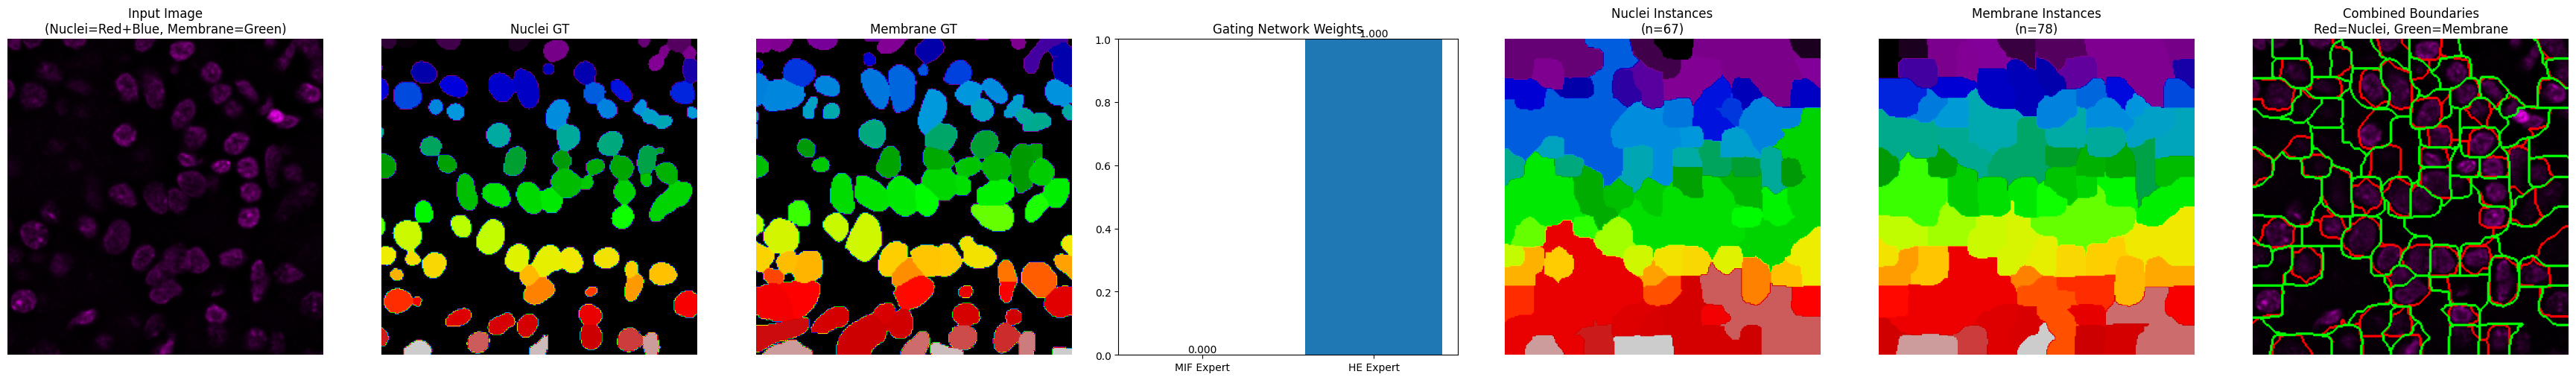


Prediction Statistics:
Number of detected nuclei: 67
Number of detected membranes: 78

Gating Network Decision:
MIF Expert Weight: 0.000
HE Expert Weight: 1.000


In [38]:
def visualize_gating_decisions_mif(combined_model, sample, device='cuda'):
    """Visualize how gating network routes information with post-processing for MIF images"""
    combined_model.eval()
    with torch.no_grad():
        # Get the input image
        image = sample['image'].unsqueeze(0).to(device) if len(sample['image'].shape) == 3 else sample['image'].to(device)
        
        print("\nInput Processing Info:")
        print(f"Original image shape: {image.shape}")
        print(f"Image value range: [{image.min():.3f}, {image.max():.3f}]")
        print(f"Image dtype: {image.dtype}")
        
        # For MIF expert, use the first 2 channels
        mif_input = image[:, :2] if image.shape[1] > 2 else image
        # For HE expert, pad with zeros if it's a MIF image
        he_input = torch.cat([image, torch.zeros_like(image[:, :1])], dim=1) if image.shape[1] == 2 else image
        
        # Get predictions with each expert separately and combined
        mif_output = combined_model(mif_input, modality='mif')
        he_output = combined_model(he_input, modality='he')
        combined_output = combined_model(image)
        
        # Extract gating weights
        gate_weights = combined_output['gate_weights'][0].cpu().numpy()
        
        # Initialize post-processors for nuclei and membrane
        nuclei_processor = DetectionCellPostProcessor(nr_types=1, magnification=40, gt=False)
        membrane_processor = DetectionCellPostProcessor(nr_types=1, magnification=40, gt=False)
        
        # Process nuclei predictions
        nuclei_seg = torch.sigmoid(mif_output['nuclei_mask'][0, 1]).cpu().numpy() > 0.1
        nuclei_hv = mif_output['nuclei_hv'][0].cpu().numpy()
        nuclei_map = np.concatenate([
            np.zeros((256, 256, 1)),
            nuclei_seg[..., None],
            nuclei_hv.transpose(1, 2, 0)
        ], axis=-1)
        
        # Process membrane predictions
        membrane_seg = torch.sigmoid(mif_output['membrane_mask'][0, 1]).cpu().numpy() > 0.3
        membrane_hv = mif_output['membrane_hv'][0].cpu().numpy()
        membrane_map = np.concatenate([
            np.zeros((256, 256, 1)),
            membrane_seg[..., None],
            membrane_hv.transpose(1, 2, 0)
        ], axis=-1)
        
        # Post-process predictions
        nuclei_instance_map, nuclei_info = nuclei_processor.post_process_cell_segmentation(nuclei_map)
        membrane_instance_map, membrane_info = membrane_processor.post_process_cell_segmentation(membrane_map)
        
        # Create visualization
        fig, axes = plt.subplots(1, 7, figsize=(35, 5))
        
        # Original image display
        img_display = image[0].cpu().numpy()
        img_display = np.moveaxis(img_display, 0, -1)
        rgb_display = np.stack([
            img_display[..., 0],  # Nuclei channel
            img_display[..., 1],  # Membrane channel
            img_display[..., 0]   # Nuclei channel again for blue
        ], axis=-1)
        rgb_display = np.clip((rgb_display - rgb_display.min()) / 
                            (rgb_display.max() - rgb_display.min() + 1e-8), 0, 1)
        
        axes[0].imshow(rgb_display)
        axes[0].set_title('Input Image\n(Nuclei=Red+Blue, Membrane=Green)')
        axes[0].axis('off')
        
        # Ground Truth Nuclei
        if 'targets' in sample and 'masks' in sample['targets'] and 'nuclei' in sample['targets']['masks']:
            gt_nuclei = sample['targets']['masks']['nuclei'].squeeze().cpu().numpy()
            if len(gt_nuclei.shape) == 1:
                gt_nuclei = gt_nuclei.reshape(image.shape[-2:])
            axes[1].imshow(gt_nuclei, cmap='nipy_spectral')
            axes[1].set_title('Nuclei GT')
        else:
            axes[1].text(0.5, 0.5, 'No Nuclei GT Available', ha='center', va='center')
            axes[1].set_title('Nuclei GT')
        axes[1].axis('off')
        
        # Ground Truth Membrane
        if 'targets' in sample and 'masks' in sample['targets'] and 'membrane' in sample['targets']['masks']:
            gt_membrane = sample['targets']['masks']['membrane'].squeeze().cpu().numpy()
            if len(gt_membrane.shape) == 1:
                gt_membrane = gt_membrane.reshape(image.shape[-2:])
            axes[2].imshow(gt_membrane, cmap='nipy_spectral')
            axes[2].set_title('Membrane GT')
        else:
            axes[2].text(0.5, 0.5, 'No Membrane GT Available', ha='center', va='center')
            axes[2].set_title('Membrane GT')
        axes[2].axis('off')
        
        # Gating weights visualization
        bars = axes[3].bar(['MIF Expert', 'HE Expert'], gate_weights)
        axes[3].set_title('Gating Network Weights')
        axes[3].set_ylim(0, 1)
        for idx, rect in enumerate(bars):
            height = rect.get_height()
            axes[3].text(rect.get_x() + rect.get_width()/2., height,
                         f'{gate_weights[idx]:.3f}',
                         ha='center', va='bottom')
        
        # Predicted Instance Maps
        axes[4].imshow(nuclei_instance_map, cmap='nipy_spectral')
        axes[4].set_title(f'Nuclei Instances\n(n={len(nuclei_info)})')
        axes[4].axis('off')
        
        axes[5].imshow(membrane_instance_map, cmap='nipy_spectral')
        axes[5].set_title(f'Membrane Instances\n(n={len(membrane_info)})')
        axes[5].axis('off')
        
        # Combined Overlay
        combined_overlay = rgb_display.copy()
        nuclei_boundaries = find_boundaries(nuclei_instance_map, mode='thick')
        membrane_boundaries = find_boundaries(membrane_instance_map, mode='thick')
        combined_overlay[nuclei_boundaries] = [1, 0, 0]    # Red for nuclei
        combined_overlay[membrane_boundaries] = [0, 1, 0]  # Green for membrane
        axes[6].imshow(combined_overlay)
        axes[6].set_title('Combined Boundaries\nRed=Nuclei, Green=Membrane')
        axes[6].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Print statistics
        print("\nPrediction Statistics:")
        print(f"Number of detected nuclei: {len(nuclei_info)}")
        print(f"Number of detected membranes: {len(membrane_info)}")
        print(f"\nGating Network Decision:")
        print(f"MIF Expert Weight: {gate_weights[0]:.3f}")
        print(f"HE Expert Weight: {gate_weights[1]:.3f}")
        
        return nuclei_instance_map, membrane_instance_map

# Usage:
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Initialize and load the combined model
    combined_model = MultiModalExpertModel().to(device)
    
    # Load checkpoint
    checkpoint_dir = 'checkpoints_path3'
    combined_checkpoint_path = os.path.join(checkpoint_dir, 'final_model.pt')
    
    print(f"\nAttempting to load checkpoint from: {os.path.abspath(combined_checkpoint_path)}")
    
    if os.path.exists(combined_checkpoint_path):
        checkpoint = torch.load(combined_checkpoint_path)
        combined_model.load_state_dict(checkpoint['model_state_dict'])
        combined_model.eval()
        print("Combined model loaded successfully!")
        
        # Get a random test sample
        test_dataset = loaders['mif']['test'].dataset
        random_idx = random.randint(0, len(test_dataset) - 1)
        test_sample = test_dataset[random_idx]
        print(f"\nVisualizing gating decisions for random MIF test sample (index: {random_idx})...")
        nuclei_map, membrane_map = visualize_gating_decisions_mif(combined_model, test_sample, device)
        
    else:
        print(f"Error: Checkpoint not found at {combined_checkpoint_path}")

## Gating vs mIF experts

Using device: cuda

Attempting to load checkpoint...
Combined model loaded successfully!
Analyzing random sample 776 out of 1324 samples

Gated model output keys:
- nuclei_mask
  Shape: torch.Size([1, 2, 256, 256])
- membrane_mask
  Shape: torch.Size([1, 2, 256, 256])
- nuclei_hv
  Shape: torch.Size([1, 2, 256, 256])
- membrane_hv
  Shape: torch.Size([1, 2, 256, 256])
- gate_weights
  Shape: torch.Size([1, 2])

Direct MIF model output keys:
- nuclei_mask
  Shape: torch.Size([1, 2, 256, 256])
- membrane_mask
  Shape: torch.Size([1, 2, 256, 256])
- nuclei_hv
  Shape: torch.Size([1, 2, 256, 256])
- membrane_hv
  Shape: torch.Size([1, 2, 256, 256])
- gate_weights
  Shape: torch.Size([1, 1024, 8, 8])

Gating weights used:
tensor([[2.0191e-06, 1.0000e+00]], device='cuda:0')


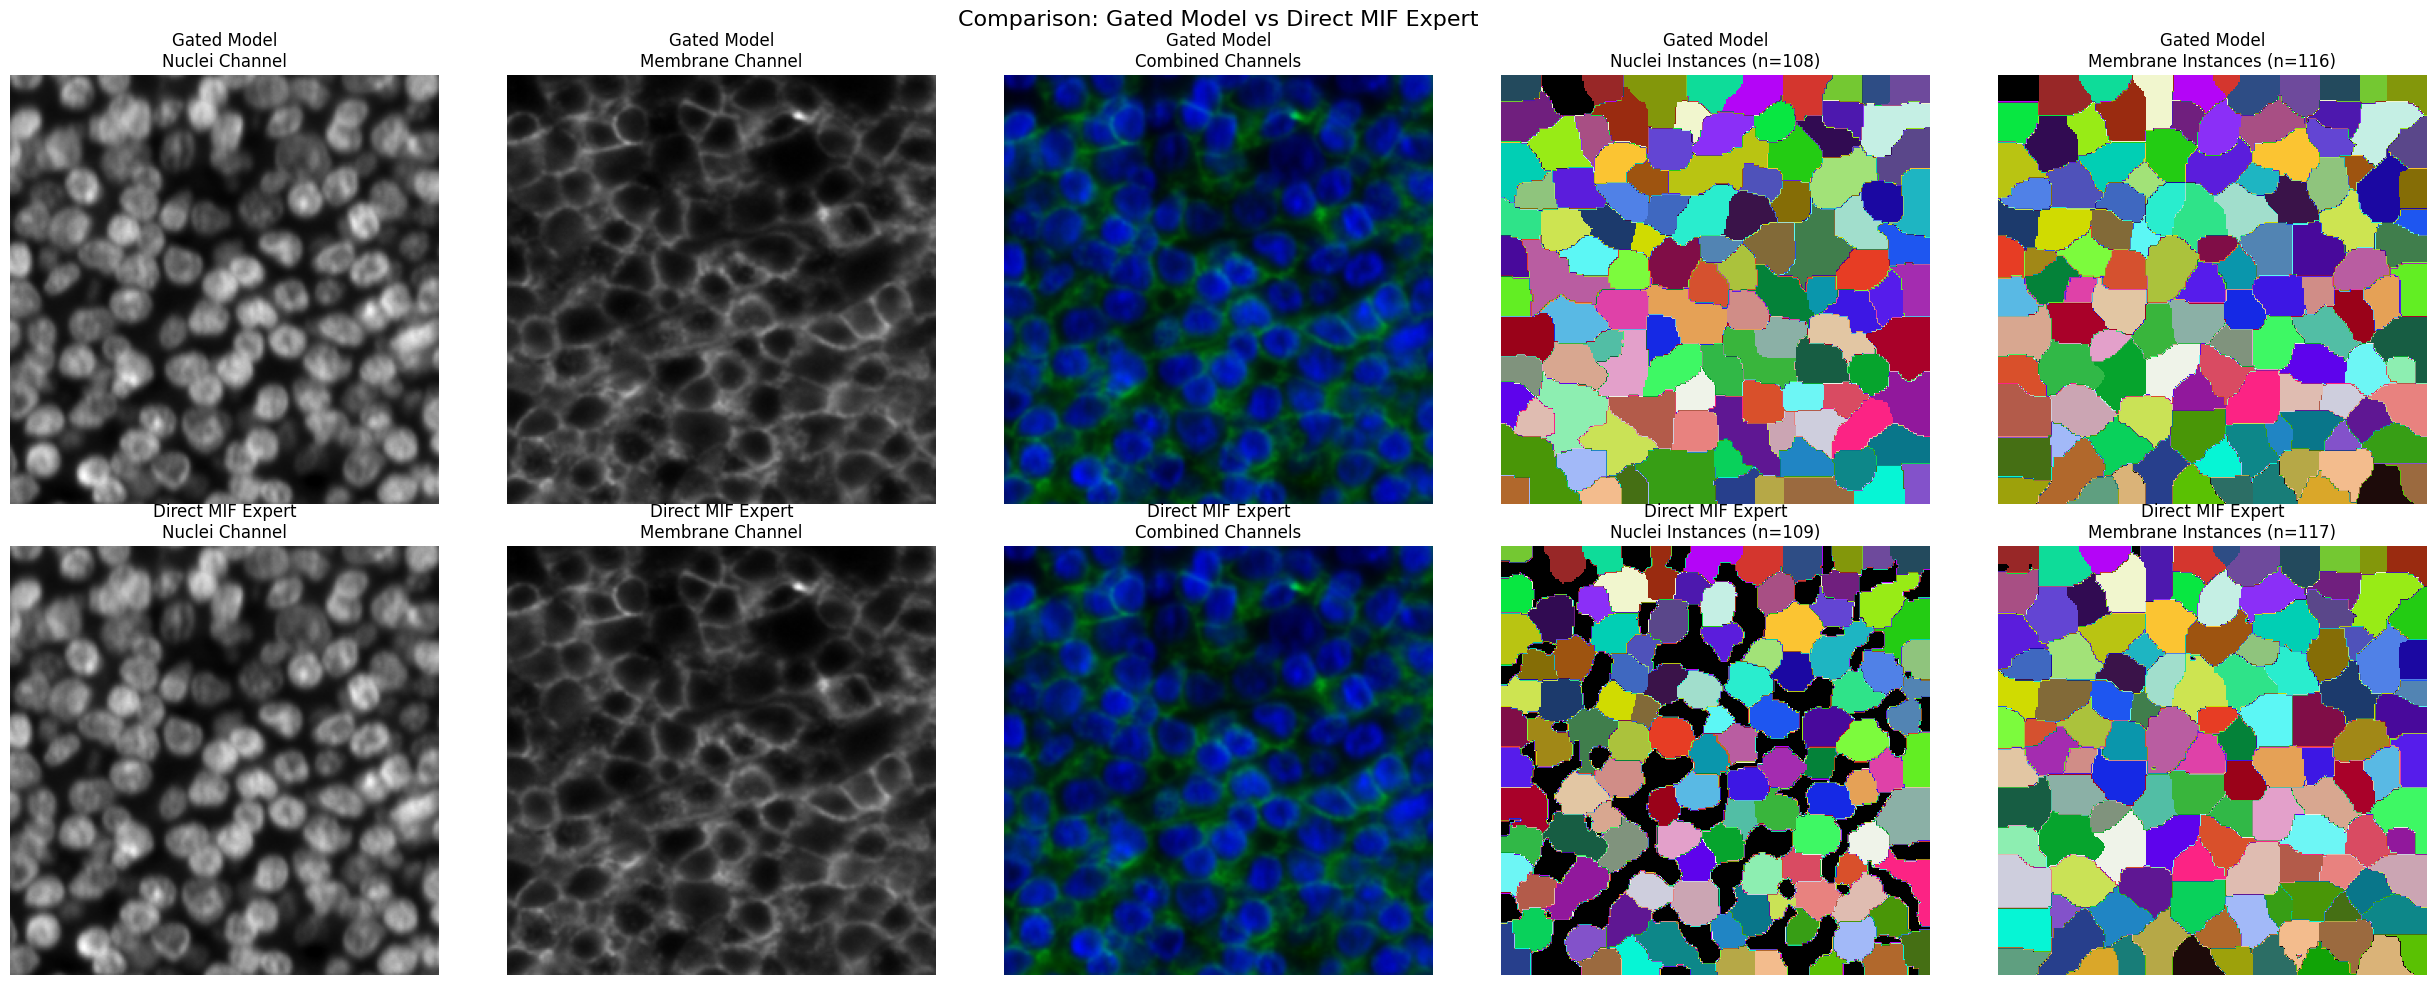


Gated Model Statistics:
Number of detected nuclei: 108
Number of detected membranes: 116

Direct MIF Expert Statistics:
Number of detected nuclei: 109
Number of detected membranes: 117

Comparing raw predictions:
Average nuclei probability difference: 0.4583
Average membrane probability difference: 0.4963
Average nuclei HV map difference: 0.2761
Average membrane HV map difference: 0.3347


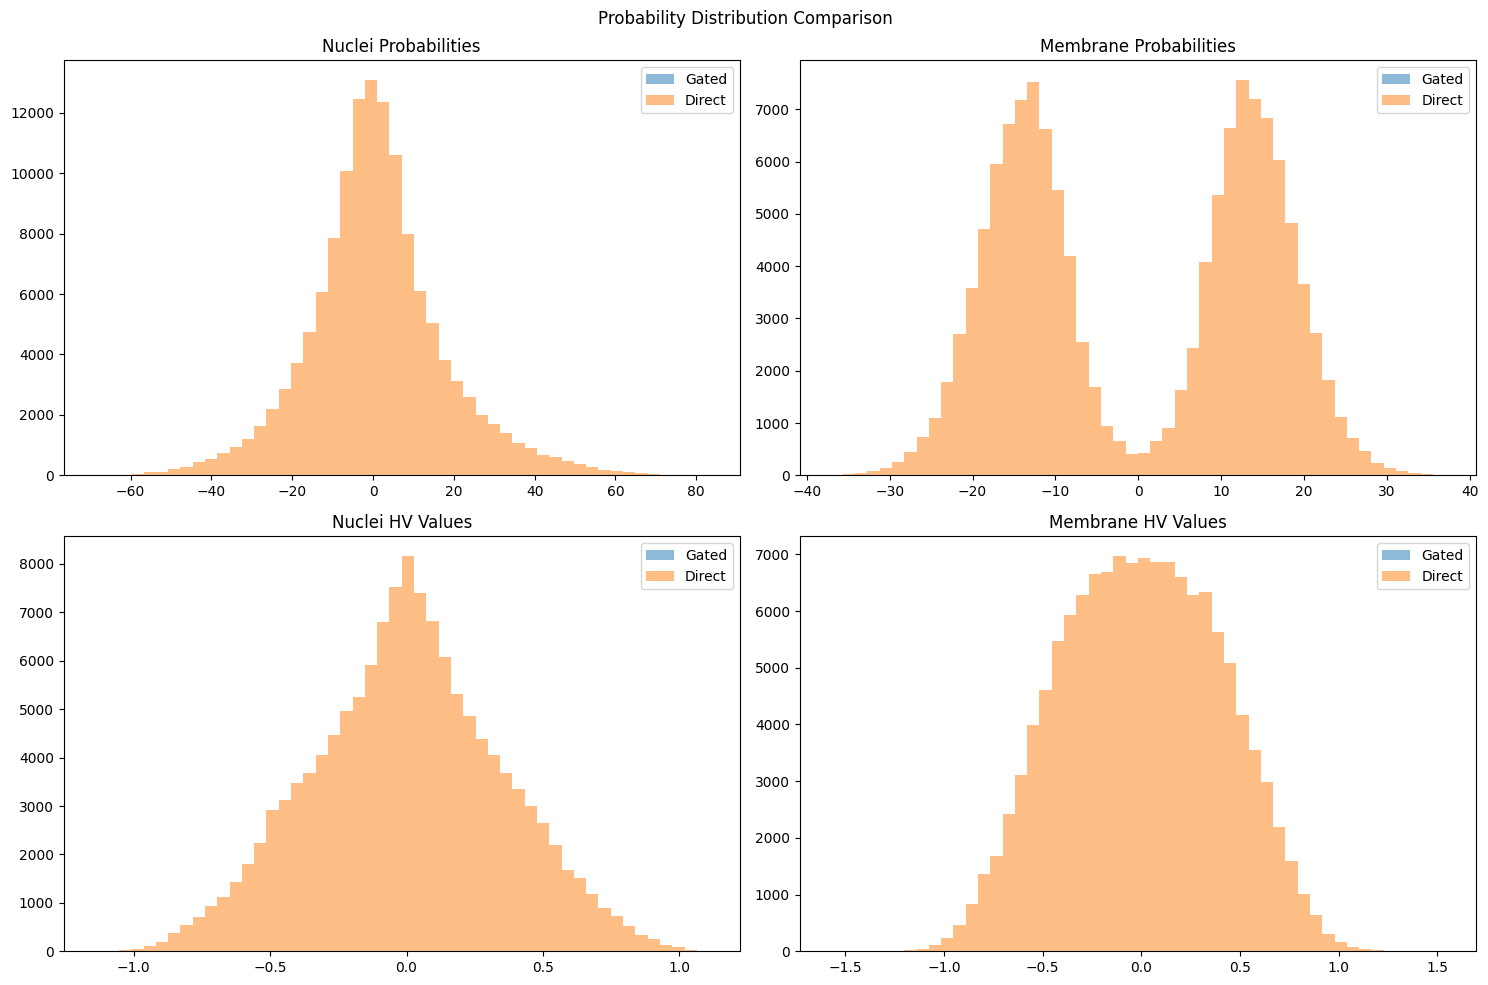

In [39]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.segmentation import find_boundaries
from cell_segmentation.utils.post_proc_vitaminp import DetectionCellPostProcessor

def compare_gating_vs_direct_mif(combined_model, test_loader, device='cuda'):
    """
    Compare predictions between gated model and direct MIF expert with improved separation
    """
    # Create a separate instance of MIF expert instead of using a reference
    mif_model = type(combined_model.mif_expert)().to(device)  # Create new instance
    mif_model.load_state_dict(combined_model.mif_expert.state_dict())  # Copy weights
    
    random_idx = np.random.randint(0, len(test_loader.dataset))
    print(f"Analyzing random sample {random_idx} out of {len(test_loader.dataset)} samples")
    
    random_sample = test_loader.dataset[random_idx]
    batch = test_loader.collate_fn([random_sample])
    
    nuclei_processor = DetectionCellPostProcessor(nr_types=1, magnification=40, gt=False)
    membrane_processor = DetectionCellPostProcessor(nr_types=1, magnification=40, gt=False)
    
    combined_model.eval()
    mif_model.eval()
    with torch.no_grad():
        images = batch['image'].to(device)
        
        # Debug output keys first
        print("\nGated model output keys:")
        gated_output = combined_model(images, modality='mif')
        for key in gated_output.keys():
            print(f"- {key}")
            if isinstance(gated_output[key], torch.Tensor):
                print(f"  Shape: {gated_output[key].shape}")
        
        print("\nDirect MIF model output keys:")
        direct_output = mif_model(images)
        for key in direct_output.keys():
            print(f"- {key}")
            if isinstance(direct_output[key], torch.Tensor):
                print(f"  Shape: {direct_output[key].shape}")
                
        # Print gating weights if available
        if hasattr(combined_model, 'last_gating_weights'):
            print("\nGating weights used:")
            print(combined_model.last_gating_weights)
        
        # Process predictions with raw probabilities for comparison
        gated_nuclei_probs = torch.sigmoid(gated_output['nuclei_mask'][0, 1])
        gated_membrane_probs = torch.sigmoid(gated_output['membrane_mask'][0, 1])
        direct_nuclei_probs = torch.sigmoid(direct_output['nuclei_mask'][0, 1])
        direct_membrane_probs = torch.sigmoid(direct_output['membrane_mask'][0, 1])
        
        # Convert to binary masks for instance segmentation
        gated_nuclei_seg = (gated_nuclei_probs > 0.1).cpu().numpy()
        gated_membrane_seg = (gated_membrane_probs > 0.3).cpu().numpy()
        direct_nuclei_seg = (direct_nuclei_probs > 0.1).cpu().numpy()
        direct_membrane_seg = (direct_membrane_probs > 0.3).cpu().numpy()
        
        # Get HV maps
        gated_nuclei_hv = gated_output['nuclei_hv'][0].cpu().numpy()
        gated_membrane_hv = gated_output['membrane_hv'][0].cpu().numpy()
        direct_nuclei_hv = direct_output['nuclei_hv'][0].cpu().numpy()
        direct_membrane_hv = direct_output['membrane_hv'][0].cpu().numpy()
        
        # Create instance maps
        gated_nuclei_map = np.concatenate([
            np.zeros((256, 256, 1)),
            gated_nuclei_seg[..., None],
            gated_nuclei_hv.transpose(1, 2, 0)
        ], axis=-1)
        
        gated_membrane_map = np.concatenate([
            np.zeros((256, 256, 1)),
            gated_membrane_seg[..., None],
            gated_membrane_hv.transpose(1, 2, 0)
        ], axis=-1)
        
        direct_nuclei_map = np.concatenate([
            np.zeros((256, 256, 1)),
            direct_nuclei_seg[..., None],
            direct_nuclei_hv.transpose(1, 2, 0)
        ], axis=-1)
        
        direct_membrane_map = np.concatenate([
            np.zeros((256, 256, 1)),
            direct_membrane_seg[..., None],
            direct_membrane_hv.transpose(1, 2, 0)
        ], axis=-1)
        
        # Get instance maps and info
        gated_nuclei_instances, gated_nuclei_info = nuclei_processor.post_process_cell_segmentation(gated_nuclei_map)
        gated_membrane_instances, gated_membrane_info = membrane_processor.post_process_cell_segmentation(gated_membrane_map)
        direct_nuclei_instances, direct_nuclei_info = nuclei_processor.post_process_cell_segmentation(direct_nuclei_map)
        direct_membrane_instances, direct_membrane_info = membrane_processor.post_process_cell_segmentation(direct_membrane_map)
        
        # Create visualization
        fig, axes = plt.subplots(2, 5, figsize=(25, 10))
        fig.suptitle('Comparison: Gated Model vs Direct MIF Expert', fontsize=16)
        
        # Display original images
        img_display = images[0].cpu().numpy()
        img_ch1 = normalize_image(img_display[0])
        img_ch2 = normalize_image(img_display[1])
        
        # Create combined image
        combined_img = np.dstack([
            np.zeros_like(img_ch1),
            img_ch2 * 0.8,
            img_ch1
        ])
        
        # Row 1: Gated Model Results
        display_row(axes[0], img_ch1, img_ch2, combined_img, 
                   gated_nuclei_instances, gated_membrane_instances,
                   "Gated Model")
        
        # Row 2: Direct MIF Expert Results
        display_row(axes[1], img_ch1, img_ch2, combined_img,
                   direct_nuclei_instances, direct_membrane_instances,
                   "Direct MIF Expert")
        
        plt.tight_layout()
        plt.show()
        
        # Print statistics and comparisons
        print_statistics(gated_nuclei_info, gated_membrane_info,
                        direct_nuclei_info, direct_membrane_info)
        
        # Compare raw predictions
        compare_raw_predictions(gated_output, direct_output)
        
        # Plot probability distributions
        plot_probability_distributions(gated_output, direct_output)

def normalize_image(img):
    """Normalize image to 0-1 range"""
    if img.max() > 1:
        img = img / img.max()
    return np.clip((img - img.min()) / (img.max() - img.min() + 1e-8), 0, 1)

def create_random_colormap(n_instances):
    """Create random colormap for instance visualization"""
    np.random.seed(42)
    colors = np.random.rand(n_instances + 1, 3)
    colors[0] = [0, 0, 0]
    return ListedColormap(colors)

def display_row(axes, img_ch1, img_ch2, combined_img, nuclei_instances, membrane_instances, title_prefix):
    """Display one row of visualizations"""
    axes[0].imshow(img_ch1, cmap='gray')
    axes[0].set_title(f'{title_prefix}\nNuclei Channel')
    axes[0].axis('off')
    
    axes[1].imshow(img_ch2, cmap='gray')
    axes[1].set_title(f'{title_prefix}\nMembrane Channel')
    axes[1].axis('off')
    
    axes[2].imshow(combined_img)
    axes[2].set_title(f'{title_prefix}\nCombined Channels')
    axes[2].axis('off')
    
    # Instance maps
    n_nuclei = len(np.unique(nuclei_instances))
    n_membrane = len(np.unique(membrane_instances))
    
    axes[3].imshow(nuclei_instances, cmap=create_random_colormap(n_nuclei))
    axes[3].set_title(f'{title_prefix}\nNuclei Instances (n={n_nuclei-1})')
    axes[3].axis('off')
    
    axes[4].imshow(membrane_instances, cmap=create_random_colormap(n_membrane))
    axes[4].set_title(f'{title_prefix}\nMembrane Instances (n={n_membrane-1})')
    axes[4].axis('off')

def print_statistics(gated_nuclei_info, gated_membrane_info, direct_nuclei_info, direct_membrane_info):
    """Print detection statistics"""
    print("\nGated Model Statistics:")
    print(f"Number of detected nuclei: {len(gated_nuclei_info)}")
    print(f"Number of detected membranes: {len(gated_membrane_info)}")
    
    print("\nDirect MIF Expert Statistics:")
    print(f"Number of detected nuclei: {len(direct_nuclei_info)}")
    print(f"Number of detected membranes: {len(direct_membrane_info)}")

def compare_raw_predictions(gated_output, direct_output):
    """Compare raw model predictions"""
    print("\nComparing raw predictions:")
    
    # Get raw probabilities
    gated_nuclei_probs = torch.sigmoid(gated_output['nuclei_mask'][0, 1])
    gated_membrane_probs = torch.sigmoid(gated_output['membrane_mask'][0, 1])
    direct_nuclei_probs = torch.sigmoid(direct_output['nuclei_mask'][0, 1])
    direct_membrane_probs = torch.sigmoid(direct_output['membrane_mask'][0, 1])
    
    # Calculate differences
    nuclei_prob_diff = (gated_nuclei_probs - direct_nuclei_probs).abs().mean().item()
    membrane_prob_diff = (gated_membrane_probs - direct_membrane_probs).abs().mean().item()
    nuclei_hv_diff = (gated_output['nuclei_hv'] - direct_output['nuclei_hv']).abs().mean().item()
    membrane_hv_diff = (gated_output['membrane_hv'] - direct_output['membrane_hv']).abs().mean().item()
    
    print(f"Average nuclei probability difference: {nuclei_prob_diff:.4f}")
    print(f"Average membrane probability difference: {membrane_prob_diff:.4f}")
    print(f"Average nuclei HV map difference: {nuclei_hv_diff:.4f}")
    print(f"Average membrane HV map difference: {membrane_hv_diff:.4f}")

def plot_probability_distributions(gated_output, direct_output):
    """Plot probability distributions for comparison"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Probability Distribution Comparison')
    
    # Nuclei probabilities
    plot_hist(axes[0,0], gated_output['nuclei_mask'], direct_output['nuclei_mask'],
             'Nuclei Probabilities')
    
    # Membrane probabilities
    plot_hist(axes[0,1], gated_output['membrane_mask'], direct_output['membrane_mask'],
             'Membrane Probabilities')
    
    # HV maps
    plot_hist(axes[1,0], gated_output['nuclei_hv'], direct_output['nuclei_hv'],
             'Nuclei HV Values')
    plot_hist(axes[1,1], gated_output['membrane_hv'], direct_output['membrane_hv'],
             'Membrane HV Values')
    
    plt.tight_layout()
    plt.show()

def plot_hist(ax, gated_data, direct_data, title):
    """Helper function to plot histograms"""
    gated_vals = gated_data.cpu().numpy().flatten()
    direct_vals = direct_data.cpu().numpy().flatten()
    
    ax.hist(gated_vals, bins=50, alpha=0.5, label='Gated')
    ax.hist(direct_vals, bins=50, alpha=0.5, label='Direct')
    ax.set_title(title)
    ax.legend()

# Usage
if __name__ == "__main__":
    # Initialize device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Initialize and load combined model
    combined_model = MultiModalExpertModel().to(device)
    checkpoint_dir = 'checkpoints_path3'
    combined_checkpoint_path = os.path.join(checkpoint_dir, 'final_model.pt')
    
    print("\nAttempting to load checkpoint...")
    if os.path.exists(combined_checkpoint_path):
        checkpoint = torch.load(combined_checkpoint_path)
        combined_model.load_state_dict(checkpoint['model_state_dict'])
        combined_model.eval()
        print("Combined model loaded successfully!")
        
        # Run comparison
        compare_gating_vs_direct_mif(combined_model, loaders['mif']['test'], device)
    else:
        print(f"Error: Combined model checkpoint not found at {combined_checkpoint_path}")

## Compare metrics

Using device: cuda
Combined model loaded successfully!
Analyzing random sample 456 out of 1324 samples

Batch keys: dict_keys(['image', 'targets', 'metadata'])
Targets keys: dict_keys(['masks', 'semantic', 'hv_maps'])
Masks keys: dict_keys(['nuclei', 'membrane', 'cell'])

Ground Truth Status:
Nuclei GT available: True
Membrane GT available: True

Detection Statistics:

Gated Model Statistics:
Number of detected nuclei: 46
Number of detected membranes: 52

Direct Model Statistics:
Number of detected nuclei: 47
Number of detected membranes: 53

Nuclei Detection Metrics:

Gated Model Nuclei Metrics:
Precision: 0.8511
Recall: 0.5970
F1 Score: 0.7018
TP: 40, FP: 7, FN: 27

Direct Model Nuclei Metrics:
Precision: 0.9574
Recall: 0.6716
F1 Score: 0.7895
TP: 45, FP: 2, FN: 22

Membrane Detection Metrics:

Gated Model Membrane Metrics:
Precision: 0.7358
Recall: 0.5909
F1 Score: 0.6555
TP: 39, FP: 14, FN: 27

Direct Model Membrane Metrics:
Precision: 0.8302
Recall: 0.6667
F1 Score: 0.7395
TP: 44,

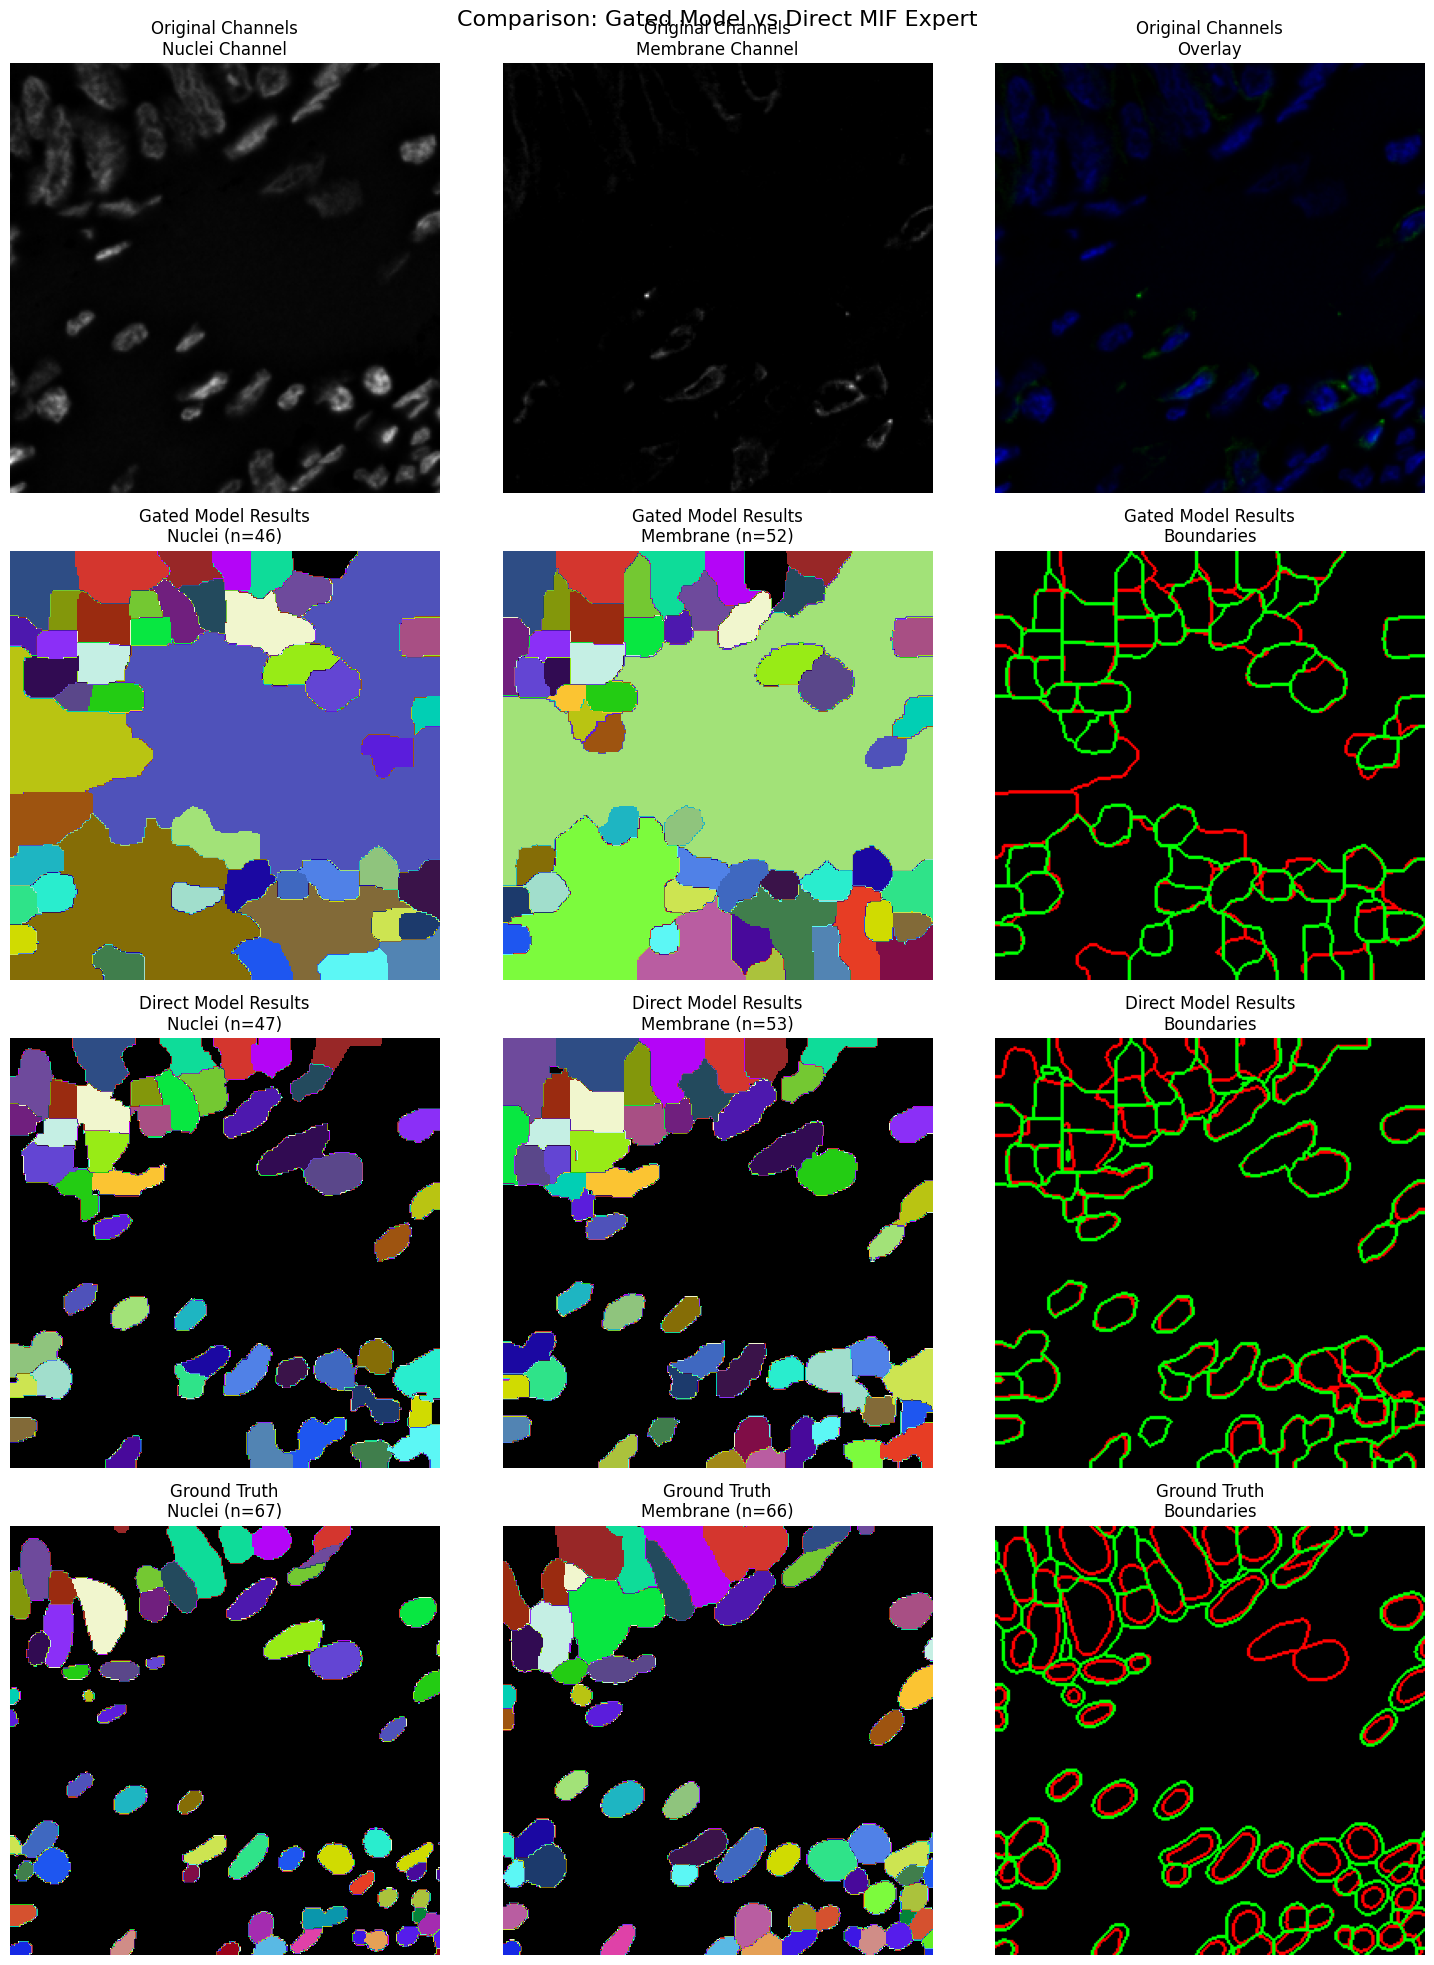

In [122]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.segmentation import find_boundaries
from cell_segmentation.utils.post_proc_vitaminp import DetectionCellPostProcessor
from scipy.ndimage import center_of_mass
from scipy.spatial.distance import cdist

def get_instance_centroids(instance_map):
    """Calculate centroids for all instances in the instance map."""
    centroids = {}
    for instance_id in np.unique(instance_map):
        if instance_id == 0:  # Skip background
            continue
        mask = instance_map == instance_id
        center = center_of_mass(mask)
        centroids[instance_id] = center
    return centroids

def match_instances(pred_centroids, gt_centroids, distance_threshold=12):
    """Match predicted and ground truth instances based on centroid distance."""
    if not pred_centroids or not gt_centroids:
        return [], list(pred_centroids.keys()), list(gt_centroids.keys())
    
    pred_coords = np.array(list(pred_centroids.values()))
    gt_coords = np.array(list(gt_centroids.values()))
    pred_ids = list(pred_centroids.keys())
    gt_ids = list(gt_centroids.keys())
    
    distances = cdist(pred_coords, gt_coords)
    
    matched_pairs = []
    used_pred = set()
    used_gt = set()
    
    while True:
        if distances.size == 0 or distances.min() > distance_threshold:
            break
            
        pred_idx, gt_idx = np.unravel_index(distances.argmin(), distances.shape)
        if pred_idx not in used_pred and gt_idx not in used_gt:
            matched_pairs.append((pred_ids[pred_idx], gt_ids[gt_idx]))
            used_pred.add(pred_idx)
            used_gt.add(gt_idx)
            
        distances[pred_idx, :] = float('inf')
        distances[:, gt_idx] = float('inf')
    
    unmatched_pred = [pid for i, pid in enumerate(pred_ids) if i not in used_pred]
    unmatched_gt = [gid for i, gid in enumerate(gt_ids) if i not in used_gt]
    
    return matched_pairs, unmatched_pred, unmatched_gt

def calculate_metrics(pred_inst, gt_inst):
    """Calculate detection metrics between predicted and ground truth instances."""
    pred_centroids = get_instance_centroids(pred_inst)
    gt_centroids = get_instance_centroids(gt_inst)
    matched_pairs, unmatched_pred, unmatched_gt = match_instances(pred_centroids, gt_centroids)
    
    tp = len(matched_pairs)
    fp = len(unmatched_pred)
    fn = len(unmatched_gt)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'centroids': (pred_centroids, gt_centroids, matched_pairs)
    }

def compare_gating_vs_direct_mif(combined_model, test_loader, device='cuda'):
    """Compare predictions between gated model and direct MIF expert with metrics."""
    # Create a separate instance of MIF expert
    mif_model = type(combined_model.mif_expert)().to(device)
    mif_model.load_state_dict(combined_model.mif_expert.state_dict())
    
    random_idx = np.random.randint(0, len(test_loader.dataset))
    print(f"Analyzing random sample {random_idx} out of {len(test_loader.dataset)} samples")
    
    random_sample = test_loader.dataset[random_idx]
    batch = test_loader.collate_fn([random_sample])
    
    nuclei_processor = DetectionCellPostProcessor(nr_types=1, magnification=40, gt=False)
    membrane_processor = DetectionCellPostProcessor(nr_types=1, magnification=40, gt=False)
    
    combined_model.eval()
    mif_model.eval()
    with torch.no_grad():
        images = batch['image'].to(device)
        
        # Extract ground truth from batch using the correct structure
        gt_nuclei = None
        gt_membrane = None
        
        # Handle nested structure for targets
        if 'targets' in batch and isinstance(batch['targets'], dict):
            if 'masks' in batch['targets']:
                masks = batch['targets']['masks']
                gt_nuclei = masks.get('nuclei', None)
                gt_membrane = masks.get('membrane', None)  # or 'cell' for PanNuke
        
        print("\nBatch keys:", batch.keys())
        if 'targets' in batch:
            print("Targets keys:", batch['targets'].keys())
            if 'masks' in batch['targets']:
                print("Masks keys:", batch['targets']['masks'].keys())
        
        if gt_nuclei is not None:
            gt_nuclei = gt_nuclei.to(device)
        if gt_membrane is not None:
            gt_membrane = gt_membrane.to(device)
            
        print("\nGround Truth Status:")
        print(f"Nuclei GT available: {gt_nuclei is not None}")
        print(f"Membrane GT available: {gt_membrane is not None}")
        
        # Get predictions from both models
        gated_output = combined_model(images, modality='mif')
        direct_output = mif_model(images)
        
        # Process predictions for both models
        gated_nuclei_probs = torch.sigmoid(gated_output['nuclei_mask'][0, 1])
        gated_membrane_probs = torch.sigmoid(gated_output['membrane_mask'][0, 1])
        direct_nuclei_probs = torch.sigmoid(direct_output['nuclei_mask'][0, 1])
        direct_membrane_probs = torch.sigmoid(direct_output['membrane_mask'][0, 1])
        
        # Convert to binary masks and get instance maps
        gated_nuclei_instances, gated_nuclei_info = get_instance_maps(
            gated_nuclei_probs, gated_output['nuclei_hv'][0], nuclei_processor)
        gated_membrane_instances, gated_membrane_info = get_instance_maps(
            gated_membrane_probs, gated_output['membrane_hv'][0], membrane_processor)
        
        direct_nuclei_instances, direct_nuclei_info = get_instance_maps(
            direct_nuclei_probs, direct_output['nuclei_hv'][0], nuclei_processor)
        direct_membrane_instances, direct_membrane_info = get_instance_maps(
            direct_membrane_probs, direct_output['membrane_hv'][0], membrane_processor)
        
        # Always print basic detection statistics
        print("\nDetection Statistics:")
        print("\nGated Model Statistics:")
        print(f"Number of detected nuclei: {len(np.unique(gated_nuclei_instances)) - 1}")  # -1 for background
        print(f"Number of detected membranes: {len(np.unique(gated_membrane_instances)) - 1}")
        
        print("\nDirect Model Statistics:")
        print(f"Number of detected nuclei: {len(np.unique(direct_nuclei_instances)) - 1}")
        print(f"Number of detected membranes: {len(np.unique(direct_membrane_instances)) - 1}")
        
        # Calculate metrics if ground truth is available
        if gt_nuclei is not None:
            try:
                print("\nNuclei Detection Metrics:")
                gt_nuclei_np = gt_nuclei[0, 0].cpu().numpy()  # Extract the mask from [B, C, H, W] format
                gated_nuclei_metrics = calculate_metrics(gated_nuclei_instances, gt_nuclei_np)
                direct_nuclei_metrics = calculate_metrics(direct_nuclei_instances, gt_nuclei_np)
                
                print("\nGated Model Nuclei Metrics:")
                print_metrics(gated_nuclei_metrics)
                print("\nDirect Model Nuclei Metrics:")
                print_metrics(direct_nuclei_metrics)
            except Exception as e:
                print(f"\nError calculating nuclei metrics: {str(e)}")
                print("GT Nuclei shape:", gt_nuclei.shape)
        else:
            print("\nNo ground truth available for nuclei metrics calculation")
        
        if gt_membrane is not None:
            try:
                print("\nMembrane Detection Metrics:")
                gt_membrane_np = gt_membrane[0, 0].cpu().numpy()  # Extract the mask from [B, C, H, W] format
                gated_membrane_metrics = calculate_metrics(gated_membrane_instances, gt_membrane_np)
                direct_membrane_metrics = calculate_metrics(direct_membrane_instances, gt_membrane_np)
                
                print("\nGated Model Membrane Metrics:")
                print_metrics(gated_membrane_metrics)
                print("\nDirect Model Membrane Metrics:")
                print_metrics(direct_membrane_metrics)
            except Exception as e:
                print(f"\nError calculating membrane metrics: {str(e)}")
                print("GT Membrane shape:", gt_membrane.shape)
        else:
            print("\nNo ground truth available for membrane metrics calculation")
        
        # Visualization
        visualize_results(
            images[0], 
            gated_nuclei_instances, gated_membrane_instances,
            direct_nuclei_instances, direct_membrane_instances,
            gt_nuclei[0].cpu().numpy() if gt_nuclei is not None else None,
            gt_membrane[0].cpu().numpy() if gt_membrane is not None else None
        )

def get_instance_maps(prob_map, hv_map, processor):
    """Helper function to get instance maps from probability and HV maps."""
    binary_mask = (prob_map > 0.1).cpu().numpy()
    instance_map = np.concatenate([
        np.zeros((256, 256, 1)),
        binary_mask[..., None],
        hv_map.cpu().numpy().transpose(1, 2, 0)
    ], axis=-1)
    
    instances, info = processor.post_process_cell_segmentation(instance_map)
    return instances, info

def print_metrics(metrics):
    """Helper function to print metrics."""
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print(f"TP: {metrics['tp']}, FP: {metrics['fp']}, FN: {metrics['fn']}")

def visualize_results(image, gated_nuclei, gated_membrane, direct_nuclei, direct_membrane, 
                     gt_nuclei=None, gt_membrane=None):
    """Enhanced visualization function including ground truth if available."""
    # Ensure ground truth tensors are properly squeezed to 2D
    if gt_nuclei is not None and isinstance(gt_nuclei, np.ndarray):
        if gt_nuclei.ndim > 2:
            gt_nuclei = np.squeeze(gt_nuclei)
    if gt_membrane is not None and isinstance(gt_membrane, np.ndarray):
        if gt_membrane.ndim > 2:
            gt_membrane = np.squeeze(gt_membrane)
    rows = 4 if gt_nuclei is not None else 3
    fig = plt.figure(figsize=(15, 5*rows))
    gs = fig.add_gridspec(rows, 3)
    fig.suptitle('Comparison: Gated Model vs Direct MIF Expert', fontsize=16)
    
    # Display original channels and overlays
    img_display = image.cpu().numpy()
    axes_orig = [fig.add_subplot(gs[0, i]) for i in range(3)]
    display_channels(axes_orig, img_display, "Original Channels")
    
    # Display gated model results
    axes_gated = [fig.add_subplot(gs[1, i]) for i in range(3)]
    display_results(axes_gated, gated_nuclei, gated_membrane, "Gated Model Results")
    
    # Display direct model results
    axes_direct = [fig.add_subplot(gs[2, i]) for i in range(3)]
    display_results(axes_direct, direct_nuclei, direct_membrane, "Direct Model Results")
    
    # Display ground truth if available
    if gt_nuclei is not None and gt_membrane is not None:
        axes_gt = [fig.add_subplot(gs[3, i]) for i in range(3)]
        display_results(axes_gt, gt_nuclei, gt_membrane, "Ground Truth")
    
    plt.tight_layout()
    plt.show()

def display_channels(axes, img_display, title):
    """Helper function to display image channels."""
    nuclei_ch = normalize_image(img_display[0])
    membrane_ch = normalize_image(img_display[1])
    
    axes[0].imshow(nuclei_ch, cmap='gray')
    axes[0].set_title(f"{title}\nNuclei Channel")
    axes[0].axis('off')
    
    axes[1].imshow(membrane_ch, cmap='gray')
    axes[1].set_title(f"{title}\nMembrane Channel")
    axes[1].axis('off')
    
    overlay = np.dstack([
        np.zeros_like(nuclei_ch),
        membrane_ch * 0.8,
        nuclei_ch
    ])
    
    axes[2].imshow(overlay)
    axes[2].set_title(f"{title}\nOverlay")
    axes[2].axis('off')

def display_results(axes, nuclei, membrane, title):
    """Helper function to display detection results."""
    n_nuclei = len(np.unique(nuclei))
    n_membrane = len(np.unique(membrane))
    
    axes[0].imshow(nuclei, cmap=create_random_colormap(n_nuclei))
    axes[0].set_title(f"{title}\nNuclei (n={n_nuclei-1})")
    axes[0].axis('off')
    
    axes[1].imshow(membrane, cmap=create_random_colormap(n_membrane))
    axes[1].set_title(f"{title}\nMembrane (n={n_membrane-1})")
    axes[1].axis('off')
    
    # Display boundaries overlay
    overlay = np.zeros((nuclei.shape[0], nuclei.shape[1], 3))
    nuclei_boundaries = find_boundaries(nuclei)
    membrane_boundaries = find_boundaries(membrane)
    overlay[nuclei_boundaries] = [1, 0, 0]    # Red for nuclei
    overlay[membrane_boundaries] = [0, 1, 0]  # Green for membrane
    
    axes[2].imshow(overlay)
    axes[2].set_title(f"{title}\nBoundaries")
    axes[2].axis('off')

def normalize_image(img):
    """Normalize image to 0-1 range."""
    if img.max() > 1:
        img = img / img.max()
    return np.clip((img - img.min()) / (img.max() - img.min() + 1e-8), 0, 1)

def create_random_colormap(n_instances):
    """Create random colormap for instance visualization."""
    np.random.seed(42)
    colors = np.random.rand(n_instances + 1, 3)
    colors[0] = [0, 0, 0]  # Background color
    return ListedColormap(colors)

# Example usage
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Initialize and load models
    combined_model = MultiModalExpertModel().to(device)
    checkpoint_dir = 'checkpoints_path3'
    combined_checkpoint_path = os.path.join(checkpoint_dir, 'final_model.pt')
    
    if os.path.exists(combined_checkpoint_path):
        checkpoint = torch.load(combined_checkpoint_path)
        combined_model.load_state_dict(checkpoint['model_state_dict'])
        combined_model.eval()
        print("Combined model loaded successfully!")
        
        # Run comparison with metrics
        compare_gating_vs_direct_mif(combined_model, loaders['mif']['test'], device)
    else:
        print(f"Error: Combined model checkpoint not found at {combined_checkpoint_path}")

In [123]:
import torch
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from cell_segmentation.utils.post_proc_vitaminp import DetectionCellPostProcessor
from scipy.ndimage import center_of_mass
from scipy.spatial.distance import cdist

def get_instance_centroids(instance_map):
    """Calculate centroids for all instances in the instance map."""
    centroids = {}
    for instance_id in np.unique(instance_map):
        if instance_id == 0:  # Skip background
            continue
        mask = instance_map == instance_id
        center = center_of_mass(mask)
        centroids[instance_id] = center
    return centroids

def match_instances(pred_centroids, gt_centroids, distance_threshold=12):
    """Match predicted and ground truth instances based on centroid distance."""
    if not pred_centroids or not gt_centroids:
        return [], list(pred_centroids.keys()), list(gt_centroids.keys())
    
    pred_coords = np.array(list(pred_centroids.values()))
    gt_coords = np.array(list(gt_centroids.values()))
    pred_ids = list(pred_centroids.keys())
    gt_ids = list(gt_centroids.keys())
    
    distances = cdist(pred_coords, gt_coords)
    
    matched_pairs = []
    used_pred = set()
    used_gt = set()
    
    while True:
        if distances.size == 0 or distances.min() > distance_threshold:
            break
            
        pred_idx, gt_idx = np.unravel_index(distances.argmin(), distances.shape)
        if pred_idx not in used_pred and gt_idx not in used_gt:
            matched_pairs.append((pred_ids[pred_idx], gt_ids[gt_idx]))
            used_pred.add(pred_idx)
            used_gt.add(gt_idx)
            
        distances[pred_idx, :] = float('inf')
        distances[:, gt_idx] = float('inf')
    
    unmatched_pred = [pid for i, pid in enumerate(pred_ids) if i not in used_pred]
    unmatched_gt = [gid for i, gid in enumerate(gt_ids) if i not in used_gt]
    
    return matched_pairs, unmatched_pred, unmatched_gt

def calculate_metrics(pred_inst, gt_inst):
    """Calculate detection metrics between predicted and ground truth instances."""
    pred_centroids = get_instance_centroids(pred_inst)
    gt_centroids = get_instance_centroids(gt_inst)
    matched_pairs, unmatched_pred, unmatched_gt = match_instances(pred_centroids, gt_centroids)
    
    tp = len(matched_pairs)
    fp = len(unmatched_pred)
    fn = len(unmatched_gt)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': tp,
        'fp': fp,
        'fn': fn
    }

def get_instance_maps(prob_map, hv_map, processor):
    """Helper function to get instance maps from probability and HV maps."""
    binary_mask = (prob_map > 0.1).cpu().numpy()
    instance_map = np.concatenate([
        np.zeros((256, 256, 1)),
        binary_mask[..., None],
        hv_map.cpu().numpy().transpose(1, 2, 0)
    ], axis=-1)
    
    instances, _ = processor.post_process_cell_segmentation(instance_map)
    return instances

def evaluate_full_dataset(combined_model, test_loader, device='cuda'):
    """Evaluate metrics on the entire test dataset for both models."""
    # Create a separate instance of MIF expert
    mif_model = type(combined_model.mif_expert)().to(device)
    mif_model.load_state_dict(combined_model.mif_expert.state_dict())
    
    # Initialize processors
    nuclei_processor = DetectionCellPostProcessor(nr_types=1, magnification=40, gt=False)
    membrane_processor = DetectionCellPostProcessor(nr_types=1, magnification=40, gt=False)
    
    # Initialize metric accumulators
    metrics = {
        'gated': defaultdict(list),
        'direct': defaultdict(list)
    }
    
    combined_model.eval()
    mif_model.eval()
    
    print(f"Processing {len(test_loader)} batches...")
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(test_loader)):
            images = batch['image'].to(device)
            
            # Extract ground truth
            gt_nuclei = batch['targets']['masks'].get('nuclei', None)
            gt_membrane = batch['targets']['masks'].get('membrane', None)
            
            if gt_nuclei is None or gt_membrane is None:
                continue
                
            gt_nuclei = gt_nuclei.to(device)
            gt_membrane = gt_membrane.to(device)
            
            # Get predictions from both models
            gated_output = combined_model(images, modality='mif')
            direct_output = mif_model(images)
            
            # Process each sample in the batch
            for i in range(images.size(0)):
                # Process gated model predictions
                gated_nuclei_probs = torch.sigmoid(gated_output['nuclei_mask'][i, 1])
                gated_membrane_probs = torch.sigmoid(gated_output['membrane_mask'][i, 1])
                gated_nuclei_instances = get_instance_maps(
                    gated_nuclei_probs, gated_output['nuclei_hv'][i], nuclei_processor)
                gated_membrane_instances = get_instance_maps(
                    gated_membrane_probs, gated_output['membrane_hv'][i], membrane_processor)
                
                # Process direct model predictions
                direct_nuclei_probs = torch.sigmoid(direct_output['nuclei_mask'][i, 1])
                direct_membrane_probs = torch.sigmoid(direct_output['membrane_mask'][i, 1])
                direct_nuclei_instances = get_instance_maps(
                    direct_nuclei_probs, direct_output['nuclei_hv'][i], nuclei_processor)
                direct_membrane_instances = get_instance_maps(
                    direct_membrane_probs, direct_output['membrane_hv'][i], membrane_processor)
                
                # Calculate metrics
                gt_nuclei_np = gt_nuclei[i, 0].cpu().numpy()
                gt_membrane_np = gt_membrane[i, 0].cpu().numpy()
                
                # Gated model metrics
                gated_nuclei_metrics = calculate_metrics(gated_nuclei_instances, gt_nuclei_np)
                gated_membrane_metrics = calculate_metrics(gated_membrane_instances, gt_membrane_np)
                
                for key in gated_nuclei_metrics:
                    metrics['gated'][f'nuclei_{key}'].append(gated_nuclei_metrics[key])
                    metrics['gated'][f'membrane_{key}'].append(gated_membrane_metrics[key])
                
                # Direct model metrics
                direct_nuclei_metrics = calculate_metrics(direct_nuclei_instances, gt_nuclei_np)
                direct_membrane_metrics = calculate_metrics(direct_membrane_instances, gt_membrane_np)
                
                for key in direct_nuclei_metrics:
                    metrics['direct'][f'nuclei_{key}'].append(direct_nuclei_metrics[key])
                    metrics['direct'][f'membrane_{key}'].append(direct_membrane_metrics[key])
    
    # Calculate and print mean metrics
    print("\nMean Metrics Summary:")
    print("\nGated Model:")
    print_mean_metrics(metrics['gated'])
    print("\nDirect Model:")
    print_mean_metrics(metrics['direct'])
    
    return metrics

def print_mean_metrics(metrics):
    """Print mean metrics with standard deviation."""
    print("\nNuclei Detection:")
    print(f"Precision: {np.mean(metrics['nuclei_precision']):.4f} ± {np.std(metrics['nuclei_precision']):.4f}")
    print(f"Recall: {np.mean(metrics['nuclei_recall']):.4f} ± {np.std(metrics['nuclei_recall']):.4f}")
    print(f"F1 Score: {np.mean(metrics['nuclei_f1']):.4f} ± {np.std(metrics['nuclei_f1']):.4f}")
    print(f"Average TP: {np.mean(metrics['nuclei_tp']):.1f}")
    print(f"Average FP: {np.mean(metrics['nuclei_fp']):.1f}")
    print(f"Average FN: {np.mean(metrics['nuclei_fn']):.1f}")
    
    print("\nMembrane Detection:")
    print(f"Precision: {np.mean(metrics['membrane_precision']):.4f} ± {np.std(metrics['membrane_precision']):.4f}")
    print(f"Recall: {np.mean(metrics['membrane_recall']):.4f} ± {np.std(metrics['membrane_recall']):.4f}")
    print(f"F1 Score: {np.mean(metrics['membrane_f1']):.4f} ± {np.std(metrics['membrane_f1']):.4f}")
    print(f"Average TP: {np.mean(metrics['membrane_tp']):.1f}")
    print(f"Average FP: {np.mean(metrics['membrane_fp']):.1f}")
    print(f"Average FN: {np.mean(metrics['membrane_fn']):.1f}")

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Initialize and load models
    combined_model = MultiModalExpertModel().to(device)
    checkpoint_dir = 'checkpoints_path3'
    combined_checkpoint_path = os.path.join(checkpoint_dir, 'final_model.pt')
    
    if os.path.exists(combined_checkpoint_path):
        checkpoint = torch.load(combined_checkpoint_path)
        combined_model.load_state_dict(checkpoint['model_state_dict'])
        combined_model.eval()
        print("Combined model loaded successfully!")
        
        # Evaluate on full test set
        metrics = evaluate_full_dataset(combined_model, loaders['mif']['test'], device)
    else:
        print(f"Error: Combined model checkpoint not found at {combined_checkpoint_path}")

Using device: cuda
Combined model loaded successfully!
Processing 83 batches...


100%|██████████| 83/83 [05:37<00:00,  4.07s/it]


Mean Metrics Summary:

Gated Model:

Nuclei Detection:
Precision: 0.8629 ± 0.1465
Recall: 0.5888 ± 0.1634
F1 Score: 0.6881 ± 0.1545
Average TP: 58.6
Average FP: 6.6
Average FN: 43.8

Membrane Detection:
Precision: 0.8645 ± 0.1588
Recall: 0.6648 ± 0.1641
F1 Score: 0.7391 ± 0.1535
Average TP: 71.1
Average FP: 7.5
Average FN: 38.6

Direct Model:

Nuclei Detection:
Precision: 0.9541 ± 0.1367
Recall: 0.6514 ± 0.1765
F1 Score: 0.7611 ± 0.1618
Average TP: 63.6
Average FP: 1.6
Average FN: 38.9

Membrane Detection:
Precision: 0.8980 ± 0.1515
Recall: 0.6891 ± 0.1629
F1 Score: 0.7669 ± 0.1488
Average TP: 72.9
Average FP: 5.6
Average FN: 36.8


## Load HE EXPERT

In [41]:
import torch
import os

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize the HE model
he_model = HEExpert(pretrained=True, num_cell_classes=6).to(device)

# Update checkpoint path to include the nested 'he' directory
checkpoint_dir = os.path.join('checkpoints_path3', 'he')
print(f"Current working directory: {os.getcwd()}")
print(f"Looking for checkpoint in: {os.path.abspath(checkpoint_dir)}")

# Look for checkpoint files
if os.path.exists(checkpoint_dir):
    print(f"Files in checkpoint directory:")
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) 
                       if os.path.isfile(os.path.join(checkpoint_dir, f)) and 
                       f.endswith('.pt')]
    
    for file in checkpoint_files:
        print(f"- {file}")
        
    if checkpoint_files:
        checkpoint_file = checkpoint_files[0]  # Get the first checkpoint file
        checkpoint_path = os.path.join(checkpoint_dir, checkpoint_file)
        print(f"Loading checkpoint from: {checkpoint_path}")
        
        try:
            checkpoint = torch.load(checkpoint_path)
            he_model.load_state_dict(checkpoint['model_state_dict'])
            he_model.eval()
            print("Model loaded successfully!")
        except Exception as e:
            print(f"Error loading checkpoint: {e}")
    else:
        print("No .pt checkpoint files found in directory!")
else:
    print(f"Checkpoint directory '{checkpoint_dir}' does not exist!")

Using device: cuda
Current working directory: /rsrch5/home/plm/yshokrollahi/CellViT/notebook
Looking for checkpoint in: /rsrch5/home/plm/yshokrollahi/CellViT/notebook/checkpoints_path3/he
Files in checkpoint directory:
- checkpoint_epoch_5.pt
- checkpoint_epoch_10.pt
- best_model.pt
Loading checkpoint from: checkpoints_path3/he/checkpoint_epoch_5.pt
Model loaded successfully!


In [42]:
import importlib
from cell_segmentation.utils import post_proc_vitaminp
importlib.reload(post_proc_vitaminp)
from cell_segmentation.utils.post_proc_vitaminp import DetectionCellPostProcessor

# Now create a new instance of the post-processor with the updated parameters
cell_post_processor = DetectionCellPostProcessor(nr_types=6, magnification=40)

Current file location: /rsrch5/home/plm/yshokrollahi/CellViT/cell_segmentation/utils/post_proc_vitaminp.py


Analyzing random sample 895 out of 2722 samples

Available keys in model outputs:
- cell_mask
- cell_types
- cell_hv
- gate_weights


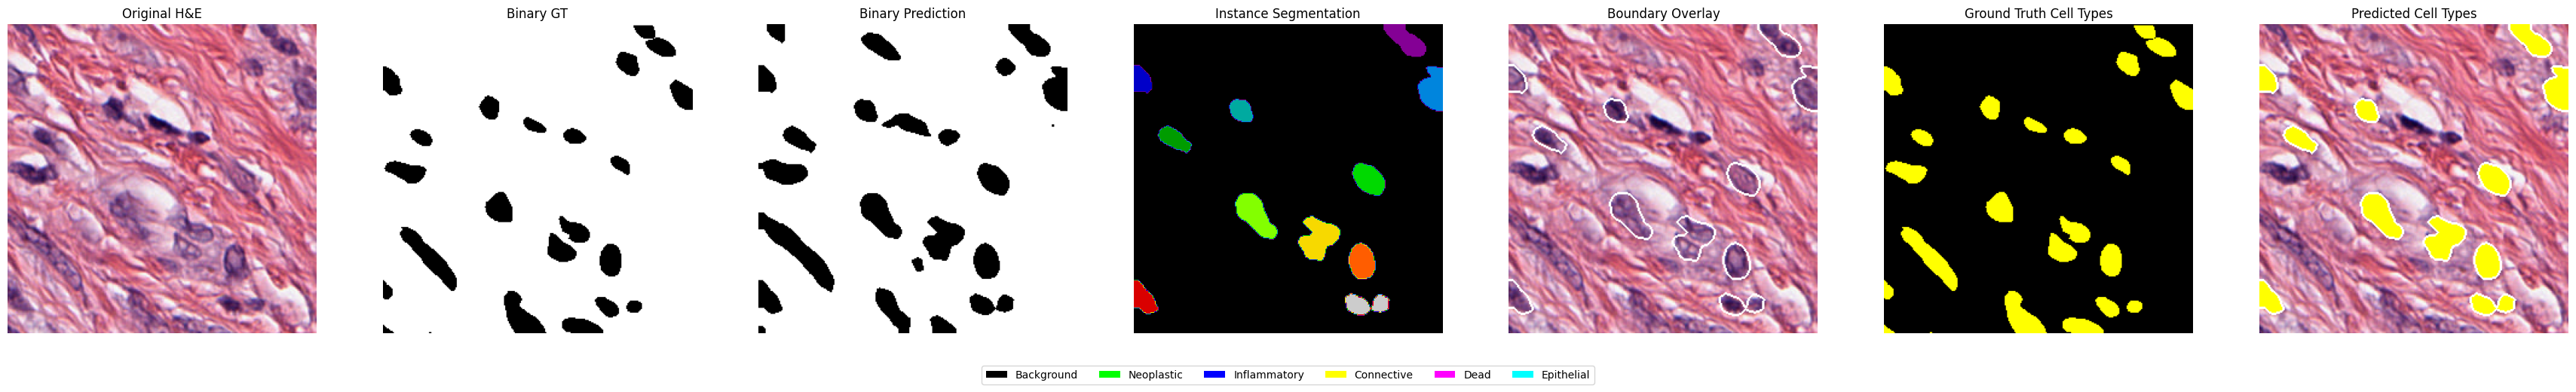


Prediction Statistics:
Number of detected cells: 11

Cell type distribution:
Connective: 11 cells

Input Processing Info:
Original image shape before processing: torch.Size([1, 3, 256, 256])
Image value range: [-0.851, 1.000]
Image dtype: torch.float32

Model Output Info:
cell_mask shape: torch.Size([1, 2, 256, 256])
cell_mask logits range: [-7.180, 5.933]
cell_hv shape: torch.Size([1, 2, 256, 256])
cell_hv range: [-0.792, 0.800]

Post-processing Info:
pred_map shape: (256, 256, 4)
instance_map shape: (256, 256)
instance_map unique values: 12 instances


In [43]:
from skimage.segmentation import find_boundaries
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skimage.segmentation import find_boundaries
from cell_segmentation.utils.post_proc_vitaminp import DetectionCellPostProcessor
import os

def visualize_predictions(he_model, test_loader, device='cuda'):
    """
    Visualize predictions using already loaded model and dataloader
    """
    # Get a random sample
    random_idx = np.random.randint(0, len(test_loader.dataset))
    print(f"Analyzing random sample {random_idx} out of {len(test_loader.dataset)} samples")

    # Get the random sample
    random_sample = test_loader.dataset[random_idx]
    batch = test_loader.collate_fn([random_sample])

    # Define class names and colors
    class_names = {
        0: "Background", 1: "Neoplastic", 2: "Inflammatory",
        3: "Connective", 4: "Dead", 5: "Epithelial"
    }
    type_colors = {
        0: 'black', 1: '#00FF00', 2: 'blue',
        3: 'yellow', 4: 'magenta', 5: 'cyan'
    }

    # Get predictions
    he_model.eval()
    with torch.no_grad():
        images = batch['image'].to(device)
        outputs = he_model(images)
        
        print("\nAvailable keys in model outputs:")
        for key in outputs.keys():
            print(f"- {key}")
            
        # Initialize post-processor
        cell_post_processor = DetectionCellPostProcessor(nr_types=6, magnification=40)
        
        # Process predictions - check if 'cell_hv' exists
        if 'cell_hv' in outputs:
            pred_map = np.concatenate([
                torch.argmax(outputs['cell_types'][0], dim=0).cpu().numpy()[..., None],
                torch.argmax(outputs['cell_mask'][0], dim=0).cpu().numpy()[..., None],
                outputs['cell_hv'][0].cpu().numpy().transpose(1, 2, 0)
            ], axis=-1)
        else:
            # Handle case without cell_hv
            pred_map = np.concatenate([
                torch.argmax(outputs['cell_types'][0], dim=0).cpu().numpy()[..., None],
                torch.argmax(outputs['cell_mask'][0], dim=0).cpu().numpy()[..., None],
                np.zeros((outputs['cell_types'][0].shape[1], outputs['cell_types'][0].shape[2], 2))
            ], axis=-1)

        instance_map, type_pred = cell_post_processor.post_process_cell_segmentation(pred_map)
        
        # Create visualization
        fig, axes = plt.subplots(1, 7, figsize=(35, 5))
        
        # Original image
        img_display = images[0].cpu().numpy()
        img_display = np.moveaxis(img_display, 0, -1)
        img_display = np.clip((img_display - img_display.min()) / 
                            (img_display.max() - img_display.min() + 1e-8), 0, 1)
        axes[0].imshow(img_display)
        axes[0].set_title('Original H&E')
        axes[0].axis('off')
        
        # Binary Ground Truth
        if 'masks' in batch['targets'] and 'cell' in batch['targets']['masks']:
            binary_gt = batch['targets']['masks']['cell'][0].squeeze().cpu().numpy()
            axes[1].imshow(binary_gt > 0, cmap='binary')
            axes[1].set_title('Binary GT')
        else:
            axes[1].set_title('Binary GT (Not Available)')
        axes[1].axis('off')
        
        # Binary Prediction
        binary_pred = torch.softmax(outputs['cell_mask'][0], dim=0)[1].cpu().numpy()
        axes[2].imshow(binary_pred > 0.5, cmap='binary')
        axes[2].set_title('Binary Prediction')
        axes[2].axis('off')
        
        # Instance Segmentation
        axes[3].imshow(instance_map, cmap='nipy_spectral')
        axes[3].set_title('Instance Segmentation')
        axes[3].axis('off')
        
        # Boundary Overlay
        boundaries = find_boundaries(instance_map, mode='thick')
        overlay = img_display.copy()
        overlay[boundaries] = [1, 1, 1]  # White boundaries
        axes[4].imshow(overlay)
        axes[4].set_title('Boundary Overlay')
        axes[4].axis('off')
        
        # Ground Truth Cell Type Map
        # Ground Truth Cell Type Map
        if 'semantic' in batch['targets'] and 'cell_types' in batch['targets']['semantic']:
            cell_types = batch['targets']['semantic']['cell_types'][0].cpu().numpy()
            cell_mask = batch['targets']['masks']['cell'][0].squeeze().cpu().numpy()

            # Create visualization - Fixed version
            gt_type_map = np.zeros_like(cell_mask)
            for i in range(1, cell_mask.max() + 1):  # For each instance
                mask = cell_mask == i
                if mask.any():
                    # Get the type for this masked region
                    masked_types = cell_types[mask]
                    if len(masked_types) > 0:
                        cell_type = np.argmax(np.bincount(masked_types))
                        gt_type_map[mask] = cell_type

            gt_type_rgb = np.zeros((*gt_type_map.shape, 3))
            for type_id in range(len(class_names)):
                color = np.array(mcolors.to_rgb(type_colors[type_id]))
                gt_type_rgb[gt_type_map == type_id] = color

            axes[5].imshow(gt_type_rgb)
            axes[5].set_title('Ground Truth Cell Types')
        else:
            axes[5].set_title('Ground Truth Cell Types (Not Available)')
        axes[5].axis('off')
        
        # Predicted Cell Type Overlay
        pred_type_overlay = img_display.copy()
        for cell_id, cell_info in type_pred.items():
            cell_mask = instance_map == cell_id
            cell_type = cell_info['type']
            pred_type_overlay[cell_mask] = np.array(mcolors.to_rgb(type_colors[cell_type]))
        pred_type_overlay[boundaries] = [1, 1, 1]
        axes[6].imshow(pred_type_overlay)
        axes[6].set_title('Predicted Cell Types')
        axes[6].axis('off')
        
        
        # Add legend
        legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, edgecolor='none', 
                         label=class_names[i]) for i, color in type_colors.items()]
        fig.legend(handles=legend_elements, loc='lower center', 
                  ncol=len(class_names), bbox_to_anchor=(0.5, 0))
        
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.15)
        plt.show()

        # Print statistics
        print("\nPrediction Statistics:")
        print(f"Number of detected cells: {len(type_pred)}")
        type_counts = {}
        for cell_id, cell_info in type_pred.items():
            cell_type = cell_info['type']
            type_counts[cell_type] = type_counts.get(cell_type, 0) + 1
        
        print("\nCell type distribution:")
        for type_id, count in type_counts.items():
            print(f"{class_names[type_id]}: {count} cells")

            # Add these print statements after loading images and before model prediction:
        print("\nInput Processing Info:")
        print(f"Original image shape before processing: {images.shape}")
        print(f"Image value range: [{images.min():.3f}, {images.max():.3f}]")
        print(f"Image dtype: {images.dtype}")

        # After model prediction, add:
        print("\nModel Output Info:")
        print(f"cell_mask shape: {outputs['cell_mask'].shape}")
        print(f"cell_mask logits range: [{outputs['cell_mask'].min():.3f}, {outputs['cell_mask'].max():.3f}]")

        if 'cell_hv' in outputs:
           print(f"cell_hv shape: {outputs['cell_hv'].shape}")
           print(f"cell_hv range: [{outputs['cell_hv'].min():.3f}, {outputs['cell_hv'].max():.3f}]")

        print("\nPost-processing Info:")
        print(f"pred_map shape: {pred_map.shape}")
        print(f"instance_map shape: {instance_map.shape}")
        print(f"instance_map unique values: {len(np.unique(instance_map))} instances")
# Use with existing data:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
visualize_predictions(he_model, loaders['he']['test'], device)

## Paul Data

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skimage.segmentation import find_boundaries
from cell_segmentation.utils.post_proc_vitaminp import DetectionCellPostProcessor

def load_and_preprocess_image(image_path, target_size=(512, 512)):
    """
    Load and preprocess a single image from path
    """
    # Load image
    image = Image.open(image_path)
    
    # Convert to RGB if necessary
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    # Resize if needed
    if image.size != target_size:
        image = image.resize(target_size)
    
    # Convert to numpy array and normalize
    image_array = np.array(image) / 255.0
    
    # Convert to tensor and add batch dimension
    image_tensor = torch.from_numpy(image_array).float()
    image_tensor = image_tensor.permute(2, 0, 1).unsqueeze(0)
    
    return image_tensor

def visualize_single_image(he_model, image_path, device='cuda', save_predictions=True):
    """
    Visualize predictions for a single image from path and optionally save predictions
    Args:
        he_model: The model to use for predictions
        image_path: Path to the input image
        device: Device to run the model on
        save_predictions: Whether to save the prediction overlay
    """
    # Load and preprocess image
    image_tensor = load_and_preprocess_image(image_path)
    image_tensor = image_tensor.to(device)
    
    print(f"Processing image: {image_path}")
    print(f"Input tensor shape: {image_tensor.shape}")
    
    # Define class names and colors
    class_names = {
        0: "Background", 1: "Neoplastic", 2: "Inflammatory",
        3: "Connective", 4: "Dead", 5: "Epithelial"
    }
    type_colors = {
        0: 'black', 1: '#00FF00', 2: 'blue',
        3: 'yellow', 4: 'magenta', 5: 'cyan'
    }

    # Get predictions
    he_model.eval()
    with torch.no_grad():
        outputs = he_model(image_tensor)
        
        print("\nAvailable keys in model outputs:")
        for key in outputs.keys():
            print(f"- {key}")
            
        # Initialize post-processor
        cell_post_processor = DetectionCellPostProcessor(nr_types=6, magnification=40)
        
        # Process predictions
        if 'cell_hv' in outputs:
            pred_map = np.concatenate([
                torch.argmax(outputs['cell_types'][0], dim=0).cpu().numpy()[..., None],
                torch.argmax(outputs['cell_mask'][0], dim=0).cpu().numpy()[..., None],
                outputs['cell_hv'][0].cpu().numpy().transpose(1, 2, 0)
            ], axis=-1)
        else:
            pred_map = np.concatenate([
                torch.argmax(outputs['cell_types'][0], dim=0).cpu().numpy()[..., None],
                torch.argmax(outputs['cell_mask'][0], dim=0).cpu().numpy()[..., None],
                np.zeros((outputs['cell_types'][0].shape[1], outputs['cell_types'][0].shape[2], 2))
            ], axis=-1)

        instance_map, type_pred = cell_post_processor.post_process_cell_segmentation(pred_map)
        
        # Create visualization
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        
        # Original image
        img_display = image_tensor[0].cpu().numpy()
        img_display = np.moveaxis(img_display, 0, -1)
        axes[0].imshow(img_display)
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        
        # Instance Segmentation
        axes[1].imshow(instance_map, cmap='nipy_spectral')
        axes[1].set_title('Instance Segmentation')
        axes[1].axis('off')
        
        # Boundary Overlay
        boundaries = find_boundaries(instance_map, mode='thick')
        overlay = img_display.copy()
        overlay[boundaries] = [1, 1, 1]  # White boundaries
        axes[2].imshow(overlay)
        axes[2].set_title('Boundary Overlay')
        axes[2].axis('off')
        
        # Predicted Cell Type Overlay
        pred_type_overlay = img_display.copy()
        for cell_id, cell_info in type_pred.items():
            cell_mask = instance_map == cell_id
            cell_type = cell_info['type']
            pred_type_overlay[cell_mask] = np.array(mcolors.to_rgb(type_colors[cell_type]))
        pred_type_overlay[boundaries] = [1, 1, 1]
        axes[3].imshow(pred_type_overlay)
        axes[3].set_title('Predicted Cell Types')
        axes[3].axis('off')
        
        # Add legend
        legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, edgecolor='none', 
                         label=class_names[i]) for i, color in type_colors.items()]
        fig.legend(handles=legend_elements, loc='lower center', 
                  ncol=len(class_names), bbox_to_anchor=(0.5, 0))
        
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.15)
        if save_predictions:
            # Create output filename
            base_name = os.path.basename(image_path)
            name_without_ext = os.path.splitext(base_name)[0]
            output_path = os.path.join(os.path.dirname(image_path), f"prediction_{name_without_ext}.png")
            
            # Save the final overlay (predicted cell types with boundaries)
            plt.figure(figsize=(10, 10))
            plt.imshow(pred_type_overlay)
            plt.axis('off')
            
            # Add legend
            legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, edgecolor='none', 
                             label=class_names[i]) for i, color in type_colors.items()]
            plt.legend(handles=legend_elements, loc='center left', 
                      bbox_to_anchor=(1, 0.5))
            
            plt.tight_layout()
            plt.savefig(output_path, bbox_inches='tight', dpi=300)
            plt.close()
            
            print(f"\nSaved prediction overlay to: {output_path}")
        
        plt.show()

        # Print statistics
        print("\nPrediction Statistics:")
        print(f"Number of detected cells: {len(type_pred)}")
        type_counts = {}
        for cell_id, cell_info in type_pred.items():
            cell_type = cell_info['type']
            type_counts[cell_type] = type_counts.get(cell_type, 0) + 1
        
        print("\nCell type distribution:")
        for type_id, count in type_counts.items():
            print(f"{class_names[type_id]}: {count} cells")

# Usage example:
def process_folder(model, folder_path, device='cuda', save_predictions=True):
    """
    Process all images in a folder
    Args:
        model: The model to use for predictions
        folder_path: Path to the folder containing images
        device: Device to run the model on
        save_predictions: Whether to save prediction overlays
    """
    supported_formats = ['.jpg', '.jpeg', '.png', '.tif', '.tiff']
    
    for filename in os.listdir(folder_path):
        if any(filename.lower().endswith(fmt) for fmt in supported_formats):
            image_path = os.path.join(folder_path, filename)
            print(f"\nProcessing {filename}")
            visualize_single_image(model, image_path, device, save_predictions)

# Use the functions:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
folder_path = "/rsrch9/home/plm/idso_fa1_pathology/TIER1/paul-xenium/patches/Xenium_Prime_Human_Lung_Cancer_FFPE_outs/Yasin_Model"
process_folder(he_model, folder_path, device)

## NuInSeg validations

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob
import os
import torch
from skimage.segmentation import find_boundaries

def predict_binary_segmentation(he_model, base_path="/rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/NuInsSeg", device='cuda'):
   model_size = (256, 256)
   
   organ_paths = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
   print(f"\nAvailable organs: {organ_paths}")
   
   organ = random.choice(organ_paths)
   organ_path = os.path.join(base_path, organ)
   
   img_paths = glob(os.path.join(organ_path, 'tissue images', '*.png'))
   mask_paths = glob(os.path.join(organ_path, 'mask binary', '*.png'))
   
   print(f"\nNumber of images found: {len(img_paths)}")
   print(f"Number of masks found: {len(mask_paths)}")
   
   idx = random.randint(0, len(img_paths)-1)
   img_path = img_paths[idx]
   mask_path = mask_paths[idx]
   
   print(f"\nSelected image: {img_path}")
   print(f"Selected mask: {mask_path}")
   
   image = cv2.imread(img_path)
   image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
   print(f"Original image shape: {image.shape}")
   
   image = cv2.resize(image, model_size)
   print(f"Resized image shape: {image.shape}")
   
   # Updated normalization
   image = image.astype(np.float32)
   mean = [0.5, 0.5, 0.5]
   std = [0.5, 0.5, 0.5]
   image = (image / 255.0 - mean) / std
   print(f"Normalized image range: {image.min()} - {image.max()}")
   
   image_tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float().to(device)
   print(f"Image tensor shape: {image_tensor.shape}")
   
   mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
   print(f"Original mask shape: {mask.shape}")
   
   mask = cv2.resize(mask, model_size)
   mask = (mask > 128).astype(np.float32)
   print(f"Processed mask unique values: {np.unique(mask)}")
   
   he_model.eval()
   with torch.no_grad():
       outputs = he_model(image_tensor)
       print("\nModel outputs:", outputs.keys())
       
       logits = outputs['cell_mask'][0]
       print(f"Logits shape: {logits.shape}")
       print(f"Logits range: {logits.min().item()} - {logits.max().item()}")
       
       pred_map = np.concatenate([
           np.zeros((model_size[0], model_size[1], 1)),
           torch.argmax(outputs['cell_mask'][0], dim=0).cpu().numpy()[..., None],
           outputs['cell_hv'][0].cpu().numpy().transpose(1, 2, 0)
       ], axis=-1)
       
       print(f"Pred map shape: {pred_map.shape}")
       
       cell_post_processor = DetectionCellPostProcessor(nr_types=2, magnification=40)
       instance_map, _ = cell_post_processor.post_process_cell_segmentation(pred_map)
       
       raw_pred = logits[1].cpu().numpy()
       print(f"Raw prediction range: {raw_pred.min()} - {raw_pred.max()}")
       
       binary_pred = torch.nn.functional.softmax(logits, dim=0)[1].cpu().numpy()
       binary_pred = (binary_pred > 0.5).astype(np.float32)  # Added thresholding
       
       print(f"\nBinary prediction shape: {binary_pred.shape}")
       print(f"Binary prediction unique values: {np.unique(binary_pred)}")
   
   # Denormalize image for visualization
   image_large = cv2.resize(image * std + mean, (512, 512))
   image_large = np.clip(image_large, 0, 1)
   mask_large = cv2.resize(mask, (512, 512))
   binary_pred_large = cv2.resize(binary_pred, (512, 512))
   instance_map_large = cv2.resize(instance_map.astype(np.float32), (512, 512))
   boundaries = find_boundaries(instance_map_large.astype(np.int32), mode='thick')
   
   print(f"\nFinal shapes:")
   print(f"Image large: {image_large.shape}")
   print(f"Mask large: {mask_large.shape}")
   print(f"Binary pred large: {binary_pred_large.shape}")
   print(f"Instance map large: {instance_map_large.shape}")
   
   fig, axes = plt.subplots(1, 4, figsize=(20, 5))
   
   axes[0].imshow(image_large)
   axes[0].set_title(f'Original Image\n{organ}')
   axes[0].axis('off')
   
   axes[1].imshow(mask_large, cmap='gray')
   axes[1].set_title('Ground Truth')
   axes[1].axis('off')
   
   axes[2].imshow(raw_pred, cmap='gray')
   axes[2].set_title('Raw Logits')
   axes[2].axis('off')
   
   axes[3].imshow(binary_pred, cmap='gray')
   axes[3].set_title('Binary Prediction')
   axes[3].axis('off')
   
   plt.tight_layout()
   plt.show()
   
   print(f"\nNumber of detected instances: {len(np.unique(instance_map)) - 1}")

# Run prediction 
predict_binary_segmentation(he_model)

## Metrics NuInSeg 

In [ ]:
import cv2
import numpy as np
import torch
import os
from glob import glob
from skimage.segmentation import find_boundaries
from cell_segmentation.utils.post_proc_vitaminp import DetectionCellPostProcessor
from sklearn.metrics import precision_recall_fscore_support

def process_single_image(image_path, mask_path, he_model, model_size=(256, 256), device='cuda'):
    # Load and process image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, model_size)
    
    # Normalize
    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]
    image = (image.astype(np.float32) / 255.0 - mean) / std
    image_tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float().to(device)
    
    # Load mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, model_size)
    mask = (mask > 128).astype(np.float32)
    
    # Predict and post-process
    he_model.eval()
    with torch.no_grad():
        outputs = he_model(image_tensor)
        pred_map = np.concatenate([
            np.zeros((model_size[0], model_size[1], 1)),
            torch.argmax(outputs['cell_mask'][0], dim=0).cpu().numpy()[..., None],
            outputs['cell_hv'][0].cpu().numpy().transpose(1, 2, 0)
        ], axis=-1)
        
        cell_post_processor = DetectionCellPostProcessor(nr_types=2, magnification=40)
        instance_map, _ = cell_post_processor.post_process_cell_segmentation(pred_map)
        
        # Create binary instances
        binary_instances = np.zeros_like(instance_map, dtype=np.float32)
        boundaries = find_boundaries(instance_map, mode='thick')
        for i in np.unique(instance_map):
            if i > 0:
                instance_mask = instance_map == i
                eroded_mask = instance_mask & ~find_boundaries(instance_mask, mode='thick')
                binary_instances[eroded_mask] = 1
        
        return mask.flatten(), binary_instances.flatten()

def calculate_dataset_metrics(he_model, base_path="/rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/NuInsSeg"):
    all_y_true = []
    all_y_pred = []
    organ_metrics = {}
    
    organ_paths = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    
    for organ in organ_paths:
        organ_path = os.path.join(base_path, organ)
        img_paths = glob(os.path.join(organ_path, 'tissue images', '*.png'))
        mask_paths = glob(os.path.join(organ_path, 'mask binary', '*.png'))
        
        organ_y_true = []
        organ_y_pred = []
        
        for img_path, mask_path in zip(sorted(img_paths), sorted(mask_paths)):
            y_true, y_pred = process_single_image(img_path, mask_path, he_model)
            organ_y_true.extend(y_true)
            organ_y_pred.extend(y_pred)
            all_y_true.extend(y_true)
            all_y_pred.extend(y_pred)
        
        # Calculate metrics per organ
        precision, recall, f1, _ = precision_recall_fscore_support(
            organ_y_true, organ_y_pred, average='binary'
        )
        organ_metrics[organ] = {'precision': precision, 'recall': recall, 'f1': f1}
    
    # Calculate overall metrics
    overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(
        all_y_true, all_y_pred, average='binary'
    )
    
    return {
        'overall': {
            'precision': overall_precision,
            'recall': overall_recall,
            'f1': overall_f1
        },
        'per_organ': organ_metrics
    }

# Usage
metrics = calculate_dataset_metrics(he_model)
print("\nOverall Metrics:")
print(f"Precision: {metrics['overall']['precision']:.3f}")
print(f"Recall: {metrics['overall']['recall']:.3f}")
print(f"F1 Score: {metrics['overall']['f1']:.3f}")

print("\nPer-organ Metrics:")
for organ, scores in metrics['per_organ'].items():
    print(f"\n{organ}:")
    print(f"Precision: {scores['precision']:.3f}")
    print(f"Recall: {scores['recall']:.3f}")
    print(f"F1 Score: {scores['f1']:.3f}")

In [ ]:
import cv2
import numpy as np
import torch
import os
import random
from glob import glob
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries
from cell_segmentation.utils.post_proc_vitaminp import DetectionCellPostProcessor
from sklearn.metrics import precision_recall_fscore_support

def process_and_visualize_sample(he_model, base_path="/rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/NuInsSeg", model_size=(256, 256), device='cuda'):
    # Get random organ and image
    organ_paths = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    organ = random.choice(organ_paths)
    organ_path = os.path.join(base_path, organ)
    
    img_paths = glob(os.path.join(organ_path, 'tissue images', '*.png'))
    mask_paths = glob(os.path.join(organ_path, 'mask binary', '*.png'))
    
    idx = random.randint(0, len(img_paths)-1)
    img_path = img_paths[idx]
    mask_path = mask_paths[idx]
    
    print(f"Processing organ: {organ}")
    print(f"Image: {os.path.basename(img_path)}")
    
    # Process image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image = cv2.resize(image, model_size)
    
    # Normalize
    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]
    image = (original_image.astype(np.float32) / 255.0 - mean) / std
    image_tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float().to(device)
    
    # Load mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, model_size)
    mask = (mask > 128).astype(np.float32)
    
    # Model prediction
    he_model.eval()
    with torch.no_grad():
        outputs = he_model(image_tensor)
        pred_map = np.concatenate([
            np.zeros((model_size[0], model_size[1], 1)),
            torch.argmax(outputs['cell_mask'][0], dim=0).cpu().numpy()[..., None],
            outputs['cell_hv'][0].cpu().numpy().transpose(1, 2, 0)
        ], axis=-1)
        
        # Post-process
        cell_post_processor = DetectionCellPostProcessor(nr_types=2, magnification=40)
        instance_map, _ = cell_post_processor.post_process_cell_segmentation(pred_map)
        
        # Create binary instances
        binary_instances = np.zeros_like(instance_map, dtype=np.float32)
        boundaries = find_boundaries(instance_map, mode='thick')
        for i in np.unique(instance_map):
            if i > 0:
                instance_mask = instance_map == i
                eroded_mask = instance_mask & ~find_boundaries(instance_mask, mode='thick')
                binary_instances[eroded_mask] = 1
        
        # Calculate metrics
        y_true = mask.flatten()
        y_pred = binary_instances.flatten()
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
        
        print("\nMetrics Details:")
        print(f"True Positives: {np.sum((y_pred == 1) & (y_true == 1))}")
        print(f"False Positives: {np.sum((y_pred == 1) & (y_true == 0))}")
        print(f"False Negatives: {np.sum((y_pred == 0) & (y_true == 1))}")
        print(f"Total Cells: {len(np.unique(instance_map)) - 1}")
        
        print(f"\nMetrics:")
        print(f"Precision: {precision:.3f}")
        print(f"Recall: {recall:.3f}")
        print(f"F1 Score: {f1:.3f}")
        
        # Visualize
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        
        axes[0].imshow(original_image)
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        
        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title('Ground Truth')
        axes[1].axis('off')
        
        axes[2].imshow(binary_instances, cmap='gray')
        axes[2].set_title('Predicted Binary Instances')
        axes[2].axis('off')
        
        axes[3].imshow(instance_map, cmap='nipy_spectral')
        axes[3].set_title(f'Instance Map\n({len(np.unique(instance_map))-1} cells)')
        axes[3].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return {
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

# Usage
sample_metrics = process_and_visualize_sample(he_model)

## MonuSeg

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import random
from skimage.segmentation import find_boundaries
from cell_segmentation.utils.post_proc_vitaminp import DetectionCellPostProcessor

def predict_monuseg(he_model, base_path="/rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/MonuSeg/kmms_test/kmms_test", device='cuda'):
  model_size = (256, 256)
  
  images_path = os.path.join(base_path, "images")
  masks_path = os.path.join(base_path, "masks")
  
  mask_files = set(os.listdir(masks_path))
  img_files = [f for f in os.listdir(images_path) if not f.startswith('.')]
  
  while True:
      idx = random.randint(0, len(img_files)-1)
      img_name = img_files[idx]
      mask_name = next((m for m in [
          img_name.strip(),
          img_name.replace('.png', ' .png'),
          img_name.split('.')[0] + ' .png'
      ] if m in mask_files), None)
      
      if mask_name:
          break
  
  print(f"Processing image: {img_name} with mask: {mask_name}")
  
  image = cv2.imread(os.path.join(images_path, img_name))
  if image is None:
      raise ValueError(f"Failed to load image: {img_name}")

  # Convert BGR to RGB
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  print("\nInput Processing Info:")
  print(f"Original image shape before resize: {image.shape}")
  image = cv2.resize(image, model_size)
  print(f"Image shape after resize: {image.shape}")
  
  # Normalization
  image = image.astype(np.float32)
  mean = [0.5, 0.5, 0.5]
  std = [0.5, 0.5, 0.5]
  image = (image / 255.0 - mean) / std
  print(f"Image value range after normalization: [{image.min():.3f}, {image.max():.3f}]")
  
  image_tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float().to(device)
  print(f"Final tensor shape: {image_tensor.shape}")
  print(f"Tensor dtype: {image_tensor.dtype}")
  
  mask = cv2.imread(os.path.join(masks_path, mask_name), cv2.IMREAD_GRAYSCALE)
  if mask is None:
      raise ValueError(f"Failed to load mask: {mask_name}")
      
  mask = cv2.resize(mask, model_size)
  mask = (mask > 128).astype(np.float32)

  he_model.eval()
  with torch.no_grad():
      outputs = he_model(image_tensor)
      logits = outputs['cell_mask'][0]
      
      print("\nModel Output Info:")
      print(f"cell_mask shape: {outputs['cell_mask'].shape}")
      print(f"cell_mask logits range: [{outputs['cell_mask'].min():.3f}, {outputs['cell_mask'].max():.3f}]")
      
      if 'cell_hv' in outputs:
          print(f"cell_hv shape: {outputs['cell_hv'].shape}")
          print(f"cell_hv range: [{outputs['cell_hv'].min():.3f}, {outputs['cell_hv'].max():.3f}]")
      
      pred_map = np.concatenate([
          np.zeros((model_size[0], model_size[1], 1)),
          torch.argmax(outputs['cell_mask'][0], dim=0).cpu().numpy()[..., None],
          outputs['cell_hv'][0].cpu().numpy().transpose(1, 2, 0)
      ], axis=-1)
      
      print("\nPost-processing Info:")
      print(f"pred_map shape: {pred_map.shape}")
      
      cell_post_processor = DetectionCellPostProcessor(nr_types=2, magnification=40)
      instance_map, type_pred = cell_post_processor.post_process_cell_segmentation(pred_map)
      
      print(f"instance_map shape: {instance_map.shape}")
      print(f"instance_map unique values: {len(np.unique(instance_map))} instances")
      
      raw_pred = logits[1].cpu().numpy()
      binary_pred = torch.nn.functional.softmax(logits, dim=0)[1].cpu().numpy()

        # Add this after binary_pred calculation
      binary_pred = (binary_pred > 0.5).astype(np.float32)
        
  fig, axes = plt.subplots(1, 4, figsize=(20, 5))
  
  # Display original image
  img_display = image.copy() * std + mean  # Denormalize
  img_display = np.clip(img_display, 0, 1)  # Clip values
  axes[0].imshow(img_display)  # No need for BGR2RGB conversion since already in RGB
  axes[0].set_title('Original Image')
  axes[0].axis('off')
  
  axes[1].imshow(mask, cmap='gray')
  axes[1].set_title('Ground Truth')
  axes[1].axis('off')
  
  axes[2].imshow(raw_pred, cmap='gray')
  axes[2].set_title('Raw Logits')
  axes[2].axis('off')
  
  axes[3].imshow(binary_pred, cmap='gray')
  axes[3].set_title('Softmax Output')
  axes[3].axis('off')
  
  plt.tight_layout()
  plt.show()
  
  print(f"\nNumber of detected instances: {len(np.unique(instance_map)) - 1}")

# Run prediction
predict_monuseg(he_model)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import random
from skimage.segmentation import find_boundaries
from cell_segmentation.utils.post_proc_vitaminp import DetectionCellPostProcessor
import matplotlib.colors as mcolors

def predict_monuseg(he_model, base_path="/rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/MonuSeg/kmms_test/kmms_test", device='cuda'):
    model_size = (256, 256)
    
    # Path setup
    images_path = os.path.join(base_path, "images")
    masks_path = os.path.join(base_path, "masks")
    
    # File selection
    mask_files = set(os.listdir(masks_path))
    img_files = [f for f in os.listdir(images_path) if not f.startswith('.')]
    
    while True:
        idx = random.randint(0, len(img_files)-1)
        img_name = img_files[idx]
        mask_name = next((m for m in [
            img_name.strip(),
            img_name.replace('.png', ' .png'),
            img_name.split('.')[0] + ' .png'
        ] if m in mask_files), None)
        
        if mask_name:
            break
    
    print(f"Processing image: {img_name} with mask: {mask_name}")
    
    # Load and preprocess image
    image = cv2.imread(os.path.join(images_path, img_name))
    if image is None:
        raise ValueError(f"Failed to load image: {img_name}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    print("\nInput Processing Info:")
    print(f"Original image shape: {image.shape}")
    original_image = image.copy()
    image = cv2.resize(image, model_size)
    print(f"Resized shape: {image.shape}")
    
    # Normalization
    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]
    image = image.astype(np.float32)
    image = (image / 255.0 - mean) / std
    print(f"Value range after normalization: [{image.min():.3f}, {image.max():.3f}]")
    
    # Create tensor
    image_tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float().to(device)
    print(f"Tensor shape: {image_tensor.shape}")
    
    # Load mask
    mask = cv2.imread(os.path.join(masks_path, mask_name), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise ValueError(f"Failed to load mask: {mask_name}")
    mask = cv2.resize(mask, model_size)
    mask = (mask > 128).astype(np.float32)
    
    # Model prediction
    he_model.eval()
    with torch.no_grad():
        outputs = he_model(image_tensor)
        logits = outputs['cell_mask'][0]
        
        print("\nModel Output Info:")
        print(f"cell_mask shape: {outputs['cell_mask'].shape}")
        print(f"cell_mask range: [{outputs['cell_mask'].min():.3f}, {outputs['cell_mask'].max():.3f}]")
        
        # Get HV maps and create pred_map
        if 'cell_hv' in outputs:
            print(f"cell_hv shape: {outputs['cell_hv'].shape}")
            print(f"cell_hv range: [{outputs['cell_hv'].min():.3f}, {outputs['cell_hv'].max():.3f}]")
            hv_maps = outputs['cell_hv'][0].cpu().numpy()
            h_map = hv_maps[0]
            v_map = hv_maps[1]
            
        pred_map = np.concatenate([
            np.zeros((model_size[0], model_size[1], 1)),
            torch.argmax(outputs['cell_mask'][0], dim=0).cpu().numpy()[..., None],
            outputs['cell_hv'][0].cpu().numpy().transpose(1, 2, 0)
        ], axis=-1)
        
        # Post-process to get instance map
        print("\nPost-processing Info:")
        print(f"pred_map shape: {pred_map.shape}")
        cell_post_processor = DetectionCellPostProcessor(nr_types=2, magnification=40)
        instance_map, type_pred = cell_post_processor.post_process_cell_segmentation(pred_map)
        print(f"Detected instances: {len(np.unique(instance_map)) - 1}")
        
        # Get boundaries first
        boundaries = find_boundaries(instance_map, mode='thick')

        # Create binary instance visualization using the same instance map as boundaries
        binary_instances = np.zeros_like(instance_map, dtype=np.float32)
        for i in np.unique(instance_map):
            if i > 0:  # Skip background
                # Create a mask for this instance without the boundary
                instance_mask = instance_map == i
                eroded_mask = instance_mask & ~find_boundaries(instance_mask, mode='thick')
                binary_instances[eroded_mask] = 1
                
        # Add thin black boundaries between cells
        binary_instances[boundaries] = 0  # Make boundaries black
        
        # Get boundaries and predictions
        boundaries = find_boundaries(instance_map, mode='thick')
        binary_pred = torch.nn.functional.softmax(logits, dim=0)[1].cpu().numpy()
        binary_pred = (binary_pred > 0.5).astype(np.float32)
        
        # Create complete visualization
        fig = plt.figure(figsize=(20, 15))
        gs = plt.GridSpec(3, 3, figure=fig)
        
        # Original image
        ax1 = fig.add_subplot(gs[0, 0])
        img_display = image.copy() * std + mean
        img_display = np.clip(img_display, 0, 1)
        ax1.imshow(img_display)
        ax1.set_title('Original Image')
        ax1.axis('off')
        
        # Ground truth mask
        ax2 = fig.add_subplot(gs[0, 1])
        ax2.imshow(mask, cmap='gray')
        ax2.set_title('Ground Truth')
        ax2.axis('off')
        
        # Raw binary prediction
        ax3 = fig.add_subplot(gs[0, 2])
        ax3.imshow(binary_pred, cmap='gray')
        ax3.set_title('Raw Binary Prediction')
        ax3.axis('off')
        
        # Separated binary instances
        ax4 = fig.add_subplot(gs[1, 0])
        ax4.imshow(binary_instances, cmap='gray')
        ax4.set_title('Separated Binary Instances')
        ax4.axis('off')
        
        # Horizontal gradients
        ax5 = fig.add_subplot(gs[1, 1])
        ax5.imshow(h_map, cmap='RdBu')
        ax5.set_title('Horizontal Gradients')
        ax5.axis('off')
        
        # Vertical gradients
        ax6 = fig.add_subplot(gs[1, 2])
        ax6.imshow(v_map, cmap='RdBu')
        ax6.set_title('Vertical Gradients')
        ax6.axis('off')
        
        # Instance segmentation
        ax7 = fig.add_subplot(gs[2, 0])
        ax7.imshow(instance_map, cmap='nipy_spectral')
        ax7.set_title('Instance Segmentation')
        ax7.axis('off')
        
        # Boundary overlay
        ax8 = fig.add_subplot(gs[2, 1])
        overlay = img_display.copy()
        overlay[boundaries] = [0, 0, 0]  # Black boundaries
        ax8.imshow(overlay)
        ax8.set_title('Boundary Overlay')
        ax8.axis('off')
        
        # Combined visualization
        ax9 = fig.add_subplot(gs[2, 2])
        combined = img_display.copy()
        instance_overlay = plt.cm.nipy_spectral(instance_map / instance_map.max())
        combined = combined * 0.7 + instance_overlay[:, :, :3] * 0.3
        combined[boundaries] = [0, 0, 0]  # Black boundaries
        ax9.imshow(combined)
        ax9.set_title('Combined Visualization')
        ax9.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Additional binary visualization
        fig2, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(mask, cmap='gray')
        axes[0].set_title('Ground Truth')
        axes[0].axis('off')
        
        axes[1].imshow(binary_pred, cmap='gray')
        axes[1].set_title('Raw Binary Prediction')
        axes[1].axis('off')
        
        axes[2].imshow(binary_instances, cmap='gray')
        axes[2].set_title('Separated Binary Instances')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return {
            'instance_map': instance_map,
            'type_pred': type_pred,
            'boundaries': boundaries,
            'binary_pred': binary_pred,
            'binary_instances': binary_instances,
            'hv_maps': {'h': h_map, 'v': v_map}
        }

# Usage:
# results = predict_monuseg(he_model, base_path="path/to/data")

# Usage:
results = predict_monuseg(he_model, base_path="/rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/MonuSeg/kmms_test/kmms_test")

## MonuSeg Metrics

In [ ]:
import cv2
import numpy as np
import torch
from skimage.segmentation import find_boundaries
from cell_segmentation.utils.post_proc_vitaminp import DetectionCellPostProcessor
from sklearn.metrics import precision_recall_fscore_support

def process_single_image(image_path, mask_path, he_model, model_size=(256, 256), device='cuda'):
    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, model_size)
    
    # Normalization
    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]
    image = (image.astype(np.float32) / 255.0 - mean) / std
    
    # Create tensor
    image_tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float().to(device)
    
    # Load mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, model_size)
    mask = (mask > 128).astype(np.float32)
    
    # Model prediction
    he_model.eval()
    with torch.no_grad():
        outputs = he_model(image_tensor)
        
        # Get prediction maps
        pred_map = np.concatenate([
            np.zeros((model_size[0], model_size[1], 1)),
            torch.argmax(outputs['cell_mask'][0], dim=0).cpu().numpy()[..., None],
            outputs['cell_hv'][0].cpu().numpy().transpose(1, 2, 0)
        ], axis=-1)
        
        # Post-process
        cell_post_processor = DetectionCellPostProcessor(nr_types=2, magnification=40)
        instance_map, _ = cell_post_processor.post_process_cell_segmentation(pred_map)
        
        # Create binary instance map
        binary_instances = np.zeros_like(instance_map, dtype=np.float32)
        boundaries = find_boundaries(instance_map, mode='thick')
        for i in np.unique(instance_map):
            if i > 0:
                instance_mask = instance_map == i
                eroded_mask = instance_mask & ~find_boundaries(instance_mask, mode='thick')
                binary_instances[eroded_mask] = 1
        
        return mask.flatten(), binary_instances.flatten()

def calculate_metrics_for_dataset(he_model, base_path):
    images_path = os.path.join(base_path, "images")
    masks_path = os.path.join(base_path, "masks")
    
    mask_files = set(os.listdir(masks_path))
    img_files = [f for f in os.listdir(images_path) if not f.startswith('.')]
    
    all_y_true = []
    all_y_pred = []
    
    for img_name in img_files:
        mask_name = next((m for m in [
            img_name.strip(),
            img_name.replace('.png', ' .png'),
            img_name.split('.')[0] + ' .png'
        ] if m in mask_files), None)
        
        if mask_name:
            y_true, y_pred = process_single_image(
                os.path.join(images_path, img_name),
                os.path.join(masks_path, mask_name),
                he_model
            )
            all_y_true.extend(y_true)
            all_y_pred.extend(y_pred)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_y_true, 
        all_y_pred, 
        average='binary'
    )
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Usage:
metrics = calculate_metrics_for_dataset(he_model, "/rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/MonuSeg/kmms_test/kmms_test")
print(f"Precision: {metrics['precision']:.3f}")
print(f"Recall: {metrics['recall']:.3f}") 
print(f"F1 Score: {metrics['f1']:.3f}")

In [ ]:
import cv2
import numpy as np
import torch
import os
import random
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries
from cell_segmentation.utils.post_proc_vitaminp import DetectionCellPostProcessor
from sklearn.metrics import precision_recall_fscore_support

def process_and_visualize_sample(he_model, base_path, model_size=(256, 256), device='cuda'):
    # Setup paths
    images_path = os.path.join(base_path, "images")
    masks_path = os.path.join(base_path, "masks")
    
    # Get random image
    img_files = [f for f in os.listdir(images_path) if not f.startswith('.')]
    mask_files = set(os.listdir(masks_path))
    
    img_name = random.choice(img_files)
    mask_name = next((m for m in [
        img_name.strip(),
        img_name.replace('.png', ' .png'),
        img_name.split('.')[0] + ' .png'
    ] if m in mask_files), None)
    
    print(f"Processing: {img_name}")
    
    # Load and process image
    image = cv2.imread(os.path.join(images_path, img_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image = cv2.resize(image, model_size)
    
    # Normalize
    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]
    image = (original_image.astype(np.float32) / 255.0 - mean) / std
    image_tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float().to(device)
    
    # Load mask
    mask = cv2.imread(os.path.join(masks_path, mask_name), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, model_size)
    mask = (mask > 128).astype(np.float32)
    
    # Model prediction
    he_model.eval()
    with torch.no_grad():
        outputs = he_model(image_tensor)
        pred_map = np.concatenate([
            np.zeros((model_size[0], model_size[1], 1)),
            torch.argmax(outputs['cell_mask'][0], dim=0).cpu().numpy()[..., None],
            outputs['cell_hv'][0].cpu().numpy().transpose(1, 2, 0)
        ], axis=-1)
        
        # Post-process
        cell_post_processor = DetectionCellPostProcessor(nr_types=2, magnification=40)
        instance_map, _ = cell_post_processor.post_process_cell_segmentation(pred_map)
        
        # Create binary instances
        binary_instances = np.zeros_like(instance_map, dtype=np.float32)
        boundaries = find_boundaries(instance_map, mode='thick')
        for i in np.unique(instance_map):
            if i > 0:
                instance_mask = instance_map == i
                eroded_mask = instance_mask & ~find_boundaries(instance_mask, mode='thick')
                binary_instances[eroded_mask] = 1
        
        # Calculate metrics for this sample
        y_true = mask.flatten()
        y_pred = binary_instances.flatten()
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
        
        print("\nMetrics Calculation Details:")
        print(f"Total pixels: {len(y_true)}")
        print(f"True Positives: {np.sum((y_pred == 1) & (y_true == 1))}")
        print(f"False Positives: {np.sum((y_pred == 1) & (y_true == 0))}")
        print(f"False Negatives: {np.sum((y_pred == 0) & (y_true == 1))}")
        print(f"\nMetrics:")
        print(f"Precision: {precision:.3f}")
        print(f"Recall: {recall:.3f}")
        print(f"F1 Score: {f1:.3f}")
        
        # Visualize
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(original_image)
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        
        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title('Ground Truth Mask')
        axes[1].axis('off')
        
        axes[2].imshow(binary_instances, cmap='gray')
        axes[2].set_title('Predicted Binary Instances')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return {
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

# Usage
sample_metrics = process_and_visualize_sample(
    he_model, 
    "/rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/MonuSeg/kmms_test/kmms_test"
)

## MoNuSegTest Data

In [ ]:
import os
import xml.etree.ElementTree as ET
import numpy as np
import cv2
import tifffile
import matplotlib.pyplot as plt

def parse_xml_mask(xml_path, img_shape):
    """Parse XML annotations to create binary mask."""
    mask = np.zeros(img_shape[:2], dtype=np.uint8)
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    for region in root.iter('Region'):
        vertices = []
        for vertex in region.iter('Vertex'):
            x = float(vertex.get('X'))
            y = float(vertex.get('Y'))
            vertices.append([x, y])
            
        if vertices:
            vertices = np.array(vertices, dtype=np.int32)
            cv2.fillPoly(mask, [vertices], 1)
    
    return mask

def load_dataset(data_dir):
    """Load images and masks from directory."""
    images = []
    masks = []
    filenames = []
    
    # Get all TIFF files (excluding hidden files)
    tiff_files = [f for f in os.listdir(data_dir) 
                 if f.endswith('.tif') and not f.startswith('.')]
    
    for tiff_file in sorted(tiff_files):
        img_path = os.path.join(data_dir, tiff_file)
        xml_path = os.path.join(data_dir, tiff_file.replace('.tif', '.xml'))
        
        try:
            img = tifffile.imread(img_path)
            if os.path.exists(xml_path):
                mask = parse_xml_mask(xml_path, img.shape)
                masks.append(mask)
                images.append(img)
                filenames.append(tiff_file)
                print(f"Processed {tiff_file}: Image shape {img.shape}, Mask shape {mask.shape}")
        except Exception as e:
            print(f"Error processing {tiff_file}: {e}")
            
    return images, masks, filenames

# Load data
data_dir = "/rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/MoNuSegTestData/"
images, masks, filenames = load_dataset(data_dir)

# Visualize first image and mask if data was loaded
if images and masks:
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.imshow(images[0])
    plt.title(f'Original Image: {filenames[0]}')
    plt.subplot(122)
    plt.imshow(masks[0], cmap='gray')
    plt.title('Segmentation Mask')
    plt.show()

In [ ]:
import os
import cv2
import numpy as np
import torch
import xml.etree.ElementTree as ET
from cell_segmentation.utils.post_proc_vitaminp import DetectionCellPostProcessor
from cell_segmentation.utils.metrics import get_fast_pq, cell_detection_scores
import random
from scipy.ndimage import center_of_mass
from scipy.spatial.distance import cdist

def parse_xml_mask(xml_path, shape):
    """
    Parse XML annotations and create instance mask with each cell properly separated
    """
    instance_mask = np.zeros(shape[:2], dtype=np.uint32)
    tree = ET.parse(xml_path)
    root = tree.getroot()
        
    # Process each region separately and assign unique instance IDs
    instance_id = 1
    for region in root.iter('Region'):
        region_id = region.get('Id')
        vertices = []
        for vertex in region.iter('Vertex'):
            x = float(vertex.get('X'))
            y = float(vertex.get('Y'))
            vertices.append([x, y])
            
        if vertices:
            vertices = np.array(vertices, dtype=np.int32)
            # Create temporary mask for this specific cell
            cell_mask = np.zeros(shape[:2], dtype=np.uint8)
            cv2.fillPoly(cell_mask, [vertices], 1)
            
            # Check if this cell overlaps with any existing cells
            if np.any(instance_mask[cell_mask == 1] > 0):
                overlap_ids = np.unique(instance_mask[cell_mask == 1])[1:]  # Skip 0
            
            # Assign unique instance ID to this cell
            instance_mask[cell_mask == 1] = instance_id
            
            # Print statistics for verification
            area = np.sum(cell_mask)
            centroid = center_of_mass(cell_mask)

            
            instance_id += 1
    
    # Verification step
    unique_instances = np.unique(instance_mask)
    num_instances = len(unique_instances) - 1  # Subtract 1 for background
    
    return instance_mask

def process_single_patch(image_path, xml_path, he_model, patch_size=256, device='cuda'):
    """
    Process a single patch with improved ground truth handling
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image from {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Get ground truth mask with separated instances
    gt_mask = parse_xml_mask(xml_path, image.shape)
    
    # Random patch selection
    h, w = image.shape[:2]
    max_h = h - patch_size
    max_w = w - patch_size
    start_h = random.randint(0, max_h)
    start_w = random.randint(0, max_w)
    
    # Extract patches
    patch = image[start_h:start_h+patch_size, start_w:start_w+patch_size]
    patch_mask = gt_mask[start_h:start_h+patch_size, start_w:start_w+patch_size]
    
    # Verify patch mask instances
    patch_instances = np.unique(patch_mask)
    print(f"\nPatch contains {len(patch_instances)-1} cells")  # Subtract 1 for background
    
    # Process patch through model
    patch_norm = (patch.astype(np.float32) / 255.0 - 0.5) / 0.5
    patch_tensor = torch.from_numpy(patch_norm).permute(2, 0, 1).unsqueeze(0).float().to(device)
    
    he_model.eval()
    with torch.no_grad():
        outputs = he_model(patch_tensor)
        pred_map = np.concatenate([
            np.zeros((patch_size, patch_size, 1)),
            torch.argmax(outputs['cell_mask'][0], dim=0).cpu().numpy()[..., None],
            outputs['cell_hv'][0].cpu().numpy().transpose(1, 2, 0)
        ], axis=-1)
        
        instance_pred, _ = DetectionCellPostProcessor(nr_types=2, magnification=40).post_process_cell_segmentation(pred_map)
        boundaries = find_boundaries(instance_pred, mode='thick')
        
        metrics = calculate_metrics(instance_pred, patch_mask)
        
        return {
            'precision': metrics['precision'],
            'recall': metrics['recall'],
            'f1': metrics['f1'],
            'bPQ': metrics['bPQ'],
            'patch': patch,
            'patch_mask': patch_mask,
            'instance_pred': instance_pred,
            'boundaries': boundaries,
            'patch_coords': (start_h, start_w)
        }



def get_instance_centroids(instance_map):
    centroids = {}
    for instance_id in np.unique(instance_map):
        if instance_id == 0:  # Skip background
            continue
        mask = instance_map == instance_id
        center = center_of_mass(mask)
        centroids[instance_id] = center
    return centroids

def match_instances(pred_centroids, gt_centroids, distance_threshold=12):
    if not pred_centroids or not gt_centroids:
        return [], list(pred_centroids.keys()), list(gt_centroids.keys())
    
    pred_coords = np.array(list(pred_centroids.values()))
    gt_coords = np.array(list(gt_centroids.values()))
    pred_ids = list(pred_centroids.keys())
    gt_ids = list(gt_centroids.keys())
    
    distances = cdist(pred_coords, gt_coords)
    
    matched_pairs = []
    used_pred = set()
    used_gt = set()
    
    while True:
        if distances.size == 0 or distances.min() > distance_threshold:
            break
            
        pred_idx, gt_idx = np.unravel_index(distances.argmin(), distances.shape)
        if pred_idx not in used_pred and gt_idx not in used_gt:
            matched_pairs.append((pred_ids[pred_idx], gt_ids[gt_idx]))
            used_pred.add(pred_idx)
            used_gt.add(gt_idx)
            
        distances[pred_idx, :] = float('inf')
        distances[:, gt_idx] = float('inf')
    
    unmatched_pred = [pid for i, pid in enumerate(pred_ids) if i not in used_pred]
    unmatched_gt = [gid for i, gid in enumerate(gt_ids) if i not in used_gt]
    
    return matched_pairs, unmatched_pred, unmatched_gt

def calculate_metrics(pred_inst, gt_inst):
    # Calculate centroid-based metrics
    pred_centroids = get_instance_centroids(pred_inst)
    gt_centroids = get_instance_centroids(gt_inst)
    matched_pairs, unmatched_pred, unmatched_gt = match_instances(pred_centroids, gt_centroids)
    
    tp = len(matched_pairs)
    fp = len(unmatched_pred)
    fn = len(unmatched_gt)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Calculate bPQ
    [bDQ, bSQ, bPQ], _ = get_fast_pq(gt_inst > 0, pred_inst > 0)
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'bPQ': bPQ
    }

def process_single_patch(image_path, xml_path, he_model, patch_size=256, device='cuda'):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gt_mask = parse_xml_mask(xml_path, image.shape)
    
    h, w = image.shape[:2]
    max_h = h - patch_size
    max_w = w - patch_size
    start_h = random.randint(0, max_h)
    start_w = random.randint(0, max_w)
    
    patch = image[start_h:start_h+patch_size, start_w:start_w+patch_size]
    patch_mask = gt_mask[start_h:start_h+patch_size, start_w:start_w+patch_size]
    
    patch_norm = (patch.astype(np.float32) / 255.0 - 0.5) / 0.5
    patch_tensor = torch.from_numpy(patch_norm).permute(2, 0, 1).unsqueeze(0).float().to(device)
    
    he_model.eval()
    with torch.no_grad():
        outputs = he_model(patch_tensor)
        pred_map = np.concatenate([
            np.zeros((patch_size, patch_size, 1)),
            torch.argmax(outputs['cell_mask'][0], dim=0).cpu().numpy()[..., None],
            outputs['cell_hv'][0].cpu().numpy().transpose(1, 2, 0)
        ], axis=-1)
        
        instance_pred, _ = DetectionCellPostProcessor(nr_types=2, magnification=40).post_process_cell_segmentation(pred_map)
        boundaries = find_boundaries(instance_pred, mode='thick')
        
        metrics = calculate_metrics(instance_pred, patch_mask)
        
        return {
            'precision': metrics['precision'],
            'recall': metrics['recall'],
            'f1': metrics['f1'],
            'bPQ': metrics['bPQ'],
            'patch': patch,
            'patch_mask': patch_mask,
            'instance_pred': instance_pred,
            'boundaries': boundaries,
            'patch_coords': (start_h, start_w)
        }
    
    
def generate_distinct_colors(n):
    """Generate n visually distinct colors using HSV color space"""
    colors = []
    for i in range(n):
        hue = i / n
        saturation = 0.7 + random.random() * 0.3  # Random between 0.7-1.0
        value = 0.7 + random.random() * 0.3       # Random between 0.7-1.0
        
        # Convert HSV to RGB
        h = hue * 6
        c = value * saturation
        x = c * (1 - abs(h % 2 - 1))
        m = value - c
        
        if h < 1:
            rgb = (c, x, 0)
        elif h < 2:
            rgb = (x, c, 0)
        elif h < 3:
            rgb = (0, c, x)
        elif h < 4:
            rgb = (0, x, c)
        elif h < 5:
            rgb = (x, 0, c)
        else:
            rgb = (c, 0, x)
            
        rgb = tuple(int((color + m) * 255) for color in rgb)
        colors.append(rgb)
    
    random.shuffle(colors)  # Shuffle to avoid similar colors being adjacent
    return colors

def create_color_instance_mask(instance_mask):
    """Convert instance mask to RGB image with distinct colors for each instance"""
    unique_instances = sorted(np.unique(instance_mask))
    if 0 in unique_instances:  # Remove background
        unique_instances = unique_instances[1:]
    
    # Generate colors for each instance
    colors = generate_distinct_colors(len(unique_instances))
    color_map = {instance_id: color for instance_id, color in zip(unique_instances, colors)}
    
    # Create RGB image
    height, width = instance_mask.shape
    colored_mask = np.zeros((height, width, 3), dtype=np.uint8)
    
    for instance_id, color in color_map.items():
        colored_mask[instance_mask == instance_id] = color
        
    return colored_mask

def visualize_patch_comparison(image_path, xml_path, he_model, patch_size=256):
    """
    Enhanced visualization with improved cell separation
    """
    results = process_single_patch(image_path, xml_path, he_model, patch_size)
    
    plt.figure(figsize=(20, 5))
    
    # Original patch
    plt.subplot(141)
    plt.imshow(results['patch'])
    plt.title('Original Patch')
    plt.axis('off')
    
    # Ground truth with instance IDs
    plt.subplot(142)
    gt_colored = create_color_instance_mask(results['patch_mask'])
    plt.imshow(gt_colored)
    # Add instance ID labels
    for inst_id in np.unique(results['patch_mask']):
        if inst_id == 0:  # Skip background
            continue
        mask = results['patch_mask'] == inst_id
        cy, cx = center_of_mass(mask)
        plt.text(cx, cy, str(inst_id), color='white', 
                horizontalalignment='center', verticalalignment='center',
                bbox=dict(facecolor='black', alpha=0.7))
    plt.title('Ground Truth (with IDs)')
    plt.axis('off')
    
    # Predicted instances
    plt.subplot(143)
    pred_colored = create_color_instance_mask(results['instance_pred'])
    plt.imshow(pred_colored)
    plt.title('Predicted Instances')
    plt.axis('off')
    
    # Boundary overlay
    plt.subplot(144)
    overlay = results['patch'].copy()
    overlay[results['boundaries']] = [255, 0, 0]  # Red boundaries
    gt_boundaries = find_boundaries(results['patch_mask'])
    overlay[gt_boundaries] = [0, 255, 0]  # Green boundaries for ground truth
    plt.imshow(overlay)
    plt.title('Boundaries (Red: Pred, Green: GT)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("\nMetrics:")
    metrics = {k: results[k] for k in ['precision', 'recall', 'f1', 'bPQ']}
    for k, v in metrics.items():
        print(f"{k}: {v:.3f}")
    
    return results

# Usage
img_path = "/rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/MoNuSegTestData/TCGA-44-2665-01B-06-BS6.tif"
xml_path = "/rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/MoNuSegTestData/TCGA-44-2665-01B-06-BS6.xml"


results = visualize_patch_comparison(img_path, xml_path, he_model)

## whole image

In [ ]:
from cell_segmentation.utils.metrics import get_fast_pq, cell_detection_scores
import os
import cv2
import numpy as np
import torch
import xml.etree.ElementTree as ET
from cell_segmentation.utils.post_proc_vitaminp import DetectionCellPostProcessor
from scipy.ndimage import center_of_mass
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from skimage.segmentation import find_boundaries

class CellDetector:
    def __init__(self, device='cuda'):
        self.device = device

    def parse_xml_mask(self, xml_path, shape):
        """
        Parse XML annotations and create instance mask with each cell properly separated
        """
        instance_mask = np.zeros(shape[:2], dtype=np.uint32)
        tree = ET.parse(xml_path)
        root = tree.getroot()
            
        instance_id = 1
        for region in root.iter('Region'):
            vertices = []
            for vertex in region.iter('Vertex'):
                x = float(vertex.get('X'))
                y = float(vertex.get('Y'))
                vertices.append([x, y])
                
            if vertices:
                vertices = np.array(vertices, dtype=np.int32)
                cell_mask = np.zeros(shape[:2], dtype=np.uint8)
                cv2.fillPoly(cell_mask, [vertices], 1)
                
                # Check for overlaps
                if np.any(instance_mask[cell_mask == 1] > 0):
                    overlap_ids = np.unique(instance_mask[cell_mask == 1])[1:]
                
                instance_mask[cell_mask == 1] = instance_id
                instance_id += 1
        
        return instance_mask

    def get_instance_centroids(self, instance_map):
        """
        Calculate centroids for each instance in the map
        """
        centroids = {}
        for instance_id in np.unique(instance_map):
            if instance_id == 0:  # Skip background
                continue
            mask = instance_map == instance_id
            center = center_of_mass(mask)
            centroids[instance_id] = center
        return centroids

    def match_instances(self, pred_centroids, gt_centroids, distance_threshold=12):
        """
        Match predicted instances with ground truth instances
        """
        if not pred_centroids or not gt_centroids:
            return [], list(pred_centroids.keys()), list(gt_centroids.keys())
        
        pred_coords = np.array(list(pred_centroids.values()))
        gt_coords = np.array(list(gt_centroids.values()))
        pred_ids = list(pred_centroids.keys())
        gt_ids = list(gt_centroids.keys())
        
        distances = cdist(pred_coords, gt_coords)
        
        matched_pairs = []
        used_pred = set()
        used_gt = set()
        
        while True:
            if distances.size == 0 or distances.min() > distance_threshold:
                break
                
            pred_idx, gt_idx = np.unravel_index(distances.argmin(), distances.shape)
            if pred_idx not in used_pred and gt_idx not in used_gt:
                matched_pairs.append((pred_ids[pred_idx], gt_ids[gt_idx]))
                used_pred.add(pred_idx)
                used_gt.add(gt_idx)
                
            distances[pred_idx, :] = float('inf')
            distances[:, gt_idx] = float('inf')
        
        unmatched_pred = [pid for i, pid in enumerate(pred_ids) if i not in used_pred]
        unmatched_gt = [gid for i, gid in enumerate(gt_ids) if i not in used_gt]
        
        return matched_pairs, unmatched_pred, unmatched_gt

    def calculate_metrics(self, pred_inst, gt_inst):
        """
        Calculate detection and segmentation metrics including bPQ
        """
        pred_centroids = self.get_instance_centroids(pred_inst)
        gt_centroids = self.get_instance_centroids(gt_inst)
        matched_pairs, unmatched_pred, unmatched_gt = self.match_instances(pred_centroids, gt_centroids)
        
        tp = len(matched_pairs)
        fp = len(unmatched_pred)
        fn = len(unmatched_gt)
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Calculate bPQ
        [bDQ, bSQ, bPQ], _ = get_fast_pq(gt_inst > 0, pred_inst > 0)
        
        return {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'tp': tp,
            'fp': fp,
            'fn': fn,
            'bPQ': bPQ
        }

    def generate_distinct_colors(self, n):
        """
        Generate visually distinct colors for instance visualization
        """
        colors = []
        for i in range(n):
            hue = i / n
            saturation = 0.7 + random.random() * 0.3
            value = 0.7 + random.random() * 0.3
            
            h = hue * 6
            c = value * saturation
            x = c * (1 - abs(h % 2 - 1))
            m = value - c
            
            if h < 1:
                rgb = (c, x, 0)
            elif h < 2:
                rgb = (x, c, 0)
            elif h < 3:
                rgb = (0, c, x)
            elif h < 4:
                rgb = (0, x, c)
            elif h < 5:
                rgb = (x, 0, c)
            else:
                rgb = (c, 0, x)
                
            rgb = tuple(int((color + m) * 255) for color in rgb)
            colors.append(rgb)
        
        random.shuffle(colors)
        return colors

    def create_color_instance_mask(self, instance_mask):
        """
        Convert instance mask to RGB visualization
        """
        unique_instances = sorted(np.unique(instance_mask))
        if 0 in unique_instances:
            unique_instances = unique_instances[1:]
        
        colors = self.generate_distinct_colors(len(unique_instances))
        color_map = {instance_id: color for instance_id, color in zip(unique_instances, colors)}
        
        height, width = instance_mask.shape
        colored_mask = np.zeros((height, width, 3), dtype=np.uint8)
        
        for instance_id, color in color_map.items():
            colored_mask[instance_mask == instance_id] = color
            
        return colored_mask

    def process_full_image(self, image_path, xml_path, model, target_size=1024):
        # Read and scale image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Calculate scaling factor
        scale_factor = target_size / max(image.shape[:2])
        new_height = int(image.shape[0] * scale_factor)
        new_width = int(image.shape[1] * scale_factor)

        # Add prints here ↓
        print(f"Original image size: {image.shape[:2]}")
        print(f"Scaled image size: {new_height}x{new_width}")
        print(f"Scale factor: {scale_factor}")
        n_patches_h = (new_height + target_size - 1) // target_size
        n_patches_w = (new_width + target_size - 1) // target_size
        print(f"Image will be split into {n_patches_h}x{n_patches_w} = {n_patches_h * n_patches_w} patches")

        # Resize image
        image_resized = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
        
        # Create ground truth mask
        gt_mask = self.parse_xml_mask(xml_path, image.shape)
        
        # Custom resize for instance mask that preserves instance IDs
        gt_mask_resized = np.zeros((new_height, new_width), dtype=np.uint32)
        scale_y = new_height / gt_mask.shape[0]
        scale_x = new_width / gt_mask.shape[1]
        
        # For each instance, resize its binary mask and then multiply back by instance ID
        for instance_id in np.unique(gt_mask):
            if instance_id == 0:  # Skip background
                continue
            # Create binary mask for this instance
            binary_mask = (gt_mask == instance_id).astype(np.uint8)
            # Resize binary mask
            binary_mask_resized = cv2.resize(binary_mask, (new_width, new_height), 
                                           interpolation=cv2.INTER_NEAREST)
            # Add back to result with correct instance ID
            gt_mask_resized[binary_mask_resized > 0] = instance_id
        
        # Calculate patches
        n_patches_h = (new_height + target_size - 1) // target_size
        n_patches_w = (new_width + target_size - 1) // target_size
        
        # Pad image and mask
        pad_h = n_patches_h * target_size - new_height
        pad_w = n_patches_w * target_size - new_width
        
        image_padded = np.pad(image_resized, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant')
        gt_mask_padded = np.pad(gt_mask_resized, ((0, pad_h), (0, pad_w)), mode='constant')
        
        # Initialize prediction mask and metrics
        pred_mask_full = np.zeros_like(gt_mask_padded)
        metrics_list = []
        
        # Process patches
        print("Processing patches...")
        for i in tqdm(range(n_patches_h)):
            for j in range(n_patches_w):
                start_h = i * target_size
                start_w = j * target_size
                end_h = start_h + target_size
                end_w = start_w + target_size
                
                patch = image_padded[start_h:end_h, start_w:end_w]
                patch_mask = gt_mask_padded[start_h:end_h, start_w:end_w]
                
                # Normalize patch
                patch_norm = (patch.astype(np.float32) / 255.0 - 0.5) / 0.5
                patch_tensor = torch.from_numpy(patch_norm).permute(2, 0, 1).unsqueeze(0).float().to(self.device)
                
                # Model inference
                model.eval()
                with torch.no_grad():
                    outputs = model(patch_tensor)
                    pred_map = np.concatenate([
                        np.zeros((target_size, target_size, 1)),
                        torch.argmax(outputs['cell_mask'][0], dim=0).cpu().numpy()[..., None],
                        outputs['cell_hv'][0].cpu().numpy().transpose(1, 2, 0)
                    ], axis=-1)
                    
                    instance_pred, _ = DetectionCellPostProcessor(nr_types=2, magnification=40).post_process_cell_segmentation(pred_map)
                    
                    # Calculate metrics
                    patch_metrics = self.calculate_metrics(instance_pred, patch_mask)
                    metrics_list.append(patch_metrics)
                    
                    # Store predictions
                    pred_mask_full[start_h:end_h, start_w:end_w] = instance_pred
        
        # Calculate average metrics
        avg_metrics = {
            'precision': np.mean([m['precision'] for m in metrics_list]),
            'recall': np.mean([m['recall'] for m in metrics_list]),
            'f1': np.mean([m['f1'] for m in metrics_list]),
            'bPQ': np.mean([m['bPQ'] for m in metrics_list])
        }
        
        # Crop to original size
        pred_mask_full = pred_mask_full[:new_height, :new_width]
        gt_mask_padded = gt_mask_padded[:new_height, :new_width]
        
        return {
            'pred_mask': pred_mask_full,
            'gt_mask': gt_mask_padded,
            'metrics': avg_metrics,
            'all_patch_metrics': metrics_list
        }

    def visualize_results(self, results):
        """
        Visualize full image results and metrics
        """
        plt.figure(figsize=(20, 8))
        
        # Ground truth
        plt.subplot(121)
        gt_colored = self.create_color_instance_mask(results['gt_mask'])
        plt.imshow(gt_colored)
        plt.title('Ground Truth')
        plt.axis('off')
        
        # Prediction
        plt.subplot(122)
        pred_colored = self.create_color_instance_mask(results['pred_mask'])
        plt.imshow(pred_colored)
        plt.title('Prediction')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Print metrics
        print("\nOverall Metrics:")
        for k, v in results['metrics'].items():
            print(f"{k}: {v:.3f}")
        
        # Plot metrics distribution
        plt.figure(figsize=(20, 5))
        metrics = ['precision', 'recall', 'f1', 'bPQ']
        for i, metric in enumerate(metrics):
            plt.subplot(1, 4, i+1)
            values = [m[metric] for m in results['all_patch_metrics']]
            plt.hist(values, bins=20)
            plt.title(f'{metric} Distribution')
            plt.xlabel('Value')
            plt.ylabel('Count')
        plt.tight_layout()
        plt.show()

# Example usage
img_path = "/rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/MoNuSegTestData/TCGA-ZF-A9R5-01A-01-TS1.tif"
xml_path = "/rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/MoNuSegTestData/TCGA-ZF-A9R5-01A-01-TS1.xml"

# Initialize detector
detector = CellDetector(device='cuda')

# Process image and visualize results using your existing he_model
results = detector.process_full_image(img_path, xml_path, he_model)
detector.visualize_results(results)

In [ ]:
import os
import numpy as np
from tqdm import tqdm

def process_dataset(data_dir, detector, model):
    """
    Process all images in the dataset directory and calculate average metrics
    """
    # Get all image files (excluding hidden files)
    image_files = [f for f in os.listdir(data_dir) 
                   if f.endswith('.tif') 
                   and not f.startswith('._')
                   and not f.startswith('.')]
    
    # Lists to store metrics for each image
    all_metrics = []
    
    # Process each image
    print(f"\nProcessing {len(image_files)} images...")
    for img_file in tqdm(image_files):
        img_path = os.path.join(data_dir, img_file)
        xml_file = img_file.replace('.tif', '.xml')
        xml_path = os.path.join(data_dir, xml_file)
        
        if not os.path.exists(xml_path):
            print(f"Warning: No XML file found for {img_file}, skipping...")
            continue
            
        try:
            # Process the image
            results = detector.process_full_image(img_path, xml_path, model)
            all_metrics.append(results['metrics'])
            
            # Print individual image results
            print(f"\nMetrics for {img_file}:")
            for metric, value in results['metrics'].items():
                print(f"{metric}: {value:.3f}")
            
        except Exception as e:
            print(f"Error processing {img_file}: {str(e)}")
            continue
    
    # Calculate overall averages
    if all_metrics:
        print("\n" + "="*50)
        print("OVERALL AVERAGES ACROSS ALL IMAGES:")
        print("="*50)
        
        metrics_keys = all_metrics[0].keys()
        overall_metrics = {}
        
        for metric in metrics_keys:
            values = [m[metric] for m in all_metrics]
            mean_value = np.mean(values)
            std_value = np.std(values)
            
            overall_metrics[metric] = {
                'mean': mean_value,
                'std': std_value
            }
            
            print(f"{metric}:")
            print(f"  Mean: {mean_value:.3f}")
            print(f"  Std:  {std_value:.3f}")
    
    return overall_metrics

# Path to your dataset
data_dir = "/rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/MoNuSegTestData"

# Initialize detector
detector = CellDetector(device='cuda')

# Process all images and get overall metrics
overall_metrics = process_dataset(data_dir, detector, he_model)

## patches

## HE Classification metrics

In [ ]:
# First get predictions and visualize
def visualize_and_calculate_metrics(he_model, test_loader, device='cuda'):
    """
    Visualize predictions, ground truth, and calculate detailed metrics
    """
    # Get a random sample
    for batch in test_loader:
        break

    # Get predictions
    he_model.eval()
    with torch.no_grad():
        images = batch['image'].to(device)
        outputs = he_model(images)
        
        # Initialize post-processor
        cell_post_processor = DetectionCellPostProcessor(nr_types=6, magnification=40)
        
        # Process predictions
        if 'cell_hv' in outputs:
            pred_map = np.concatenate([
                torch.argmax(outputs['cell_types'][0], dim=0).cpu().numpy()[..., None],
                torch.argmax(outputs['cell_mask'][0], dim=0).cpu().numpy()[..., None],
                outputs['cell_hv'][0].cpu().numpy().transpose(1, 2, 0)
            ], axis=-1)
        else:
            pred_map = np.concatenate([
                torch.argmax(outputs['cell_types'][0], dim=0).cpu().numpy()[..., None],
                torch.argmax(outputs['cell_mask'][0], dim=0).cpu().numpy()[..., None],
                np.zeros((outputs['cell_types'][0].shape[1], outputs['cell_types'][0].shape[2], 2))
            ], axis=-1)

        instance_map, type_pred = cell_post_processor.post_process_cell_segmentation(pred_map)
        
        # Create visualization
        fig, axes = plt.subplots(1, 4, figsize=(25, 6))
        
        # Original image
        img_display = images[0].cpu().numpy()
        img_display = np.moveaxis(img_display, 0, -1)
        img_display = np.clip((img_display - img_display.min()) / 
                            (img_display.max() - img_display.min() + 1e-8), 0, 1)
        axes[0].imshow(img_display)
        axes[0].set_title('Original H&E')
        axes[0].axis('off')
        
        # Instance Segmentation
        axes[1].imshow(instance_map, cmap='nipy_spectral')
        axes[1].set_title('Instance Segmentation')
        axes[1].axis('off')
        
        # Define class colors and names
        class_colors = {
            0: 'black',
            1: '#00FF00',  # Neoplastic
            2: 'blue',     # Inflammatory
            3: 'yellow',   # Connective
            4: 'magenta',  # Dead
            5: 'cyan'      # Epithelial
        }
        
        class_names = {
            0: "Background",
            1: "Neoplastic", 
            2: "Inflammatory",
            3: "Connective", 
            4: "Dead", 
            5: "Epithelial"
        }
        
        # Ground Truth Cell Type Map
        gt_type_overlay = img_display.copy()
        if 'semantic' in batch['targets'] and 'cell_types' in batch['targets']['semantic']:
            cell_types = batch['targets']['semantic']['cell_types'][0].cpu().numpy()
            cell_mask = batch['targets']['masks']['cell'][0].squeeze().cpu().numpy()

            gt_type_map = np.zeros_like(cell_mask)
            for i in range(1, cell_mask.max() + 1):
                mask = cell_mask == i
                if mask.any():
                    masked_types = cell_types[mask]
                    if len(masked_types) > 0:
                        cell_type = np.argmax(np.bincount(masked_types))
                        gt_type_overlay[mask] = np.array(mcolors.to_rgb(class_colors[cell_type]))

        axes[2].imshow(gt_type_overlay)
        axes[2].set_title('Ground Truth Cell Types')
        axes[2].axis('off')
        
        # Predicted Cell Type Map
        pred_type_overlay = img_display.copy()
        for cell_id, cell_info in type_pred.items():
            cell_mask = instance_map == cell_id
            cell_type = cell_info['type']
            pred_type_overlay[cell_mask] = np.array(mcolors.to_rgb(class_colors[cell_type]))
        axes[3].imshow(pred_type_overlay)
        axes[3].set_title('Predicted Cell Types')
        axes[3].axis('off')
        
        # Add legend
        legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, edgecolor='none', 
                         label=class_names[i]) for i, color in class_colors.items()]
        fig.legend(handles=legend_elements, loc='lower center', 
                  ncol=len(class_names), bbox_to_anchor=(0.5, 0))
        
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.15)
        plt.show()

        # Calculate detailed metrics
        pred_cells = []
        true_cells = []
        
        # Get predicted cells
        for cell_id, cell_info in type_pred.items():
            cell_mask = instance_map == cell_id
            pred_cells.append({
                'id': cell_id,
                'type': cell_info['type'],
                'mask': cell_mask
            })
            
        # Get ground truth cells if available
        if 'semantic' in batch['targets'] and 'cell_types' in batch['targets']['semantic']:
            cell_types = batch['targets']['semantic']['cell_types'][0].cpu().numpy()
            cell_mask = batch['targets']['masks']['cell'][0].squeeze().cpu().numpy()
            
            for i in range(1, cell_mask.max() + 1):
                mask = cell_mask == i
                if mask.any():
                    masked_types = cell_types[mask]
                    if len(masked_types) > 0:
                        true_type = np.argmax(np.bincount(masked_types))
                        true_cells.append({
                            'id': i,
                            'type': true_type,
                            'mask': mask
                        })

        # Calculate detection metrics
        TPd = 0  # True Positive detections
        FPd = 0  # False Positive detections
        FNd = 0  # False Negative detections
        
        # Calculate classification metrics per class
        TPc = {i: 0 for i in range(1, 6)}  # True Positive classifications
        FPc = {i: 0 for i in range(1, 6)}  # False Positive classifications
        FNc = {i: 0 for i in range(1, 6)}  # False Negative classifications

        # Match predictions to ground truth
        matched_pred = set()
        matched_true = set()
        
        for pred_cell in pred_cells:
            found_match = False
            for true_cell in true_cells:
                if not true_cell['id'] in matched_true:
                    # Calculate IoU
                    intersection = np.logical_and(pred_cell['mask'], true_cell['mask']).sum()
                    union = np.logical_or(pred_cell['mask'], true_cell['mask']).sum()
                    iou = intersection / union if union > 0 else 0
                    
                    if iou > 0.5:  # IoU threshold
                        TPd += 1
                        found_match = True
                        matched_pred.add(pred_cell['id'])
                        matched_true.add(true_cell['id'])
                        
                        # Check classification
                        if pred_cell['type'] == true_cell['type']:
                            TPc[pred_cell['type']] += 1
                        else:
                            FPc[pred_cell['type']] += 1
                            FNc[true_cell['type']] += 1
                        break
            
            if not found_match:
                FPd += 1
                FPc[pred_cell['type']] += 1

        # Count unmatched ground truth cells as FN
        FNd = len(true_cells) - len(matched_true)
        for true_cell in true_cells:
            if true_cell['id'] not in matched_true:
                FNc[true_cell['type']] += 1

        # Print results
        # Print results (same as before)
        print("\nDetection Metrics:")
        print(f"TPd: {TPd}, FPd: {FPd}, FNd: {FNd}")
        print(f"Detection Precision: {TPd/(TPd+FPd):.3f}")
        print(f"Detection Recall: {TPd/(TPd+FNd):.3f}")
        
        print("\nClassification Metrics per Class:")
        class_names = {
            1: "Neoplastic", 
            2: "Inflammatory",
            3: "Connective", 
            4: "Dead", 
            5: "Epithelial"
        }
        for class_id in range(1, 6):
            print(f"\n{class_names[class_id]}:")
            print(f"TPc: {TPc[class_id]}, FPc: {FPc[class_id]}, FNc: {FNc[class_id]}")
            precision = TPc[class_id]/(TPc[class_id]+FPc[class_id]) if (TPc[class_id]+FPc[class_id]) > 0 else 0
            recall = TPc[class_id]/(TPc[class_id]+FNc[class_id]) if (TPc[class_id]+FNc[class_id]) > 0 else 0
            print(f"Precision: {precision:.3f}")
            print(f"Recall: {recall:.3f}")
            

# Run the visualization and metrics calculation
visualize_and_calculate_metrics(he_model, loaders['he']['test'], device)

In [ ]:
import torch
import numpy as np
from scipy.ndimage import center_of_mass
from scipy.spatial.distance import cdist
import seaborn as sns
import matplotlib.pyplot as plt
from cell_segmentation.utils.post_proc_vitaminp import DetectionCellPostProcessor
import os

class_names = {
    0: "Background",
    1: "Neoplastic",
    2: "Inflammatory",
    3: "Connective", 
    4: "Dead",
    5: "Epithelial"
}

def plot_confusion_matrix(confusion_matrix, title):
    plt.figure(figsize=(10, 8))
    labels = [class_names[i] for i in range(1, 6)]
    
    sns.heatmap(confusion_matrix, 
                annot=True, 
                fmt='.0f',
                cmap='Blues',
                xticklabels=labels,
                yticklabels=labels)
    
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    return plt.gcf()

def get_instance_centroids_with_types(instance_map, type_map):
    instances = {}
    for instance_id in np.unique(instance_map):
        if instance_id == 0:  # Skip background
            continue
        mask = instance_map == instance_id
        center = center_of_mass(mask)
        # Ensure type_map values are within valid range
        valid_type_map = np.clip(type_map[mask], 0, 5)  # Clip to valid range
        type_counts = np.bincount(valid_type_map.flatten(), minlength=6)
        cell_type = type_counts[1:].argmax() + 1  # Get most common non-background type
        instances[instance_id] = {
            'centroid': center,
            'type': min(cell_type, 5)  # Ensure type is within valid range
        }
    return instances

def match_instances_with_types(pred_instances, gt_instances, distance_threshold=12):
    if not pred_instances or not gt_instances:
        return [], list(pred_instances.keys()), list(gt_instances.keys())
    
    pred_coords = np.array([info['centroid'] for info in pred_instances.values()])
    gt_coords = np.array([info['centroid'] for info in gt_instances.values()])
    pred_ids = list(pred_instances.keys())
    gt_ids = list(gt_instances.keys())
    
    distances = cdist(pred_coords, gt_coords)
    
    matched_pairs = []
    used_pred = set()
    used_gt = set()
    
    while distances.size > 0 and distances.min() <= distance_threshold:
        pred_idx, gt_idx = np.unravel_index(distances.argmin(), distances.shape)
        if pred_idx not in used_pred and gt_idx not in used_gt:
            matched_pairs.append((pred_ids[pred_idx], gt_ids[gt_idx]))
            used_pred.add(pred_idx)
            used_gt.add(gt_idx)
        
        distances[pred_idx, :] = float('inf')
        distances[:, gt_idx] = float('inf')
    
    unmatched_pred = [pid for i, pid in enumerate(pred_ids) if i not in used_pred]
    unmatched_gt = [gid for i, gid in enumerate(gt_ids) if i not in used_gt]
    
    return matched_pairs, unmatched_pred, unmatched_gt

def calculate_confusion_matrix(matched_pairs, pred_instances, gt_instances):
    num_classes = 5  # Excluding background, classes 1-5
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    
    for pred_id, gt_id in matched_pairs:
        # Ensure types are within valid range (1-5)
        pred_type = min(max(pred_instances[pred_id]['type'] - 1, 0), 4)
        gt_type = min(max(gt_instances[gt_id]['type'] - 1, 0), 4)
        confusion_matrix[gt_type, pred_type] += 1
    
    return confusion_matrix

def calculate_class_metrics(confusion_matrix, unmatched_pred, unmatched_gt):
    num_classes = confusion_matrix.shape[0]
    metrics = {}
    
    fpd = unmatched_pred
    fnd = unmatched_gt
    
    for i in range(num_classes):
        tpc = confusion_matrix[i, i]
        tnc = np.sum(np.diag(confusion_matrix)) - tpc
        
        fpc = confusion_matrix[:, i].sum() - tpc
        fnc = confusion_matrix[i, :].sum() - tpc
        
        precision = (tpc + tnc) / (tpc + tnc + 2*fpc + fpd) if (tpc + tnc + 2*fpc + fpd) > 0 else 0
        recall = (tpc + tnc) / (tpc + tnc + 2*fnc + fnd) if (tpc + tnc + 2*fnc + fnd) > 0 else 0
        f1 = 2*(tpc + tnc) / (2*(tpc + tnc) + 2*fpc + 2*fnc + fpd + fnd) if (2*(tpc + tnc) + 2*fpc + 2*fnc + fpd + fnd) > 0 else 0
        
        metrics[i + 1] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'tp': tpc,
            'tn': tnc,
            'fp': fpc,
            'fn': fnc,
            'fpd': fpd,
            'fnd': fnd
        }
    
    return metrics

def print_metrics(metrics):
    print("\nClassification Metrics:")
    print("-" * 50)
    
    for class_id, class_metrics in metrics['class_metrics'].items():
        print(f"\n{class_names[class_id]}:")
        print(f"  Precision: {class_metrics['precision']:.4f}")
        print(f"  Recall: {class_metrics['recall']:.4f}")
        print(f"  F1 Score: {class_metrics['f1']:.4f}")
        print(f"  TP: {class_metrics['tp']}")
        print(f"  TN: {class_metrics['tn']}")
        print(f"  FP: {class_metrics['fp']}")
        print(f"  FN: {class_metrics['fn']}")
        print(f"  FPd: {class_metrics['fpd']}")
        print(f"  FNd: {class_metrics['fnd']}")

def evaluate_he_model(base_dir, test_loader, device='cuda'):
    # Initialize HE expert model
    he_model = HEExpert().to(device)
    
    # Load the HE expert checkpoint
    checkpoint_path = os.path.join(base_dir, 'he', 'best_model.pt')
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        he_model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded HE expert checkpoint from: {checkpoint_path}")
    else:
        raise FileNotFoundError(f"No checkpoint found at {checkpoint_path}")

    he_model.eval()
    cell_post_processor = DetectionCellPostProcessor(nr_types=6, magnification=40)
    
    confusion_matrix = np.zeros((5, 5))  # 5 classes (excluding background)
    total_unmatched_pred = 0
    total_unmatched_gt = 0
    total_batches = len(test_loader)
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            progress = (batch_idx + 1) / total_batches * 100
            print(f"\rEvaluation Progress: {progress:.1f}%", end="")
            
            images = batch['image'].to(device)
            targets = batch['targets']
            
            for i in range(images.shape[0]):
                # Get model predictions
                outputs = he_model(images[i:i+1])
                
                # Process predictions using post-processor
                pred_map = np.concatenate([
                    torch.argmax(outputs['cell_types'][0], dim=0).cpu().numpy()[..., None],
                    torch.argmax(outputs['cell_mask'][0], dim=0).cpu().numpy()[..., None],
                    outputs['cell_hv'][0].cpu().numpy().transpose(1, 2, 0)
                ], axis=-1)

                instance_pred, type_pred = cell_post_processor.post_process_cell_segmentation(pred_map)
                
                # Process ground truth
                gt_instance = targets['masks']['cell'][i].squeeze().cpu().numpy()
                cell_types = targets['semantic']['cell_types'][i].cpu().numpy()
                gt_type = np.zeros_like(gt_instance)
                active_type = np.argmax(cell_types)
                gt_type[gt_instance > 0] = active_type
                
                # Convert predictions to centroids format
                pred_instances = {}
                for instance_id, info in type_pred.items():
                    mask = instance_pred == instance_id
                    centroid = center_of_mass(mask)
                    # Ensure type is within valid range
                    cell_type = min(max(info['type'], 1), 5)
                    pred_instances[instance_id] = {
                        'centroid': centroid,
                        'type': cell_type
                    }
                
                # Get ground truth instances
                gt_instances = get_instance_centroids_with_types(gt_instance, gt_type)
                
                # Match instances and calculate metrics
                matched_pairs, unmatched_pred, unmatched_gt = match_instances_with_types(
                    pred_instances, gt_instances
                )
                
                total_unmatched_pred += len(unmatched_pred)
                total_unmatched_gt += len(unmatched_gt)
                
                batch_confusion = calculate_confusion_matrix(matched_pairs, pred_instances, gt_instances)
                confusion_matrix += batch_confusion
    
    print()  # New line after progress bar
    
    # Calculate final metrics
    class_metrics = calculate_class_metrics(confusion_matrix, total_unmatched_pred, total_unmatched_gt)
    
    results = {
        'confusion_matrix': confusion_matrix,
        'class_metrics': class_metrics,
        'unmatched_pred': total_unmatched_pred,
        'unmatched_gt': total_unmatched_gt
    }
    
    # Plot and print results
    plot_confusion_matrix(confusion_matrix, 'HE Model Evaluation Confusion Matrix')
    plt.show()
    print_metrics(results)
    
    return results

if __name__ == "__main__":
    base_dir = 'checkpoints_separate'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    try:
        # Use the test loader
        he_test_loader = loaders['he']['test']
        results = evaluate_he_model(base_dir, he_test_loader, device)
    except Exception as e:
        print(f"Error occurred: {str(e)}")

In [ ]:
import torch
import numpy as np
from scipy.ndimage import center_of_mass
from scipy.spatial.distance import cdist
import seaborn as sns
import matplotlib.pyplot as plt
from cell_segmentation.utils.post_proc_vitaminp import DetectionCellPostProcessor
import os

class_names = {
    0: "Background",
    1: "Cell"  # Changed to binary classification
}

def plot_confusion_matrix(confusion_matrix, title):
    plt.figure(figsize=(8, 6))
    labels = [class_names[i] for i in range(2)]  # Changed to binary
    
    sns.heatmap(confusion_matrix, 
                annot=True, 
                fmt='.0f',
                cmap='Blues',
                xticklabels=labels,
                yticklabels=labels)
    
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    return plt.gcf()

def get_instance_centroids_with_types(instance_map, type_map):
    instances = {}
    for instance_id in np.unique(instance_map):
        if instance_id == 0:  # Skip background
            continue
        mask = instance_map == instance_id
        center = center_of_mass(mask)
        # Convert multi-class to binary (any cell type > 0 becomes 1)
        cell_type = 1 if np.any(type_map[mask] > 0) else 0
        instances[instance_id] = {
            'centroid': center,
            'type': cell_type
        }
    return instances

def match_instances_with_types(pred_instances, gt_instances, distance_threshold=12):
    if not pred_instances or not gt_instances:
        return [], list(pred_instances.keys()), list(gt_instances.keys())
    
    pred_coords = np.array([info['centroid'] for info in pred_instances.values()])
    gt_coords = np.array([info['centroid'] for info in gt_instances.values()])
    pred_ids = list(pred_instances.keys())
    gt_ids = list(gt_instances.keys())
    
    distances = cdist(pred_coords, gt_coords)
    
    matched_pairs = []
    used_pred = set()
    used_gt = set()
    
    while distances.size > 0 and distances.min() <= distance_threshold:
        pred_idx, gt_idx = np.unravel_index(distances.argmin(), distances.shape)
        if pred_idx not in used_pred and gt_idx not in used_gt:
            matched_pairs.append((pred_ids[pred_idx], gt_ids[gt_idx]))
            used_pred.add(pred_idx)
            used_gt.add(gt_idx)
        
        distances[pred_idx, :] = float('inf')
        distances[:, gt_idx] = float('inf')
    
    unmatched_pred = [pid for i, pid in enumerate(pred_ids) if i not in used_pred]
    unmatched_gt = [gid for i, gid in enumerate(gt_ids) if i not in used_gt]
    
    return matched_pairs, unmatched_pred, unmatched_gt

def calculate_confusion_matrix(matched_pairs, pred_instances, gt_instances):
    confusion_matrix = np.zeros((2, 2), dtype=int)  # Changed to 2x2 for binary
    
    for pred_id, gt_id in matched_pairs:
        pred_type = pred_instances[pred_id]['type']
        gt_type = gt_instances[gt_id]['type']
        confusion_matrix[gt_type, pred_type] += 1
    
    return confusion_matrix

def calculate_class_metrics(confusion_matrix, unmatched_pred, unmatched_gt):
    metrics = {}
    
    fpd = unmatched_pred
    fnd = unmatched_gt
    
    # Calculate metrics for the cell class (class 1)
    tpc = confusion_matrix[1, 1]
    tnc = confusion_matrix[0, 0]
    fpc = confusion_matrix[0, 1]
    fnc = confusion_matrix[1, 0]
    
    precision = tpc / (tpc + fpc + fpd) if (tpc + fpc + fpd) > 0 else 0
    recall = tpc / (tpc + fnc + fnd) if (tpc + fnc + fnd) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    metrics[1] = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': tpc,
        'tn': tnc,
        'fp': fpc,
        'fn': fnc,
        'fpd': fpd,
        'fnd': fnd
    }
    
    return metrics

def print_metrics(metrics):
    print("\nBinary Classification Metrics:")
    print("-" * 50)
    
    cell_metrics = metrics['class_metrics'][1]
    print(f"\nCell Detection Metrics:")
    print(f"  Precision: {cell_metrics['precision']:.4f}")
    print(f"  Recall: {cell_metrics['recall']:.4f}")
    print(f"  F1 Score: {cell_metrics['f1']:.4f}")
    print(f"  TP: {cell_metrics['tp']}")
    print(f"  TN: {cell_metrics['tn']}")
    print(f"  FP: {cell_metrics['fp']}")
    print(f"  FN: {cell_metrics['fn']}")
    print(f"  FPd: {cell_metrics['fpd']}")
    print(f"  FNd: {cell_metrics['fnd']}")

def evaluate_he_model_binary(base_dir, test_loader, device='cuda'):
    # Initialize HE model
    he_model = HEExpert().to(device)
    
    # Load the HE expert checkpoint
    checkpoint_path = os.path.join(base_dir, 'he', 'best_model.pt')
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        he_model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded HE expert checkpoint from: {checkpoint_path}")
    else:
        raise FileNotFoundError(f"No checkpoint found at {checkpoint_path}")

    he_model.eval()
    # Modified to binary classification
    cell_post_processor = DetectionCellPostProcessor(nr_types=2, magnification=40)
    
    confusion_matrix = np.zeros((2, 2))  # Changed to 2x2 for binary
    total_unmatched_pred = 0
    total_unmatched_gt = 0
    
    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(device)
            targets = batch['targets']
            
            for i in range(images.shape[0]):
                outputs = he_model(images[i:i+1])
                
                # Convert multi-class predictions to binary
                pred_types = torch.argmax(outputs['cell_types'][0], dim=0).cpu().numpy()
                pred_types = (pred_types > 0).astype(int)  # Convert to binary (0: background, 1: cell)
                
                pred_map = np.concatenate([
                    pred_types[..., None],
                    torch.argmax(outputs['cell_mask'][0], dim=0).cpu().numpy()[..., None],
                    outputs['cell_hv'][0].cpu().numpy().transpose(1, 2, 0)
                ], axis=-1)

                instance_pred, type_pred = cell_post_processor.post_process_cell_segmentation(pred_map)
                
                gt_instance = targets['masks']['cell'][i].squeeze().cpu().numpy()
                cell_types = targets['semantic']['cell_types'][i].cpu().numpy()
                gt_type = np.zeros_like(gt_instance)
                gt_type[gt_instance > 0] = 1  # Convert to binary (0: background, 1: cell)
                
                pred_instances = get_instance_centroids_with_types(instance_pred, pred_types)
                gt_instances = get_instance_centroids_with_types(gt_instance, gt_type)
                
                matched_pairs, unmatched_pred, unmatched_gt = match_instances_with_types(
                    pred_instances, gt_instances
                )
                
                total_unmatched_pred += len(unmatched_pred)
                total_unmatched_gt += len(unmatched_gt)
                
                batch_confusion = calculate_confusion_matrix(matched_pairs, pred_instances, gt_instances)
                confusion_matrix += batch_confusion
    
    class_metrics = calculate_class_metrics(confusion_matrix, total_unmatched_pred, total_unmatched_gt)
    
    results = {
        'confusion_matrix': confusion_matrix,
        'class_metrics': class_metrics,
        'unmatched_pred': total_unmatched_pred,
        'unmatched_gt': total_unmatched_gt
    }
    
    plot_confusion_matrix(confusion_matrix, 'Binary Cell Detection Confusion Matrix')
    plt.show()
    print_metrics(results)
    
    return results

if __name__ == "__main__":
    base_dir = 'checkpoints_separate'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    try:
        results = evaluate_he_model_binary(base_dir, he_test_loader, device)
    except Exception as e:
        print(f"Error occurred: {str(e)}")

## mIF EXPERT

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skimage.segmentation import find_boundaries
from cell_segmentation.utils.post_proc_vitaminp_mif import DetectionCellPostProcessor
import os

def load_mif_expert_and_visualize(base_dir: str, device: str = 'cuda'):
    """
    Load MIF expert model and visualize its predictions on TissueNet
    """
    # Initialize MIF expert model
    mif_model = MIFExpert(pretrained=True).to(device)
    
    # Load the MIF expert checkpoint
    checkpoint_path = os.path.join(base_dir, 'mif', 'best_model.pt')
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        mif_model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded MIF expert checkpoint from: {checkpoint_path}")
    else:
        raise FileNotFoundError(f"No checkpoint found at {checkpoint_path}")

    # Create dataset manager and setup datasets
    manager = ModularDatasetManager()
    datasets = manager.setup_datasets()
    test_loader = manager.get_dataloader('tissuenet', 'test', batch_size=1)

    # Get a random sample
    random_idx = np.random.randint(0, len(test_loader.dataset))
    print(f"Analyzing random sample {random_idx} out of {len(test_loader.dataset)} samples")

    def visualize_tissuenet(random_idx, test_loader, model, device):
        sample = test_loader.dataset[random_idx % len(test_loader.dataset)]
        batch = test_loader.collate_fn([sample])
        
        model.eval()
        with torch.no_grad():
            images = batch['image'].to(device)
            outputs = model(images)
            
            nuclei_processor = DetectionCellPostProcessor(nr_types=1, magnification=40, gt=False)
            membrane_processor = DetectionCellPostProcessor(nr_types=1, magnification=40, gt=False)
            
            # Process nuclei using correct keys
            nuclei_seg = torch.sigmoid(outputs['nuclei_mask'][0, 1]).cpu().numpy() > 0.1
            nuclei_hv = outputs['nuclei_hv'][0].cpu().numpy()
            nuclei_map = np.concatenate([
                np.zeros((256, 256, 1)),
                nuclei_seg[..., None],
                nuclei_hv.transpose(1, 2, 0)
            ], axis=-1)
            
            # Process membrane using correct keys
            membrane_seg = torch.sigmoid(outputs['membrane_mask'][0, 1]).cpu().numpy() > 0.3
            membrane_hv = outputs['membrane_hv'][0].cpu().numpy()
            membrane_map = np.concatenate([
                np.zeros((256, 256, 1)),
                membrane_seg[..., None],
                membrane_hv.transpose(1, 2, 0)
            ], axis=-1)
            
            nuclei_instance_map, nuclei_info = nuclei_processor.post_process_cell_segmentation(nuclei_map)
            membrane_instance_map, membrane_info = membrane_processor.post_process_cell_segmentation(membrane_map)
            
            # Visualization
            fig, axes = plt.subplots(1, 7, figsize=(35, 5))
            
            # Original image
            img_display = images[0].cpu().numpy()
            img_display = np.moveaxis(img_display, 0, -1)
            
            # Create RGB display
            rgb_display = np.stack([
                img_display[..., 0],  # Nuclei channel
                img_display[..., 1],  # Membrane channel
                img_display[..., 0]   # Nuclei channel again for blue
            ], axis=-1)
            
            # Normalize for display
            rgb_display = np.clip((rgb_display - rgb_display.min()) / 
                                (rgb_display.max() - rgb_display.min() + 1e-8), 0, 1)
            
            axes[0].imshow(rgb_display)
            axes[0].set_title('Original Image\n(Nuclei=Red+Blue, Membrane=Green)')
            axes[0].axis('off')
            
            # Nuclei GT
            if 'nuclei' in batch['targets']['masks']:
                gt_nuclei = batch['targets']['masks']['nuclei'][0].squeeze().cpu().numpy()
                axes[1].imshow(gt_nuclei, cmap='nipy_spectral')
                axes[1].set_title('Nuclei GT')
            axes[1].axis('off')
            
            # Membrane GT
            if 'membrane' in batch['targets']['masks']:
                gt_membrane = batch['targets']['masks']['membrane'][0].squeeze().cpu().numpy()
                axes[2].imshow(gt_membrane, cmap='nipy_spectral')
                axes[2].set_title('Membrane GT')
            axes[2].axis('off')
            
            # Instance maps
            axes[3].imshow(nuclei_instance_map, cmap='nipy_spectral')
            axes[3].set_title(f'Nuclei Instances\n(n={len(nuclei_info)})')
            axes[3].axis('off')
            
            axes[4].imshow(membrane_instance_map, cmap='nipy_spectral')
            axes[4].set_title(f'Membrane Instances\n(n={len(membrane_info)})')
            axes[4].axis('off')
            
            # Overlays
            nuclei_boundaries = find_boundaries(nuclei_instance_map, mode='thick')
            nuclei_overlay = rgb_display.copy()
            nuclei_overlay[nuclei_boundaries] = [1, 0, 0]  # Red boundaries
            axes[5].imshow(nuclei_overlay)
            axes[5].set_title('Nuclei Boundaries')
            axes[5].axis('off')
            
            membrane_boundaries = find_boundaries(membrane_instance_map, mode='thick')
            membrane_overlay = rgb_display.copy()
            membrane_overlay[membrane_boundaries] = [0, 1, 0]  # Green boundaries
            axes[6].imshow(membrane_overlay)
            axes[6].set_title('Membrane Boundaries')
            axes[6].axis('off')
            
            plt.tight_layout()
            plt.show()
            
            print("\nPrediction Statistics:")
            print(f"Number of detected nuclei: {len(nuclei_info)}")
            print(f"Number of detected membranes: {len(membrane_info)}")
            
            return nuclei_instance_map, membrane_instance_map, mif_model, test_loader

    return visualize_tissuenet(random_idx, test_loader, mif_model, device)

# Run the visualization
if __name__ == "__main__":
    base_dir = 'checkpoints_separate'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    try:
        nuclei_map, membrane_map, model, loader = load_mif_expert_and_visualize(base_dir, device)
        print("Visualization complete!")
    except Exception as e:
        print(f"Error occurred: {str(e)}")